In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import optuna
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, log_loss
import xgboost as xgb
import seaborn as sns

In [2]:
data = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2021_data.csv")
data_2022 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2022_data.csv")
data_2023 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2023_MLB_Seaspm.csv")

In [3]:
testing_data = pd.concat([data_2022, data_2023], axis=0)

In [5]:
def preprocess_data(df):
    """
    This function takes a DataFrame and applies several preprocessing steps to it.
    """
    df = df.drop(columns = ['spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9'], axis = 1)

    # Define a function to condense pitch types
    def condense_pitch_type(pitch_type):
        if pitch_type == "FF":
            return "FF"
        elif pitch_type == "FT":
            return "SI"
        elif pitch_type == "FC":
            return "CT"
        elif pitch_type in ["SL", "ST", "SV"]:
            return "SL"
        elif pitch_type in ["CH", "FS"]:
            return "CH"
        elif pitch_type in ["CU", "KC", "CS", "CB"]:
            return "CB"
        elif pitch_type == "SI":
            return "SI"
        elif pitch_type == "KN":
            return "KN"
        else:
            return "FAHCK"
        
    def create_pitch_id(df):
        df['pitch_id_raw'] = (df['game_pk'].astype(str) + "_" +
                          df['batter'].astype(str) + "_" +
                          df['pitcher'].astype(str) + "_" +
                          df['pitch_number'].astype(str) + "_" +
                          df['at_bat_number'].astype(str) + "_" +
                          df['inning'].astype(str))
        return df

    def calculate_pitcher_stats(df):
        # Sort the DataFrame
        df_sorted = df.sort_values(by=['game_pk', 'pitcher', 'pitch_type_condensed', 'pitch_number'])

        # Calculate rolling average of release_speed for the last 5 pitches
        df_sorted['rolling_avg_velo'] = df_sorted.groupby(['game_pk', 'pitcher', 'pitch_type_condensed'])['release_speed'].transform(lambda x: x.rolling(5, min_periods=1).mean())

        # Calculate seasonal average for each pitcher and pitch type
        seasonal_avg = df.groupby(['pitcher', 'pitch_type_condensed'])['release_speed'].mean().reset_index()
        seasonal_avg = seasonal_avg.rename(columns={'release_speed': 'seasonal_avg_velo'})

        # Merge seasonal average back to the original DataFrame
        df_merged = df_sorted.merge(seasonal_avg, on=['pitcher', 'pitch_type_condensed'], how='left')

        # If rolling average is NaN, use the seasonal average
        df_merged['rolling_avg_velo'].fillna(df_merged['seasonal_avg_velo'], inplace=True)

        return df_merged
    def is_contact(description):
        return 1 if description in ["foul_tip", "foul_bunt", "foul", 
                                "foul_pitchout", "hit_into_play", 
                                "hit_into_play_no_out", "hit_into_play_score", 
                                "pitchout_hit_into_play_score", 'hit_into_play'] else 0 
    # Define a function to determine if the pitch resulted in a fly ball

    def is_fly_ball(bb_type):
        return 1 if (bb_type == "fly_ball" | bb_type == 'popup') else 0
    
    def is_ground_ball(bb_type):
        return 1 if bb_type == "ground_ball" else 0

    def is_line_drive(bb_type):
        return 1 if bb_type == "line_drive" else 0
    
    def is_fly_ball(bb_type):
        return 1 if bb_type == "fly_ball" else 0
    
    def is_foul(description):
        return 1 if description in ["foul_tip", "foul_pitchout", 'foul', 'foul_pitchout'] else 0

    def is_swing(description):
        return 1 if description in ["swinging_strike", "swinging_strike_blocked", 
                                "missed_bunt", "swinging_pitchout", 
                                "foul_tip", "foul_bunt", "foul", 
                                "foul_pitchout", "hit_into_play", 
                                "hit_into_play_no_out", "hit_into_play_score", 
                                "pitchout_hit_into_play_score"] else 0
        #create a function for whiffs
    def whiff(description):
        return 1 if description in ["swinging_strike", "swinging_strike_blocked", "missed_bunt", "swinging_pitchout"] else 0
    
    df['pitch_type_condensed'] = df['pitch_type'].apply(condense_pitch_type)

    # Call the new function and store the result
    pitcher_stats = calculate_pitcher_stats(df)

    df = df.merge(pitcher_stats, how='left', on=['pitcher', 'pitch_type_condensed'])

    # Calculate 'release_pos_y'
    df['release_pos_y'] = 60.5 - df['release_extension']

    df['swing'] = df['description'].apply(is_swing)

    df['whiff'] = df['description'].apply(whiff)

    df['contact'] = df['description'].apply(is_contact)

    df['foul'] = df['description'].apply(is_foul)

    df['fly_ball'] = df['bb_type'].apply(is_fly_ball)

    df['ground_ball'] = df['bb_type'].apply(is_ground_ball)

    df['line_drive'] = df['bb_type'].apply(is_line_drive)

    df['total_movement'] = np.sqrt(df['pfx_x']**2 + df['pfx_z']**2)
    # Create 'pitch_id_raw'
    df = create_pitch_id(df)

    return df

In [6]:
# Apply the function to the 'pitch_type' column
data_processed = preprocess_data(data)# Use the query method to filter rows where 'swing' is 1 and 'pitch_type_condensed' is 'FF', 'SI', or 'CT'
training_data = data_processed.query('swing == 1')
training_data = training_data[training_data['release_speed'].notna()]
testing_data_processed = preprocess_data(testing_data)
testing_data_processed = testing_data_processed[testing_data_processed['release_speed'].notna()]

In [7]:
breaking_ball = training_data.query('pitch_type_condensed in ("SL", "CB", "CT")')
breaking_ball_testing = testing_data_processed.query('pitch_type_condensed in ("SL", "CB", "CT")')


# Fastball Model First

In [8]:
# Now, separate features and identifiers
training_identifiers = breaking_ball[['pitch_id_raw']]
testing_identifiers = breaking_ball[['pitch_id_raw']]
training_features = breaking_ball.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'swing',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'pitch_id_raw', 'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z'
], axis=1)
testing_features = breaking_ball_testing.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'swing',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'pitch_id_raw', 'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z', 'Unnamed: 0'
], axis=1)   # Exclude the identifier from the features

In [9]:
train_data = training_features.drop(['foul'], axis=1).copy()
train_label = training_features['foul'].copy()
testing_data = testing_features.drop(['foul'], axis=1).copy()
testing_label = testing_features['foul'].copy()

In [10]:
train_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'balls', 'strikes',
       'pfx_x', 'pfx_z', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az',
       'release_spin_rate', 'release_extension', 'release_pos_y', 'spin_axis',
       'pfx_x_avg', 'pfx_z_avg', 'avg_velo', 'pfx_x_max', 'pfx_z_max',
       'max_velo', 'height_numeric'],
      dtype='object')

In [11]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'balls', 'strikes',
       'pfx_x', 'pfx_z', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az',
       'release_spin_rate', 'release_extension', 'release_pos_y', 'spin_axis',
       'pfx_x_avg', 'pfx_z_avg', 'avg_velo', 'pfx_x_max', 'pfx_z_max',
       'max_velo', 'height_numeric'],
      dtype='object')

In [12]:
# First split: Separate out a portion of the data as a temporary test set
x_temp, x_test, y_temp, y_test = train_test_split(
    train_data, 
    train_label, 
    test_size=0.2, 
    random_state=42
)

# Second split: Split the temporary test set into validation and test sets
x_train, x_valid, y_train, y_valid = train_test_split(
    x_temp, 
    y_temp, 
    test_size=0.25,
    random_state=42
)

In [13]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)
class_ratio = y_train.value_counts()[0] / y_train.value_counts()[1]
params = {
    'max_depth': 6,
    'eta': 0.1,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': 0.9,
    'colsample_bytree': 1,
    'scale_pos_weight': class_ratio,
}

# Initial Model
model = xgb.train(params, dtrain)

In [14]:
# Generate predictions
y_pred = model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test, y_pred)
print(f"Log Loss: {logloss}")

Accuracy: 0.5298403029305235
Log Loss: 0.674182121879025


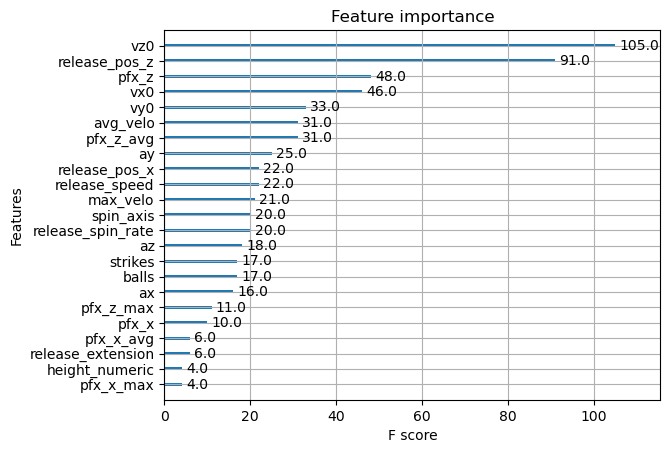

In [15]:
xgb.plot_importance(model)
plt.show()

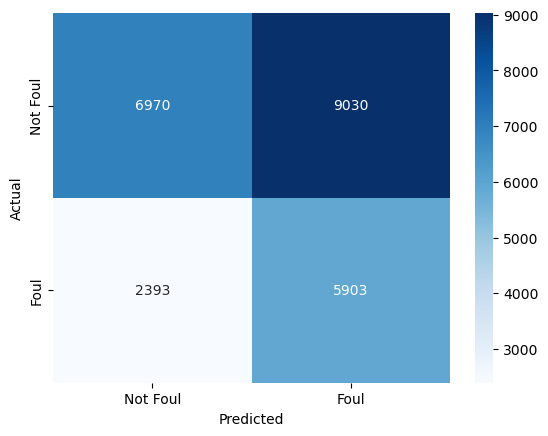

In [16]:
# Convert predicted probabilities to binary predictions
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Foul', 'Foul'], yticklabels=['Not Foul', 'Foul'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Initial Paramater Tuning

In [17]:
def objective(trial):
    dtrain = xgb.DMatrix(x_train, label=y_train)
    dvalid = xgb.DMatrix(x_valid, label=y_valid)
    
    param = {
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'eta': trial.suggest_float('eta', 0.01, 0.3),
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        'scale_pos_weight': class_ratio
    }

    # Train the model with early stopping
    model = xgb.train(
        param, 
        dtrain, 
        num_boost_round=100,  # Maximum number of boosting rounds
        evals=[(dvalid, 'eval')],  # Validation set for early stopping
        early_stopping_rounds=50  # Stop if the eval metric doesn't improve for 50 rounds
    )
    
    # Predict on the validation set using the best iteration
    y_valid_pred = model.predict(dvalid)
    
    # Calculate the log loss on the validation set
    loss = log_loss(y_valid, y_valid_pred)

    return loss

In [18]:
#create an optuna study and specifcy the the direction of the optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)

[I 2023-11-13 11:51:45,192] A new study created in memory with name: no-name-f7724364-6516-4664-83a5-84be5ecadf23


[0]	eval-logloss:0.69208
[1]	eval-logloss:0.68863
[2]	eval-logloss:0.68596
[3]	eval-logloss:0.68375
[4]	eval-logloss:0.68234
[5]	eval-logloss:0.68122
[6]	eval-logloss:0.67976
[7]	eval-logloss:0.67837
[8]	eval-logloss:0.67742
[9]	eval-logloss:0.67674
[10]	eval-logloss:0.67653
[11]	eval-logloss:0.67607
[12]	eval-logloss:0.67531
[13]	eval-logloss:0.67462
[14]	eval-logloss:0.67397
[15]	eval-logloss:0.67355
[16]	eval-logloss:0.67313
[17]	eval-logloss:0.67266
[18]	eval-logloss:0.67204
[19]	eval-logloss:0.67186
[20]	eval-logloss:0.67147
[21]	eval-logloss:0.67107
[22]	eval-logloss:0.67090
[23]	eval-logloss:0.67070
[24]	eval-logloss:0.67014
[25]	eval-logloss:0.66997
[26]	eval-logloss:0.67005
[27]	eval-logloss:0.66989
[28]	eval-logloss:0.66996
[29]	eval-logloss:0.66964
[30]	eval-logloss:0.66965
[31]	eval-logloss:0.66946
[32]	eval-logloss:0.66920
[33]	eval-logloss:0.66899
[34]	eval-logloss:0.66906
[35]	eval-logloss:0.66907
[36]	eval-logloss:0.66894
[37]	eval-logloss:0.66875
[38]	eval-logloss:0.66

[I 2023-11-13 11:51:46,924] Trial 0 finished with value: 0.6670050865357086 and parameters: {'max_depth': 4, 'eta': 0.14705751347436619, 'subsample': 0.7289264293138622, 'colsample_bytree': 0.7845539597998035}. Best is trial 0 with value: 0.6670050865357086.


[0]	eval-logloss:0.69124
[1]	eval-logloss:0.68984
[2]	eval-logloss:0.68353
[3]	eval-logloss:0.67999
[4]	eval-logloss:0.67725
[5]	eval-logloss:0.67568
[6]	eval-logloss:0.67373
[7]	eval-logloss:0.67191
[8]	eval-logloss:0.67104
[9]	eval-logloss:0.67054
[10]	eval-logloss:0.67039
[11]	eval-logloss:0.66986
[12]	eval-logloss:0.66933
[13]	eval-logloss:0.66892
[14]	eval-logloss:0.66875
[15]	eval-logloss:0.66893
[16]	eval-logloss:0.66935
[17]	eval-logloss:0.66954
[18]	eval-logloss:0.66916
[19]	eval-logloss:0.66909
[20]	eval-logloss:0.66922
[21]	eval-logloss:0.66918
[22]	eval-logloss:0.66937
[23]	eval-logloss:0.66957
[24]	eval-logloss:0.66949
[25]	eval-logloss:0.66958
[26]	eval-logloss:0.66993
[27]	eval-logloss:0.66991
[28]	eval-logloss:0.67008
[29]	eval-logloss:0.66990
[30]	eval-logloss:0.66994
[31]	eval-logloss:0.66996
[32]	eval-logloss:0.66968
[33]	eval-logloss:0.66965
[34]	eval-logloss:0.66985
[35]	eval-logloss:0.66993
[36]	eval-logloss:0.67021
[37]	eval-logloss:0.67073
[38]	eval-logloss:0.67

[I 2023-11-13 11:51:48,564] Trial 1 finished with value: 0.6739116834247996 and parameters: {'max_depth': 8, 'eta': 0.20860423833312408, 'subsample': 0.7426279817032435, 'colsample_bytree': 0.5975838006927278}. Best is trial 0 with value: 0.6670050865357086.


[0]	eval-logloss:0.69141
[1]	eval-logloss:0.68800
[2]	eval-logloss:0.68529
[3]	eval-logloss:0.68301
[4]	eval-logloss:0.68113
[5]	eval-logloss:0.68029
[6]	eval-logloss:0.67881
[7]	eval-logloss:0.67755
[8]	eval-logloss:0.67632
[9]	eval-logloss:0.67530
[10]	eval-logloss:0.67448
[11]	eval-logloss:0.67369
[12]	eval-logloss:0.67305
[13]	eval-logloss:0.67249
[14]	eval-logloss:0.67184
[15]	eval-logloss:0.67147
[16]	eval-logloss:0.67120
[17]	eval-logloss:0.67092
[18]	eval-logloss:0.67053
[19]	eval-logloss:0.67014
[20]	eval-logloss:0.66978
[21]	eval-logloss:0.66932
[22]	eval-logloss:0.66918
[23]	eval-logloss:0.66904
[24]	eval-logloss:0.66865
[25]	eval-logloss:0.66849
[26]	eval-logloss:0.66836
[27]	eval-logloss:0.66816
[28]	eval-logloss:0.66806
[29]	eval-logloss:0.66797
[30]	eval-logloss:0.66783
[31]	eval-logloss:0.66772
[32]	eval-logloss:0.66760
[33]	eval-logloss:0.66741
[34]	eval-logloss:0.66734
[35]	eval-logloss:0.66731
[36]	eval-logloss:0.66721
[37]	eval-logloss:0.66704
[38]	eval-logloss:0.66

[I 2023-11-13 11:51:50,659] Trial 2 finished with value: 0.6645827191650505 and parameters: {'max_depth': 5, 'eta': 0.12073150061804883, 'subsample': 0.8759593969995723, 'colsample_bytree': 0.8933644465758983}. Best is trial 2 with value: 0.6645827191650505.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69280
[2]	eval-logloss:0.69235
[3]	eval-logloss:0.69191
[4]	eval-logloss:0.69155
[5]	eval-logloss:0.69136
[6]	eval-logloss:0.69097
[7]	eval-logloss:0.69056
[8]	eval-logloss:0.69016
[9]	eval-logloss:0.68983
[10]	eval-logloss:0.68972
[11]	eval-logloss:0.68957
[12]	eval-logloss:0.68921
[13]	eval-logloss:0.68887
[14]	eval-logloss:0.68850
[15]	eval-logloss:0.68820
[16]	eval-logloss:0.68791
[17]	eval-logloss:0.68761
[18]	eval-logloss:0.68743
[19]	eval-logloss:0.68730
[20]	eval-logloss:0.68700
[21]	eval-logloss:0.68670
[22]	eval-logloss:0.68645
[23]	eval-logloss:0.68633
[24]	eval-logloss:0.68603
[25]	eval-logloss:0.68577
[26]	eval-logloss:0.68557
[27]	eval-logloss:0.68534
[28]	eval-logloss:0.68524
[29]	eval-logloss:0.68499
[30]	eval-logloss:0.68495
[31]	eval-logloss:0.68471
[32]	eval-logloss:0.68445
[33]	eval-logloss:0.68432
[34]	eval-logloss:0.68424
[35]	eval-logloss:0.68414
[36]	eval-logloss:0.68404
[37]	eval-logloss:0.68383
[38]	eval-logloss:0.68

[I 2023-11-13 11:51:52,105] Trial 3 finished with value: 0.6774741033127458 and parameters: {'max_depth': 3, 'eta': 0.02108754943680606, 'subsample': 0.7230313072046286, 'colsample_bytree': 0.6925393182917337}. Best is trial 2 with value: 0.6645827191650505.


[0]	eval-logloss:0.69260
[1]	eval-logloss:0.69160
[2]	eval-logloss:0.69068
[3]	eval-logloss:0.68981
[4]	eval-logloss:0.68896
[5]	eval-logloss:0.68854
[6]	eval-logloss:0.68776
[7]	eval-logloss:0.68701
[8]	eval-logloss:0.68621
[9]	eval-logloss:0.68552
[10]	eval-logloss:0.68489
[11]	eval-logloss:0.68424
[12]	eval-logloss:0.68357
[13]	eval-logloss:0.68302
[14]	eval-logloss:0.68245
[15]	eval-logloss:0.68192
[16]	eval-logloss:0.68140
[17]	eval-logloss:0.68095
[18]	eval-logloss:0.68063
[19]	eval-logloss:0.68017
[20]	eval-logloss:0.67971
[21]	eval-logloss:0.67923
[22]	eval-logloss:0.67883
[23]	eval-logloss:0.67864
[24]	eval-logloss:0.67823
[25]	eval-logloss:0.67781
[26]	eval-logloss:0.67747
[27]	eval-logloss:0.67713
[28]	eval-logloss:0.67687
[29]	eval-logloss:0.67650
[30]	eval-logloss:0.67632
[31]	eval-logloss:0.67598
[32]	eval-logloss:0.67565
[33]	eval-logloss:0.67538
[34]	eval-logloss:0.67511
[35]	eval-logloss:0.67483
[36]	eval-logloss:0.67464
[37]	eval-logloss:0.67435
[38]	eval-logloss:0.67

[I 2023-11-13 11:51:54,177] Trial 4 finished with value: 0.6666086200791574 and parameters: {'max_depth': 6, 'eta': 0.02791265137793083, 'subsample': 0.7370566875820315, 'colsample_bytree': 0.9276790513609969}. Best is trial 2 with value: 0.6645827191650505.


[0]	eval-logloss:0.69142
[1]	eval-logloss:0.68486
[2]	eval-logloss:0.67972
[3]	eval-logloss:0.67724
[4]	eval-logloss:0.67537
[5]	eval-logloss:0.67430
[6]	eval-logloss:0.67276
[7]	eval-logloss:0.67165
[8]	eval-logloss:0.67097
[9]	eval-logloss:0.66998
[10]	eval-logloss:0.66960
[11]	eval-logloss:0.66916
[12]	eval-logloss:0.66898
[13]	eval-logloss:0.66880
[14]	eval-logloss:0.66841
[15]	eval-logloss:0.66813
[16]	eval-logloss:0.66832
[17]	eval-logloss:0.66817
[18]	eval-logloss:0.66777
[19]	eval-logloss:0.66797
[20]	eval-logloss:0.66763
[21]	eval-logloss:0.66745
[22]	eval-logloss:0.66774
[23]	eval-logloss:0.66790
[24]	eval-logloss:0.66779
[25]	eval-logloss:0.66764
[26]	eval-logloss:0.66781
[27]	eval-logloss:0.66781
[28]	eval-logloss:0.66800
[29]	eval-logloss:0.66801
[30]	eval-logloss:0.66816
[31]	eval-logloss:0.66807
[32]	eval-logloss:0.66831
[33]	eval-logloss:0.66811
[34]	eval-logloss:0.66789
[35]	eval-logloss:0.66794
[36]	eval-logloss:0.66800
[37]	eval-logloss:0.66791
[38]	eval-logloss:0.66

[I 2023-11-13 11:51:56,369] Trial 5 finished with value: 0.6712635735978523 and parameters: {'max_depth': 7, 'eta': 0.24212424083826015, 'subsample': 0.8484829454968426, 'colsample_bytree': 0.7322265761181794}. Best is trial 2 with value: 0.6645827191650505.


[0]	eval-logloss:0.69114
[1]	eval-logloss:0.68463
[2]	eval-logloss:0.67976
[3]	eval-logloss:0.67733
[4]	eval-logloss:0.67505
[5]	eval-logloss:0.67350
[6]	eval-logloss:0.67208
[7]	eval-logloss:0.67131
[8]	eval-logloss:0.67098
[9]	eval-logloss:0.67058
[10]	eval-logloss:0.67091
[11]	eval-logloss:0.67040
[12]	eval-logloss:0.66983
[13]	eval-logloss:0.66949
[14]	eval-logloss:0.66910
[15]	eval-logloss:0.66928
[16]	eval-logloss:0.66920
[17]	eval-logloss:0.66903
[18]	eval-logloss:0.66839
[19]	eval-logloss:0.66822
[20]	eval-logloss:0.66851
[21]	eval-logloss:0.66818
[22]	eval-logloss:0.66888
[23]	eval-logloss:0.66890
[24]	eval-logloss:0.66847
[25]	eval-logloss:0.66878
[26]	eval-logloss:0.66927
[27]	eval-logloss:0.66928
[28]	eval-logloss:0.66977
[29]	eval-logloss:0.66979
[30]	eval-logloss:0.66985
[31]	eval-logloss:0.66978
[32]	eval-logloss:0.66959
[33]	eval-logloss:0.66984
[34]	eval-logloss:0.67001
[35]	eval-logloss:0.67009
[36]	eval-logloss:0.67043
[37]	eval-logloss:0.67050
[38]	eval-logloss:0.67

[I 2023-11-13 11:51:58,207] Trial 6 finished with value: 0.6737929127282153 and parameters: {'max_depth': 7, 'eta': 0.2366420000980004, 'subsample': 0.6668535274646286, 'colsample_bytree': 0.7403455655818627}. Best is trial 2 with value: 0.6645827191650505.


[0]	eval-logloss:0.69166
[1]	eval-logloss:0.69046
[2]	eval-logloss:0.68502
[3]	eval-logloss:0.68182
[4]	eval-logloss:0.67920
[5]	eval-logloss:0.67814
[6]	eval-logloss:0.67590
[7]	eval-logloss:0.67531
[8]	eval-logloss:0.67384
[9]	eval-logloss:0.67239
[10]	eval-logloss:0.67221
[11]	eval-logloss:0.67151
[12]	eval-logloss:0.67038
[13]	eval-logloss:0.66955
[14]	eval-logloss:0.66920
[15]	eval-logloss:0.66867
[16]	eval-logloss:0.66854
[17]	eval-logloss:0.66830
[18]	eval-logloss:0.66798
[19]	eval-logloss:0.66761
[20]	eval-logloss:0.66771
[21]	eval-logloss:0.66746
[22]	eval-logloss:0.66753
[23]	eval-logloss:0.66756
[24]	eval-logloss:0.66711
[25]	eval-logloss:0.66729
[26]	eval-logloss:0.66737
[27]	eval-logloss:0.66705
[28]	eval-logloss:0.66735
[29]	eval-logloss:0.66723
[30]	eval-logloss:0.66718
[31]	eval-logloss:0.66712
[32]	eval-logloss:0.66686
[33]	eval-logloss:0.66662
[34]	eval-logloss:0.66678
[35]	eval-logloss:0.66672
[36]	eval-logloss:0.66650
[37]	eval-logloss:0.66658
[38]	eval-logloss:0.66

[I 2023-11-13 11:52:00,245] Trial 7 finished with value: 0.6680911551292406 and parameters: {'max_depth': 7, 'eta': 0.1672520592947656, 'subsample': 0.6129030708484456, 'colsample_bytree': 0.5126353551878322}. Best is trial 2 with value: 0.6645827191650505.


[0]	eval-logloss:0.69273
[1]	eval-logloss:0.69127
[2]	eval-logloss:0.68994
[3]	eval-logloss:0.68878
[4]	eval-logloss:0.68775
[5]	eval-logloss:0.68721
[6]	eval-logloss:0.68620
[7]	eval-logloss:0.68527
[8]	eval-logloss:0.68441
[9]	eval-logloss:0.68360
[10]	eval-logloss:0.68338
[11]	eval-logloss:0.68299
[12]	eval-logloss:0.68233
[13]	eval-logloss:0.68173
[14]	eval-logloss:0.68115
[15]	eval-logloss:0.68059
[16]	eval-logloss:0.68018
[17]	eval-logloss:0.67973
[18]	eval-logloss:0.67937
[19]	eval-logloss:0.67902
[20]	eval-logloss:0.67852
[21]	eval-logloss:0.67812
[22]	eval-logloss:0.67774
[23]	eval-logloss:0.67752
[24]	eval-logloss:0.67707
[25]	eval-logloss:0.67668
[26]	eval-logloss:0.67639
[27]	eval-logloss:0.67611
[28]	eval-logloss:0.67597
[29]	eval-logloss:0.67567
[30]	eval-logloss:0.67553
[31]	eval-logloss:0.67524
[32]	eval-logloss:0.67496
[33]	eval-logloss:0.67466
[34]	eval-logloss:0.67457
[35]	eval-logloss:0.67445
[36]	eval-logloss:0.67428
[37]	eval-logloss:0.67400
[38]	eval-logloss:0.67

[I 2023-11-13 11:52:01,953] Trial 8 finished with value: 0.6680636338517272 and parameters: {'max_depth': 4, 'eta': 0.05634218554201746, 'subsample': 0.8936852011997494, 'colsample_bytree': 0.7455671504239245}. Best is trial 2 with value: 0.6645827191650505.


[0]	eval-logloss:0.69177
[1]	eval-logloss:0.69092
[2]	eval-logloss:0.68558
[3]	eval-logloss:0.68224
[4]	eval-logloss:0.68000
[5]	eval-logloss:0.67897
[6]	eval-logloss:0.67676
[7]	eval-logloss:0.67537
[8]	eval-logloss:0.67402
[9]	eval-logloss:0.67283
[10]	eval-logloss:0.67261
[11]	eval-logloss:0.67188
[12]	eval-logloss:0.67095
[13]	eval-logloss:0.67046
[14]	eval-logloss:0.66983
[15]	eval-logloss:0.66942
[16]	eval-logloss:0.66929
[17]	eval-logloss:0.66892
[18]	eval-logloss:0.66861
[19]	eval-logloss:0.66830
[20]	eval-logloss:0.66795
[21]	eval-logloss:0.66771
[22]	eval-logloss:0.66775
[23]	eval-logloss:0.66765
[24]	eval-logloss:0.66739
[25]	eval-logloss:0.66732
[26]	eval-logloss:0.66744
[27]	eval-logloss:0.66727
[28]	eval-logloss:0.66746
[29]	eval-logloss:0.66721
[30]	eval-logloss:0.66718
[31]	eval-logloss:0.66707
[32]	eval-logloss:0.66717
[33]	eval-logloss:0.66691
[34]	eval-logloss:0.66700
[35]	eval-logloss:0.66701
[36]	eval-logloss:0.66685
[37]	eval-logloss:0.66688
[38]	eval-logloss:0.66

[I 2023-11-13 11:52:03,518] Trial 9 finished with value: 0.6666208242267034 and parameters: {'max_depth': 5, 'eta': 0.20214996261982351, 'subsample': 0.8442295926581324, 'colsample_bytree': 0.5768408303430136}. Best is trial 2 with value: 0.6645827191650505.


[0]	eval-logloss:0.69053
[1]	eval-logloss:0.68626
[2]	eval-logloss:0.68295
[3]	eval-logloss:0.67991
[4]	eval-logloss:0.67779
[5]	eval-logloss:0.67586
[6]	eval-logloss:0.67416
[7]	eval-logloss:0.67265
[8]	eval-logloss:0.67140
[9]	eval-logloss:0.67046
[10]	eval-logloss:0.66972
[11]	eval-logloss:0.66893
[12]	eval-logloss:0.66827
[13]	eval-logloss:0.66766
[14]	eval-logloss:0.66722
[15]	eval-logloss:0.66693
[16]	eval-logloss:0.66653
[17]	eval-logloss:0.66616
[18]	eval-logloss:0.66580
[19]	eval-logloss:0.66553
[20]	eval-logloss:0.66532
[21]	eval-logloss:0.66494
[22]	eval-logloss:0.66481
[23]	eval-logloss:0.66474
[24]	eval-logloss:0.66444
[25]	eval-logloss:0.66412
[26]	eval-logloss:0.66390
[27]	eval-logloss:0.66356
[28]	eval-logloss:0.66360
[29]	eval-logloss:0.66362
[30]	eval-logloss:0.66354
[31]	eval-logloss:0.66346
[32]	eval-logloss:0.66340
[33]	eval-logloss:0.66331
[34]	eval-logloss:0.66332
[35]	eval-logloss:0.66325
[36]	eval-logloss:0.66306
[37]	eval-logloss:0.66317
[38]	eval-logloss:0.66

[I 2023-11-13 11:52:07,457] Trial 10 finished with value: 0.6619117887406637 and parameters: {'max_depth': 9, 'eta': 0.10453610580958268, 'subsample': 0.8101188083859868, 'colsample_bytree': 0.9869753808185903}. Best is trial 10 with value: 0.6619117887406637.


[0]	eval-logloss:0.69059
[1]	eval-logloss:0.68624
[2]	eval-logloss:0.68303
[3]	eval-logloss:0.68002
[4]	eval-logloss:0.67768
[5]	eval-logloss:0.67564
[6]	eval-logloss:0.67416
[7]	eval-logloss:0.67261
[8]	eval-logloss:0.67119
[9]	eval-logloss:0.67023
[10]	eval-logloss:0.66919
[11]	eval-logloss:0.66816
[12]	eval-logloss:0.66760
[13]	eval-logloss:0.66710
[14]	eval-logloss:0.66624
[15]	eval-logloss:0.66607
[16]	eval-logloss:0.66564
[17]	eval-logloss:0.66524
[18]	eval-logloss:0.66481
[19]	eval-logloss:0.66470
[20]	eval-logloss:0.66434
[21]	eval-logloss:0.66410
[22]	eval-logloss:0.66373
[23]	eval-logloss:0.66363
[24]	eval-logloss:0.66328
[25]	eval-logloss:0.66297
[26]	eval-logloss:0.66280
[27]	eval-logloss:0.66262
[28]	eval-logloss:0.66252
[29]	eval-logloss:0.66254
[30]	eval-logloss:0.66250
[31]	eval-logloss:0.66234
[32]	eval-logloss:0.66232
[33]	eval-logloss:0.66207
[34]	eval-logloss:0.66196
[35]	eval-logloss:0.66191
[36]	eval-logloss:0.66189
[37]	eval-logloss:0.66173
[38]	eval-logloss:0.66

[I 2023-11-13 11:52:11,267] Trial 11 finished with value: 0.6606047640338246 and parameters: {'max_depth': 9, 'eta': 0.10420832364583033, 'subsample': 0.8065437316542927, 'colsample_bytree': 0.9952562034740675}. Best is trial 11 with value: 0.6606047640338246.


[0]	eval-logloss:0.69077
[1]	eval-logloss:0.68673
[2]	eval-logloss:0.68366
[3]	eval-logloss:0.68078
[4]	eval-logloss:0.67859
[5]	eval-logloss:0.67670
[6]	eval-logloss:0.67519
[7]	eval-logloss:0.67377
[8]	eval-logloss:0.67250
[9]	eval-logloss:0.67123
[10]	eval-logloss:0.67031
[11]	eval-logloss:0.66939
[12]	eval-logloss:0.66881
[13]	eval-logloss:0.66821
[14]	eval-logloss:0.66753
[15]	eval-logloss:0.66708
[16]	eval-logloss:0.66684
[17]	eval-logloss:0.66648
[18]	eval-logloss:0.66598
[19]	eval-logloss:0.66576
[20]	eval-logloss:0.66564
[21]	eval-logloss:0.66548
[22]	eval-logloss:0.66549
[23]	eval-logloss:0.66526
[24]	eval-logloss:0.66498
[25]	eval-logloss:0.66486
[26]	eval-logloss:0.66482
[27]	eval-logloss:0.66453
[28]	eval-logloss:0.66440
[29]	eval-logloss:0.66439
[30]	eval-logloss:0.66425
[31]	eval-logloss:0.66442
[32]	eval-logloss:0.66443
[33]	eval-logloss:0.66409
[34]	eval-logloss:0.66401
[35]	eval-logloss:0.66387
[36]	eval-logloss:0.66377
[37]	eval-logloss:0.66391
[38]	eval-logloss:0.66

[I 2023-11-13 11:52:18,283] Trial 12 finished with value: 0.6628667038113508 and parameters: {'max_depth': 9, 'eta': 0.09468969120916015, 'subsample': 0.8052791792386782, 'colsample_bytree': 0.9998051389175373}. Best is trial 11 with value: 0.6606047640338246.


[0]	eval-logloss:0.69068
[1]	eval-logloss:0.68690
[2]	eval-logloss:0.68381
[3]	eval-logloss:0.68094
[4]	eval-logloss:0.67886
[5]	eval-logloss:0.67689
[6]	eval-logloss:0.67524
[7]	eval-logloss:0.67387
[8]	eval-logloss:0.67258
[9]	eval-logloss:0.67142
[10]	eval-logloss:0.67053
[11]	eval-logloss:0.66970
[12]	eval-logloss:0.66916
[13]	eval-logloss:0.66867
[14]	eval-logloss:0.66800
[15]	eval-logloss:0.66734
[16]	eval-logloss:0.66701
[17]	eval-logloss:0.66664
[18]	eval-logloss:0.66622
[19]	eval-logloss:0.66582
[20]	eval-logloss:0.66549
[21]	eval-logloss:0.66510
[22]	eval-logloss:0.66493
[23]	eval-logloss:0.66477
[24]	eval-logloss:0.66452
[25]	eval-logloss:0.66435
[26]	eval-logloss:0.66424
[27]	eval-logloss:0.66391
[28]	eval-logloss:0.66392
[29]	eval-logloss:0.66383
[30]	eval-logloss:0.66364
[31]	eval-logloss:0.66363
[32]	eval-logloss:0.66349
[33]	eval-logloss:0.66339
[34]	eval-logloss:0.66341
[35]	eval-logloss:0.66315
[36]	eval-logloss:0.66312
[37]	eval-logloss:0.66294
[38]	eval-logloss:0.66

[I 2023-11-13 11:52:24,891] Trial 13 finished with value: 0.6611837526073435 and parameters: {'max_depth': 9, 'eta': 0.09444224324227736, 'subsample': 0.7927150493245455, 'colsample_bytree': 0.9963203067392912}. Best is trial 11 with value: 0.6606047640338246.


[0]	eval-logloss:0.69159
[1]	eval-logloss:0.68894
[2]	eval-logloss:0.68658
[3]	eval-logloss:0.68452
[4]	eval-logloss:0.68257
[5]	eval-logloss:0.68158
[6]	eval-logloss:0.67992
[7]	eval-logloss:0.67832
[8]	eval-logloss:0.67711
[9]	eval-logloss:0.67581
[10]	eval-logloss:0.67476
[11]	eval-logloss:0.67371
[12]	eval-logloss:0.67273
[13]	eval-logloss:0.67189
[14]	eval-logloss:0.67118
[15]	eval-logloss:0.67043
[16]	eval-logloss:0.66985
[17]	eval-logloss:0.66923
[18]	eval-logloss:0.66865
[19]	eval-logloss:0.66817
[20]	eval-logloss:0.66778
[21]	eval-logloss:0.66741
[22]	eval-logloss:0.66704
[23]	eval-logloss:0.66680
[24]	eval-logloss:0.66646
[25]	eval-logloss:0.66609
[26]	eval-logloss:0.66588
[27]	eval-logloss:0.66561
[28]	eval-logloss:0.66533
[29]	eval-logloss:0.66517
[30]	eval-logloss:0.66512
[31]	eval-logloss:0.66483
[32]	eval-logloss:0.66459
[33]	eval-logloss:0.66435
[34]	eval-logloss:0.66427
[35]	eval-logloss:0.66399
[36]	eval-logloss:0.66382
[37]	eval-logloss:0.66367
[38]	eval-logloss:0.66

[I 2023-11-13 11:52:29,526] Trial 14 finished with value: 0.6598219795076237 and parameters: {'max_depth': 9, 'eta': 0.06328436465375695, 'subsample': 0.7904116487974598, 'colsample_bytree': 0.8713327866230222}. Best is trial 14 with value: 0.6598219795076237.


[0]	eval-logloss:0.69169
[1]	eval-logloss:0.68902
[2]	eval-logloss:0.68666
[3]	eval-logloss:0.68485
[4]	eval-logloss:0.68296
[5]	eval-logloss:0.68200
[6]	eval-logloss:0.68040
[7]	eval-logloss:0.67897
[8]	eval-logloss:0.67785
[9]	eval-logloss:0.67674
[10]	eval-logloss:0.67588
[11]	eval-logloss:0.67487
[12]	eval-logloss:0.67393
[13]	eval-logloss:0.67317
[14]	eval-logloss:0.67247
[15]	eval-logloss:0.67180
[16]	eval-logloss:0.67129
[17]	eval-logloss:0.67075
[18]	eval-logloss:0.67033
[19]	eval-logloss:0.66988
[20]	eval-logloss:0.66957
[21]	eval-logloss:0.66927
[22]	eval-logloss:0.66907
[23]	eval-logloss:0.66881
[24]	eval-logloss:0.66842
[25]	eval-logloss:0.66804
[26]	eval-logloss:0.66784
[27]	eval-logloss:0.66756
[28]	eval-logloss:0.66722
[29]	eval-logloss:0.66691
[30]	eval-logloss:0.66686
[31]	eval-logloss:0.66662
[32]	eval-logloss:0.66643
[33]	eval-logloss:0.66617
[34]	eval-logloss:0.66614
[35]	eval-logloss:0.66596
[36]	eval-logloss:0.66573
[37]	eval-logloss:0.66558
[38]	eval-logloss:0.66

[I 2023-11-13 11:52:32,747] Trial 15 finished with value: 0.6618026422715106 and parameters: {'max_depth': 8, 'eta': 0.06468298238215929, 'subsample': 0.7686970852881152, 'colsample_bytree': 0.851294207318383}. Best is trial 14 with value: 0.6598219795076237.


[0]	eval-logloss:0.68806
[1]	eval-logloss:0.67977
[2]	eval-logloss:0.67485
[3]	eval-logloss:0.67199
[4]	eval-logloss:0.67037
[5]	eval-logloss:0.67011
[6]	eval-logloss:0.66928
[7]	eval-logloss:0.66838
[8]	eval-logloss:0.66801
[9]	eval-logloss:0.66766
[10]	eval-logloss:0.66777
[11]	eval-logloss:0.66755
[12]	eval-logloss:0.66757
[13]	eval-logloss:0.66757
[14]	eval-logloss:0.66732
[15]	eval-logloss:0.66740
[16]	eval-logloss:0.66754
[17]	eval-logloss:0.66752
[18]	eval-logloss:0.66746
[19]	eval-logloss:0.66779
[20]	eval-logloss:0.66832
[21]	eval-logloss:0.66804
[22]	eval-logloss:0.66844
[23]	eval-logloss:0.66801
[24]	eval-logloss:0.66799
[25]	eval-logloss:0.66837
[26]	eval-logloss:0.66845
[27]	eval-logloss:0.66817
[28]	eval-logloss:0.66858
[29]	eval-logloss:0.66837
[30]	eval-logloss:0.66838
[31]	eval-logloss:0.66852
[32]	eval-logloss:0.66857
[33]	eval-logloss:0.66846
[34]	eval-logloss:0.66883
[35]	eval-logloss:0.66931
[36]	eval-logloss:0.66932
[37]	eval-logloss:0.66944
[38]	eval-logloss:0.66

[I 2023-11-13 11:52:35,467] Trial 16 finished with value: 0.6755051437904857 and parameters: {'max_depth': 8, 'eta': 0.28369724857165823, 'subsample': 0.8273734106323887, 'colsample_bytree': 0.8496509808878384}. Best is trial 14 with value: 0.6598219795076237.


[0]	eval-logloss:0.69157
[1]	eval-logloss:0.68895
[2]	eval-logloss:0.68681
[3]	eval-logloss:0.68476
[4]	eval-logloss:0.68303
[5]	eval-logloss:0.68199
[6]	eval-logloss:0.68047
[7]	eval-logloss:0.67899
[8]	eval-logloss:0.67773
[9]	eval-logloss:0.67649
[10]	eval-logloss:0.67546
[11]	eval-logloss:0.67448
[12]	eval-logloss:0.67358
[13]	eval-logloss:0.67286
[14]	eval-logloss:0.67221
[15]	eval-logloss:0.67148
[16]	eval-logloss:0.67085
[17]	eval-logloss:0.67022
[18]	eval-logloss:0.66965
[19]	eval-logloss:0.66899
[20]	eval-logloss:0.66861
[21]	eval-logloss:0.66812
[22]	eval-logloss:0.66782
[23]	eval-logloss:0.66759
[24]	eval-logloss:0.66711
[25]	eval-logloss:0.66658
[26]	eval-logloss:0.66632
[27]	eval-logloss:0.66606
[28]	eval-logloss:0.66582
[29]	eval-logloss:0.66556
[30]	eval-logloss:0.66543
[31]	eval-logloss:0.66517
[32]	eval-logloss:0.66491
[33]	eval-logloss:0.66470
[34]	eval-logloss:0.66461
[35]	eval-logloss:0.66431
[36]	eval-logloss:0.66411
[37]	eval-logloss:0.66401
[38]	eval-logloss:0.66

[I 2023-11-13 11:52:39,591] Trial 17 finished with value: 0.6603135731821802 and parameters: {'max_depth': 9, 'eta': 0.05807607325941156, 'subsample': 0.7974034668480439, 'colsample_bytree': 0.9279418471834799}. Best is trial 14 with value: 0.6598219795076237.


[0]	eval-logloss:0.69285
[1]	eval-logloss:0.69231
[2]	eval-logloss:0.69179
[3]	eval-logloss:0.69124
[4]	eval-logloss:0.69073
[5]	eval-logloss:0.69046
[6]	eval-logloss:0.68997
[7]	eval-logloss:0.68950
[8]	eval-logloss:0.68901
[9]	eval-logloss:0.68857
[10]	eval-logloss:0.68814
[11]	eval-logloss:0.68769
[12]	eval-logloss:0.68722
[13]	eval-logloss:0.68683
[14]	eval-logloss:0.68643
[15]	eval-logloss:0.68602
[16]	eval-logloss:0.68566
[17]	eval-logloss:0.68528
[18]	eval-logloss:0.68503
[19]	eval-logloss:0.68464
[20]	eval-logloss:0.68426
[21]	eval-logloss:0.68389
[22]	eval-logloss:0.68352
[23]	eval-logloss:0.68337
[24]	eval-logloss:0.68301
[25]	eval-logloss:0.68267
[26]	eval-logloss:0.68234
[27]	eval-logloss:0.68203
[28]	eval-logloss:0.68172
[29]	eval-logloss:0.68139
[30]	eval-logloss:0.68123
[31]	eval-logloss:0.68091
[32]	eval-logloss:0.68061
[33]	eval-logloss:0.68032
[34]	eval-logloss:0.68008
[35]	eval-logloss:0.67979
[36]	eval-logloss:0.67962
[37]	eval-logloss:0.67937
[38]	eval-logloss:0.67

[I 2023-11-13 11:52:42,897] Trial 18 finished with value: 0.6694588635342117 and parameters: {'max_depth': 8, 'eta': 0.012515525165453123, 'subsample': 0.7747429241019994, 'colsample_bytree': 0.9198820836374952}. Best is trial 14 with value: 0.6598219795076237.


[0]	eval-logloss:0.69261
[1]	eval-logloss:0.69048
[2]	eval-logloss:0.68862
[3]	eval-logloss:0.68704
[4]	eval-logloss:0.68568
[5]	eval-logloss:0.68485
[6]	eval-logloss:0.68354
[7]	eval-logloss:0.68228
[8]	eval-logloss:0.68128
[9]	eval-logloss:0.68026
[10]	eval-logloss:0.68006
[11]	eval-logloss:0.67952
[12]	eval-logloss:0.67858
[13]	eval-logloss:0.67782
[14]	eval-logloss:0.67701
[15]	eval-logloss:0.67624
[16]	eval-logloss:0.67561
[17]	eval-logloss:0.67506
[18]	eval-logloss:0.67459
[19]	eval-logloss:0.67406
[20]	eval-logloss:0.67360
[21]	eval-logloss:0.67311
[22]	eval-logloss:0.67272
[23]	eval-logloss:0.67249
[24]	eval-logloss:0.67204
[25]	eval-logloss:0.67158
[26]	eval-logloss:0.67133
[27]	eval-logloss:0.67102
[28]	eval-logloss:0.67075
[29]	eval-logloss:0.67041
[30]	eval-logloss:0.67022
[31]	eval-logloss:0.66991
[32]	eval-logloss:0.66963
[33]	eval-logloss:0.66939
[34]	eval-logloss:0.66919
[35]	eval-logloss:0.66894
[36]	eval-logloss:0.66878
[37]	eval-logloss:0.66855
[38]	eval-logloss:0.66

[I 2023-11-13 11:52:45,319] Trial 19 finished with value: 0.6642016215942291 and parameters: {'max_depth': 6, 'eta': 0.05987338244874111, 'subsample': 0.7700431886448909, 'colsample_bytree': 0.7986928935178017}. Best is trial 14 with value: 0.6598219795076237.


[0]	eval-logloss:0.69232
[1]	eval-logloss:0.69072
[2]	eval-logloss:0.68916
[3]	eval-logloss:0.68790
[4]	eval-logloss:0.68661
[5]	eval-logloss:0.68594
[6]	eval-logloss:0.68475
[7]	eval-logloss:0.68361
[8]	eval-logloss:0.68269
[9]	eval-logloss:0.68170
[10]	eval-logloss:0.68084
[11]	eval-logloss:0.67992
[12]	eval-logloss:0.67914
[13]	eval-logloss:0.67840
[14]	eval-logloss:0.67776
[15]	eval-logloss:0.67716
[16]	eval-logloss:0.67652
[17]	eval-logloss:0.67599
[18]	eval-logloss:0.67565
[19]	eval-logloss:0.67506
[20]	eval-logloss:0.67459
[21]	eval-logloss:0.67413
[22]	eval-logloss:0.67369
[23]	eval-logloss:0.67345
[24]	eval-logloss:0.67300
[25]	eval-logloss:0.67259
[26]	eval-logloss:0.67224
[27]	eval-logloss:0.67185
[28]	eval-logloss:0.67152
[29]	eval-logloss:0.67110
[30]	eval-logloss:0.67090
[31]	eval-logloss:0.67056
[32]	eval-logloss:0.67028
[33]	eval-logloss:0.66999
[34]	eval-logloss:0.66974
[35]	eval-logloss:0.66950
[36]	eval-logloss:0.66929
[37]	eval-logloss:0.66910
[38]	eval-logloss:0.66

[I 2023-11-13 11:52:48,660] Trial 20 finished with value: 0.6630345674015014 and parameters: {'max_depth': 7, 'eta': 0.04232039020054222, 'subsample': 0.8659114799935735, 'colsample_bytree': 0.8560263541858685}. Best is trial 14 with value: 0.6598219795076237.


[0]	eval-logloss:0.69120
[1]	eval-logloss:0.68797
[2]	eval-logloss:0.68531
[3]	eval-logloss:0.68295
[4]	eval-logloss:0.68104
[5]	eval-logloss:0.67995
[6]	eval-logloss:0.67838
[7]	eval-logloss:0.67692
[8]	eval-logloss:0.67550
[9]	eval-logloss:0.67426
[10]	eval-logloss:0.67327
[11]	eval-logloss:0.67223
[12]	eval-logloss:0.67137
[13]	eval-logloss:0.67061
[14]	eval-logloss:0.66986
[15]	eval-logloss:0.66921
[16]	eval-logloss:0.66855
[17]	eval-logloss:0.66784
[18]	eval-logloss:0.66722
[19]	eval-logloss:0.66666
[20]	eval-logloss:0.66624
[21]	eval-logloss:0.66576
[22]	eval-logloss:0.66552
[23]	eval-logloss:0.66525
[24]	eval-logloss:0.66495
[25]	eval-logloss:0.66466
[26]	eval-logloss:0.66453
[27]	eval-logloss:0.66432
[28]	eval-logloss:0.66422
[29]	eval-logloss:0.66404
[30]	eval-logloss:0.66391
[31]	eval-logloss:0.66370
[32]	eval-logloss:0.66347
[33]	eval-logloss:0.66329
[34]	eval-logloss:0.66323
[35]	eval-logloss:0.66313
[36]	eval-logloss:0.66300
[37]	eval-logloss:0.66277
[38]	eval-logloss:0.66

[I 2023-11-13 11:52:53,171] Trial 21 finished with value: 0.6597849530724179 and parameters: {'max_depth': 9, 'eta': 0.07142249271435971, 'subsample': 0.8005510261095627, 'colsample_bytree': 0.9482876084518406}. Best is trial 21 with value: 0.6597849530724179.


[0]	eval-logloss:0.69157
[1]	eval-logloss:0.68899
[2]	eval-logloss:0.68677
[3]	eval-logloss:0.68465
[4]	eval-logloss:0.68302
[5]	eval-logloss:0.68199
[6]	eval-logloss:0.68048
[7]	eval-logloss:0.67887
[8]	eval-logloss:0.67759
[9]	eval-logloss:0.67637
[10]	eval-logloss:0.67542
[11]	eval-logloss:0.67444
[12]	eval-logloss:0.67344
[13]	eval-logloss:0.67267
[14]	eval-logloss:0.67187
[15]	eval-logloss:0.67116
[16]	eval-logloss:0.67055
[17]	eval-logloss:0.66994
[18]	eval-logloss:0.66938
[19]	eval-logloss:0.66867
[20]	eval-logloss:0.66827
[21]	eval-logloss:0.66761
[22]	eval-logloss:0.66721
[23]	eval-logloss:0.66683
[24]	eval-logloss:0.66638
[25]	eval-logloss:0.66604
[26]	eval-logloss:0.66562
[27]	eval-logloss:0.66525
[28]	eval-logloss:0.66502
[29]	eval-logloss:0.66483
[30]	eval-logloss:0.66464
[31]	eval-logloss:0.66435
[32]	eval-logloss:0.66415
[33]	eval-logloss:0.66383
[34]	eval-logloss:0.66372
[35]	eval-logloss:0.66347
[36]	eval-logloss:0.66322
[37]	eval-logloss:0.66313
[38]	eval-logloss:0.66

[I 2023-11-13 11:52:57,497] Trial 22 finished with value: 0.6591789185939615 and parameters: {'max_depth': 9, 'eta': 0.06013342666897663, 'subsample': 0.8255547315236479, 'colsample_bytree': 0.9355116949737683}. Best is trial 22 with value: 0.6591789185939615.


[0]	eval-logloss:0.69139
[1]	eval-logloss:0.68831
[2]	eval-logloss:0.68561
[3]	eval-logloss:0.68321
[4]	eval-logloss:0.68127
[5]	eval-logloss:0.68008
[6]	eval-logloss:0.67842
[7]	eval-logloss:0.67690
[8]	eval-logloss:0.67562
[9]	eval-logloss:0.67447
[10]	eval-logloss:0.67344
[11]	eval-logloss:0.67254
[12]	eval-logloss:0.67165
[13]	eval-logloss:0.67083
[14]	eval-logloss:0.67014
[15]	eval-logloss:0.66942
[16]	eval-logloss:0.66882
[17]	eval-logloss:0.66851
[18]	eval-logloss:0.66817
[19]	eval-logloss:0.66748
[20]	eval-logloss:0.66704
[21]	eval-logloss:0.66669
[22]	eval-logloss:0.66643
[23]	eval-logloss:0.66624
[24]	eval-logloss:0.66576
[25]	eval-logloss:0.66542
[26]	eval-logloss:0.66529
[27]	eval-logloss:0.66490
[28]	eval-logloss:0.66471
[29]	eval-logloss:0.66442
[30]	eval-logloss:0.66428
[31]	eval-logloss:0.66410
[32]	eval-logloss:0.66389
[33]	eval-logloss:0.66367
[34]	eval-logloss:0.66352
[35]	eval-logloss:0.66333
[36]	eval-logloss:0.66321
[37]	eval-logloss:0.66312
[38]	eval-logloss:0.66

[I 2023-11-13 11:53:00,304] Trial 23 finished with value: 0.6607102048150916 and parameters: {'max_depth': 8, 'eta': 0.07719184196497897, 'subsample': 0.837370993386705, 'colsample_bytree': 0.9575576397481957}. Best is trial 22 with value: 0.6591789185939615.


[0]	eval-logloss:0.69211
[1]	eval-logloss:0.69008
[2]	eval-logloss:0.68821
[3]	eval-logloss:0.68643
[4]	eval-logloss:0.68488
[5]	eval-logloss:0.68402
[6]	eval-logloss:0.68268
[7]	eval-logloss:0.68132
[8]	eval-logloss:0.68010
[9]	eval-logloss:0.67907
[10]	eval-logloss:0.67800
[11]	eval-logloss:0.67703
[12]	eval-logloss:0.67614
[13]	eval-logloss:0.67541
[14]	eval-logloss:0.67465
[15]	eval-logloss:0.67395
[16]	eval-logloss:0.67327
[17]	eval-logloss:0.67267
[18]	eval-logloss:0.67214
[19]	eval-logloss:0.67154
[20]	eval-logloss:0.67105
[21]	eval-logloss:0.67056
[22]	eval-logloss:0.67013
[23]	eval-logloss:0.66986
[24]	eval-logloss:0.66942
[25]	eval-logloss:0.66899
[26]	eval-logloss:0.66862
[27]	eval-logloss:0.66828
[28]	eval-logloss:0.66797
[29]	eval-logloss:0.66755
[30]	eval-logloss:0.66718
[31]	eval-logloss:0.66686
[32]	eval-logloss:0.66653
[33]	eval-logloss:0.66629
[34]	eval-logloss:0.66604
[35]	eval-logloss:0.66589
[36]	eval-logloss:0.66565
[37]	eval-logloss:0.66545
[38]	eval-logloss:0.66

[I 2023-11-13 11:53:03,880] Trial 24 finished with value: 0.660010258402661 and parameters: {'max_depth': 9, 'eta': 0.045018104869574915, 'subsample': 0.8219837899053348, 'colsample_bytree': 0.8891210439369085}. Best is trial 22 with value: 0.6591789185939615.


[0]	eval-logloss:0.69138
[1]	eval-logloss:0.68841
[2]	eval-logloss:0.68572
[3]	eval-logloss:0.68343
[4]	eval-logloss:0.68149
[5]	eval-logloss:0.68035
[6]	eval-logloss:0.67879
[7]	eval-logloss:0.67734
[8]	eval-logloss:0.67596
[9]	eval-logloss:0.67478
[10]	eval-logloss:0.67381
[11]	eval-logloss:0.67286
[12]	eval-logloss:0.67208
[13]	eval-logloss:0.67130
[14]	eval-logloss:0.67065
[15]	eval-logloss:0.67004
[16]	eval-logloss:0.66947
[17]	eval-logloss:0.66890
[18]	eval-logloss:0.66854
[19]	eval-logloss:0.66805
[20]	eval-logloss:0.66766
[21]	eval-logloss:0.66731
[22]	eval-logloss:0.66693
[23]	eval-logloss:0.66682
[24]	eval-logloss:0.66631
[25]	eval-logloss:0.66603
[26]	eval-logloss:0.66580
[27]	eval-logloss:0.66549
[28]	eval-logloss:0.66542
[29]	eval-logloss:0.66527
[30]	eval-logloss:0.66506
[31]	eval-logloss:0.66499
[32]	eval-logloss:0.66477
[33]	eval-logloss:0.66460
[34]	eval-logloss:0.66454
[35]	eval-logloss:0.66441
[36]	eval-logloss:0.66436
[37]	eval-logloss:0.66425
[38]	eval-logloss:0.66

[I 2023-11-13 11:53:07,500] Trial 25 finished with value: 0.6615619047990303 and parameters: {'max_depth': 8, 'eta': 0.07727823005699933, 'subsample': 0.8571751152334331, 'colsample_bytree': 0.946240678834962}. Best is trial 22 with value: 0.6591789185939615.


[0]	eval-logloss:0.69237
[1]	eval-logloss:0.69086
[2]	eval-logloss:0.68945
[3]	eval-logloss:0.68809
[4]	eval-logloss:0.68686
[5]	eval-logloss:0.68615
[6]	eval-logloss:0.68508
[7]	eval-logloss:0.68395
[8]	eval-logloss:0.68289
[9]	eval-logloss:0.68182
[10]	eval-logloss:0.68092
[11]	eval-logloss:0.68010
[12]	eval-logloss:0.67926
[13]	eval-logloss:0.67848
[14]	eval-logloss:0.67774
[15]	eval-logloss:0.67699
[16]	eval-logloss:0.67632
[17]	eval-logloss:0.67573
[18]	eval-logloss:0.67526
[19]	eval-logloss:0.67458
[20]	eval-logloss:0.67403
[21]	eval-logloss:0.67349
[22]	eval-logloss:0.67297
[23]	eval-logloss:0.67271
[24]	eval-logloss:0.67225
[25]	eval-logloss:0.67178
[26]	eval-logloss:0.67140
[27]	eval-logloss:0.67100
[28]	eval-logloss:0.67063
[29]	eval-logloss:0.67021
[30]	eval-logloss:0.66992
[31]	eval-logloss:0.66956
[32]	eval-logloss:0.66920
[33]	eval-logloss:0.66889
[34]	eval-logloss:0.66867
[35]	eval-logloss:0.66844
[36]	eval-logloss:0.66823
[37]	eval-logloss:0.66794
[38]	eval-logloss:0.66

[I 2023-11-13 11:53:11,375] Trial 26 finished with value: 0.660388590186782 and parameters: {'max_depth': 9, 'eta': 0.03289616831448583, 'subsample': 0.8230479983226571, 'colsample_bytree': 0.8996273278053033}. Best is trial 22 with value: 0.6591789185939615.


[0]	eval-logloss:0.69023
[1]	eval-logloss:0.68546
[2]	eval-logloss:0.68192
[3]	eval-logloss:0.67903
[4]	eval-logloss:0.67658
[5]	eval-logloss:0.67543
[6]	eval-logloss:0.67381
[7]	eval-logloss:0.67237
[8]	eval-logloss:0.67103
[9]	eval-logloss:0.67030
[10]	eval-logloss:0.66949
[11]	eval-logloss:0.66859
[12]	eval-logloss:0.66809
[13]	eval-logloss:0.66765
[14]	eval-logloss:0.66697
[15]	eval-logloss:0.66649
[16]	eval-logloss:0.66612
[17]	eval-logloss:0.66584
[18]	eval-logloss:0.66536
[19]	eval-logloss:0.66546
[20]	eval-logloss:0.66541
[21]	eval-logloss:0.66525
[22]	eval-logloss:0.66524
[23]	eval-logloss:0.66526
[24]	eval-logloss:0.66492
[25]	eval-logloss:0.66469
[26]	eval-logloss:0.66468
[27]	eval-logloss:0.66453
[28]	eval-logloss:0.66472
[29]	eval-logloss:0.66456
[30]	eval-logloss:0.66440
[31]	eval-logloss:0.66434
[32]	eval-logloss:0.66432
[33]	eval-logloss:0.66426
[34]	eval-logloss:0.66432
[35]	eval-logloss:0.66426
[36]	eval-logloss:0.66420
[37]	eval-logloss:0.66419
[38]	eval-logloss:0.66

[I 2023-11-13 11:53:13,993] Trial 27 finished with value: 0.6643537495716826 and parameters: {'max_depth': 8, 'eta': 0.12956866991971525, 'subsample': 0.7824343394684418, 'colsample_bytree': 0.9550639775695566}. Best is trial 22 with value: 0.6591789185939615.


[0]	eval-logloss:0.69170
[1]	eval-logloss:0.68899
[2]	eval-logloss:0.68670
[3]	eval-logloss:0.68472
[4]	eval-logloss:0.68301
[5]	eval-logloss:0.68221
[6]	eval-logloss:0.68074
[7]	eval-logloss:0.67944
[8]	eval-logloss:0.67829
[9]	eval-logloss:0.67727
[10]	eval-logloss:0.67641
[11]	eval-logloss:0.67552
[12]	eval-logloss:0.67464
[13]	eval-logloss:0.67404
[14]	eval-logloss:0.67343
[15]	eval-logloss:0.67277
[16]	eval-logloss:0.67218
[17]	eval-logloss:0.67171
[18]	eval-logloss:0.67111
[19]	eval-logloss:0.67063
[20]	eval-logloss:0.67020
[21]	eval-logloss:0.66983
[22]	eval-logloss:0.66956
[23]	eval-logloss:0.66940
[24]	eval-logloss:0.66904
[25]	eval-logloss:0.66873
[26]	eval-logloss:0.66862
[27]	eval-logloss:0.66844
[28]	eval-logloss:0.66824
[29]	eval-logloss:0.66799
[30]	eval-logloss:0.66789
[31]	eval-logloss:0.66767
[32]	eval-logloss:0.66745
[33]	eval-logloss:0.66729
[34]	eval-logloss:0.66719
[35]	eval-logloss:0.66709
[36]	eval-logloss:0.66695
[37]	eval-logloss:0.66688
[38]	eval-logloss:0.66

[I 2023-11-13 11:53:16,013] Trial 28 finished with value: 0.6639033111041663 and parameters: {'max_depth': 6, 'eta': 0.08056683241385694, 'subsample': 0.754491335085819, 'colsample_bytree': 0.875526323789996}. Best is trial 22 with value: 0.6591789185939615.


[0]	eval-logloss:0.69297
[1]	eval-logloss:0.69228
[2]	eval-logloss:0.69165
[3]	eval-logloss:0.69109
[4]	eval-logloss:0.69052
[5]	eval-logloss:0.69016
[6]	eval-logloss:0.68954
[7]	eval-logloss:0.68892
[8]	eval-logloss:0.68842
[9]	eval-logloss:0.68787
[10]	eval-logloss:0.68767
[11]	eval-logloss:0.68736
[12]	eval-logloss:0.68681
[13]	eval-logloss:0.68626
[14]	eval-logloss:0.68576
[15]	eval-logloss:0.68521
[16]	eval-logloss:0.68473
[17]	eval-logloss:0.68424
[18]	eval-logloss:0.68398
[19]	eval-logloss:0.68347
[20]	eval-logloss:0.68305
[21]	eval-logloss:0.68265
[22]	eval-logloss:0.68219
[23]	eval-logloss:0.68199
[24]	eval-logloss:0.68158
[25]	eval-logloss:0.68118
[26]	eval-logloss:0.68079
[27]	eval-logloss:0.68036
[28]	eval-logloss:0.68003
[29]	eval-logloss:0.67963
[30]	eval-logloss:0.67941
[31]	eval-logloss:0.67909
[32]	eval-logloss:0.67874
[33]	eval-logloss:0.67845
[34]	eval-logloss:0.67813
[35]	eval-logloss:0.67785
[36]	eval-logloss:0.67765
[37]	eval-logloss:0.67736
[38]	eval-logloss:0.67

[I 2023-11-13 11:53:19,817] Trial 29 finished with value: 0.6666611999061642 and parameters: {'max_depth': 9, 'eta': 0.014502367261292962, 'subsample': 0.8341196677828323, 'colsample_bytree': 0.8132661954252814}. Best is trial 22 with value: 0.6591789185939615.


[0]	eval-logloss:0.69187
[1]	eval-logloss:0.68714
[2]	eval-logloss:0.68345
[3]	eval-logloss:0.68069
[4]	eval-logloss:0.67849
[5]	eval-logloss:0.67741
[6]	eval-logloss:0.67532
[7]	eval-logloss:0.67379
[8]	eval-logloss:0.67278
[9]	eval-logloss:0.67154
[10]	eval-logloss:0.67135
[11]	eval-logloss:0.67070
[12]	eval-logloss:0.67007
[13]	eval-logloss:0.66921
[14]	eval-logloss:0.66860
[15]	eval-logloss:0.66797
[16]	eval-logloss:0.66773
[17]	eval-logloss:0.66721
[18]	eval-logloss:0.66686
[19]	eval-logloss:0.66652
[20]	eval-logloss:0.66633
[21]	eval-logloss:0.66590
[22]	eval-logloss:0.66575
[23]	eval-logloss:0.66558
[24]	eval-logloss:0.66534
[25]	eval-logloss:0.66528
[26]	eval-logloss:0.66510
[27]	eval-logloss:0.66508
[28]	eval-logloss:0.66511
[29]	eval-logloss:0.66510
[30]	eval-logloss:0.66501
[31]	eval-logloss:0.66489
[32]	eval-logloss:0.66492
[33]	eval-logloss:0.66478
[34]	eval-logloss:0.66463
[35]	eval-logloss:0.66472
[36]	eval-logloss:0.66467
[37]	eval-logloss:0.66452
[38]	eval-logloss:0.66

[I 2023-11-13 11:53:22,112] Trial 30 finished with value: 0.6645633036038062 and parameters: {'max_depth': 7, 'eta': 0.1398597768813473, 'subsample': 0.8968279945098407, 'colsample_bytree': 0.8199547812079071}. Best is trial 22 with value: 0.6591789185939615.


[0]	eval-logloss:0.69225
[1]	eval-logloss:0.69046
[2]	eval-logloss:0.68883
[3]	eval-logloss:0.68729
[4]	eval-logloss:0.68593
[5]	eval-logloss:0.68512
[6]	eval-logloss:0.68383
[7]	eval-logloss:0.68262
[8]	eval-logloss:0.68155
[9]	eval-logloss:0.68051
[10]	eval-logloss:0.67956
[11]	eval-logloss:0.67864
[12]	eval-logloss:0.67777
[13]	eval-logloss:0.67699
[14]	eval-logloss:0.67623
[15]	eval-logloss:0.67545
[16]	eval-logloss:0.67473
[17]	eval-logloss:0.67417
[18]	eval-logloss:0.67367
[19]	eval-logloss:0.67307
[20]	eval-logloss:0.67262
[21]	eval-logloss:0.67221
[22]	eval-logloss:0.67170
[23]	eval-logloss:0.67139
[24]	eval-logloss:0.67084
[25]	eval-logloss:0.67034
[26]	eval-logloss:0.66989
[27]	eval-logloss:0.66951
[28]	eval-logloss:0.66918
[29]	eval-logloss:0.66885
[30]	eval-logloss:0.66856
[31]	eval-logloss:0.66823
[32]	eval-logloss:0.66790
[33]	eval-logloss:0.66763
[34]	eval-logloss:0.66742
[35]	eval-logloss:0.66717
[36]	eval-logloss:0.66689
[37]	eval-logloss:0.66665
[38]	eval-logloss:0.66

[I 2023-11-13 11:53:25,790] Trial 31 finished with value: 0.6601596865069171 and parameters: {'max_depth': 9, 'eta': 0.03799717155795417, 'subsample': 0.8248951718477753, 'colsample_bytree': 0.8900054158676343}. Best is trial 22 with value: 0.6591789185939615.


[0]	eval-logloss:0.69199
[1]	eval-logloss:0.68999
[2]	eval-logloss:0.68821
[3]	eval-logloss:0.68648
[4]	eval-logloss:0.68503
[5]	eval-logloss:0.68414
[6]	eval-logloss:0.68279
[7]	eval-logloss:0.68141
[8]	eval-logloss:0.68029
[9]	eval-logloss:0.67920
[10]	eval-logloss:0.67829
[11]	eval-logloss:0.67738
[12]	eval-logloss:0.67653
[13]	eval-logloss:0.67573
[14]	eval-logloss:0.67495
[15]	eval-logloss:0.67428
[16]	eval-logloss:0.67362
[17]	eval-logloss:0.67297
[18]	eval-logloss:0.67249
[19]	eval-logloss:0.67190
[20]	eval-logloss:0.67148
[21]	eval-logloss:0.67095
[22]	eval-logloss:0.67043
[23]	eval-logloss:0.67023
[24]	eval-logloss:0.66978
[25]	eval-logloss:0.66929
[26]	eval-logloss:0.66884
[27]	eval-logloss:0.66842
[28]	eval-logloss:0.66810
[29]	eval-logloss:0.66771
[30]	eval-logloss:0.66747
[31]	eval-logloss:0.66722
[32]	eval-logloss:0.66690
[33]	eval-logloss:0.66668
[34]	eval-logloss:0.66647
[35]	eval-logloss:0.66617
[36]	eval-logloss:0.66595
[37]	eval-logloss:0.66570
[38]	eval-logloss:0.66

[I 2023-11-13 11:53:30,412] Trial 32 finished with value: 0.6604640084244038 and parameters: {'max_depth': 9, 'eta': 0.04391466242971871, 'subsample': 0.8155891571406985, 'colsample_bytree': 0.9083595102234684}. Best is trial 22 with value: 0.6591789185939615.


[0]	eval-logloss:0.69211
[1]	eval-logloss:0.69009
[2]	eval-logloss:0.68837
[3]	eval-logloss:0.68671
[4]	eval-logloss:0.68530
[5]	eval-logloss:0.68454
[6]	eval-logloss:0.68325
[7]	eval-logloss:0.68200
[8]	eval-logloss:0.68079
[9]	eval-logloss:0.67978
[10]	eval-logloss:0.67882
[11]	eval-logloss:0.67793
[12]	eval-logloss:0.67701
[13]	eval-logloss:0.67624
[14]	eval-logloss:0.67557
[15]	eval-logloss:0.67488
[16]	eval-logloss:0.67424
[17]	eval-logloss:0.67364
[18]	eval-logloss:0.67312
[19]	eval-logloss:0.67258
[20]	eval-logloss:0.67205
[21]	eval-logloss:0.67156
[22]	eval-logloss:0.67119
[23]	eval-logloss:0.67095
[24]	eval-logloss:0.67042
[25]	eval-logloss:0.67004
[26]	eval-logloss:0.66968
[27]	eval-logloss:0.66923
[28]	eval-logloss:0.66899
[29]	eval-logloss:0.66857
[30]	eval-logloss:0.66832
[31]	eval-logloss:0.66805
[32]	eval-logloss:0.66775
[33]	eval-logloss:0.66740
[34]	eval-logloss:0.66722
[35]	eval-logloss:0.66691
[36]	eval-logloss:0.66674
[37]	eval-logloss:0.66648
[38]	eval-logloss:0.66

[I 2023-11-13 11:53:34,310] Trial 33 finished with value: 0.6611092697293004 and parameters: {'max_depth': 8, 'eta': 0.04670424430123704, 'subsample': 0.7937580637686972, 'colsample_bytree': 0.8807893908969668}. Best is trial 22 with value: 0.6591789185939615.


[0]	eval-logloss:0.69123
[1]	eval-logloss:0.68806
[2]	eval-logloss:0.68543
[3]	eval-logloss:0.68305
[4]	eval-logloss:0.68111
[5]	eval-logloss:0.67933
[6]	eval-logloss:0.67772
[7]	eval-logloss:0.67633
[8]	eval-logloss:0.67513
[9]	eval-logloss:0.67397
[10]	eval-logloss:0.67293
[11]	eval-logloss:0.67202
[12]	eval-logloss:0.67118
[13]	eval-logloss:0.67046
[14]	eval-logloss:0.66979
[15]	eval-logloss:0.66904
[16]	eval-logloss:0.66863
[17]	eval-logloss:0.66807
[18]	eval-logloss:0.66764
[19]	eval-logloss:0.66706
[20]	eval-logloss:0.66675
[21]	eval-logloss:0.66633
[22]	eval-logloss:0.66606
[23]	eval-logloss:0.66569
[24]	eval-logloss:0.66532
[25]	eval-logloss:0.66488
[26]	eval-logloss:0.66468
[27]	eval-logloss:0.66438
[28]	eval-logloss:0.66413
[29]	eval-logloss:0.66384
[30]	eval-logloss:0.66372
[31]	eval-logloss:0.66353
[32]	eval-logloss:0.66342
[33]	eval-logloss:0.66324
[34]	eval-logloss:0.66307
[35]	eval-logloss:0.66291
[36]	eval-logloss:0.66276
[37]	eval-logloss:0.66259
[38]	eval-logloss:0.66

[I 2023-11-13 11:53:38,697] Trial 34 finished with value: 0.6601729144486633 and parameters: {'max_depth': 9, 'eta': 0.07187983049613102, 'subsample': 0.851444690479245, 'colsample_bytree': 0.9613723578430529}. Best is trial 22 with value: 0.6591789185939615.


[0]	eval-logloss:0.69068
[1]	eval-logloss:0.68650
[2]	eval-logloss:0.68287
[3]	eval-logloss:0.68009
[4]	eval-logloss:0.67780
[5]	eval-logloss:0.67664
[6]	eval-logloss:0.67480
[7]	eval-logloss:0.67335
[8]	eval-logloss:0.67204
[9]	eval-logloss:0.67094
[10]	eval-logloss:0.67001
[11]	eval-logloss:0.66925
[12]	eval-logloss:0.66879
[13]	eval-logloss:0.66814
[14]	eval-logloss:0.66744
[15]	eval-logloss:0.66711
[16]	eval-logloss:0.66691
[17]	eval-logloss:0.66646
[18]	eval-logloss:0.66609
[19]	eval-logloss:0.66574
[20]	eval-logloss:0.66560
[21]	eval-logloss:0.66535
[22]	eval-logloss:0.66529
[23]	eval-logloss:0.66518
[24]	eval-logloss:0.66492
[25]	eval-logloss:0.66462
[26]	eval-logloss:0.66450
[27]	eval-logloss:0.66423
[28]	eval-logloss:0.66418
[29]	eval-logloss:0.66391
[30]	eval-logloss:0.66370
[31]	eval-logloss:0.66366
[32]	eval-logloss:0.66351
[33]	eval-logloss:0.66339
[34]	eval-logloss:0.66325
[35]	eval-logloss:0.66329
[36]	eval-logloss:0.66321
[37]	eval-logloss:0.66310
[38]	eval-logloss:0.66

[I 2023-11-13 11:53:41,858] Trial 35 finished with value: 0.6628617206396795 and parameters: {'max_depth': 8, 'eta': 0.1132314262944708, 'subsample': 0.8730095285774531, 'colsample_bytree': 0.9271690368244174}. Best is trial 22 with value: 0.6591789185939615.


[0]	eval-logloss:0.69242
[1]	eval-logloss:0.69107
[2]	eval-logloss:0.68978
[3]	eval-logloss:0.68857
[4]	eval-logloss:0.68741
[5]	eval-logloss:0.68671
[6]	eval-logloss:0.68568
[7]	eval-logloss:0.68466
[8]	eval-logloss:0.68382
[9]	eval-logloss:0.68300
[10]	eval-logloss:0.68208
[11]	eval-logloss:0.68119
[12]	eval-logloss:0.68032
[13]	eval-logloss:0.67955
[14]	eval-logloss:0.67886
[15]	eval-logloss:0.67811
[16]	eval-logloss:0.67745
[17]	eval-logloss:0.67673
[18]	eval-logloss:0.67624
[19]	eval-logloss:0.67563
[20]	eval-logloss:0.67509
[21]	eval-logloss:0.67460
[22]	eval-logloss:0.67410
[23]	eval-logloss:0.67384
[24]	eval-logloss:0.67335
[25]	eval-logloss:0.67287
[26]	eval-logloss:0.67246
[27]	eval-logloss:0.67205
[28]	eval-logloss:0.67167
[29]	eval-logloss:0.67118
[30]	eval-logloss:0.67090
[31]	eval-logloss:0.67052
[32]	eval-logloss:0.67012
[33]	eval-logloss:0.66978
[34]	eval-logloss:0.66952
[35]	eval-logloss:0.66927
[36]	eval-logloss:0.66907
[37]	eval-logloss:0.66877
[38]	eval-logloss:0.66

[I 2023-11-13 11:53:46,299] Trial 36 finished with value: 0.6610608476556923 and parameters: {'max_depth': 9, 'eta': 0.03030953627876567, 'subsample': 0.7478717634503115, 'colsample_bytree': 0.8671875408713614}. Best is trial 22 with value: 0.6591789185939615.


[0]	eval-logloss:0.69224
[1]	eval-logloss:0.68909
[2]	eval-logloss:0.68636
[3]	eval-logloss:0.68405
[4]	eval-logloss:0.68215
[5]	eval-logloss:0.68105
[6]	eval-logloss:0.67916
[7]	eval-logloss:0.67754
[8]	eval-logloss:0.67647
[9]	eval-logloss:0.67525
[10]	eval-logloss:0.67477
[11]	eval-logloss:0.67409
[12]	eval-logloss:0.67298
[13]	eval-logloss:0.67209
[14]	eval-logloss:0.67122
[15]	eval-logloss:0.67054
[16]	eval-logloss:0.66989
[17]	eval-logloss:0.66926
[18]	eval-logloss:0.66876
[19]	eval-logloss:0.66825
[20]	eval-logloss:0.66786
[21]	eval-logloss:0.66740
[22]	eval-logloss:0.66711
[23]	eval-logloss:0.66691
[24]	eval-logloss:0.66650
[25]	eval-logloss:0.66618
[26]	eval-logloss:0.66588
[27]	eval-logloss:0.66558
[28]	eval-logloss:0.66547
[29]	eval-logloss:0.66525
[30]	eval-logloss:0.66514
[31]	eval-logloss:0.66482
[32]	eval-logloss:0.66467
[33]	eval-logloss:0.66452
[34]	eval-logloss:0.66440
[35]	eval-logloss:0.66430
[36]	eval-logloss:0.66412
[37]	eval-logloss:0.66401
[38]	eval-logloss:0.66

[I 2023-11-13 11:53:49,700] Trial 37 finished with value: 0.6608386584016288 and parameters: {'max_depth': 8, 'eta': 0.0819195998297771, 'subsample': 0.8206234598175275, 'colsample_bytree': 0.7762421606678984}. Best is trial 22 with value: 0.6591789185939615.


[0]	eval-logloss:0.69286
[1]	eval-logloss:0.69220
[2]	eval-logloss:0.69161
[3]	eval-logloss:0.69104
[4]	eval-logloss:0.69054
[5]	eval-logloss:0.69031
[6]	eval-logloss:0.68983
[7]	eval-logloss:0.68937
[8]	eval-logloss:0.68886
[9]	eval-logloss:0.68845
[10]	eval-logloss:0.68804
[11]	eval-logloss:0.68763
[12]	eval-logloss:0.68724
[13]	eval-logloss:0.68691
[14]	eval-logloss:0.68655
[15]	eval-logloss:0.68624
[16]	eval-logloss:0.68591
[17]	eval-logloss:0.68563
[18]	eval-logloss:0.68544
[19]	eval-logloss:0.68516
[20]	eval-logloss:0.68487
[21]	eval-logloss:0.68459
[22]	eval-logloss:0.68439
[23]	eval-logloss:0.68421
[24]	eval-logloss:0.68390
[25]	eval-logloss:0.68364
[26]	eval-logloss:0.68344
[27]	eval-logloss:0.68321
[28]	eval-logloss:0.68305
[29]	eval-logloss:0.68279
[30]	eval-logloss:0.68268
[31]	eval-logloss:0.68245
[32]	eval-logloss:0.68222
[33]	eval-logloss:0.68200
[34]	eval-logloss:0.68186
[35]	eval-logloss:0.68168
[36]	eval-logloss:0.68153
[37]	eval-logloss:0.68135
[38]	eval-logloss:0.68

[I 2023-11-13 11:53:51,450] Trial 38 finished with value: 0.6750165483663557 and parameters: {'max_depth': 3, 'eta': 0.028276011356695364, 'subsample': 0.7878480795752153, 'colsample_bytree': 0.8333691535091196}. Best is trial 22 with value: 0.6591789185939615.


[0]	eval-logloss:0.69298
[1]	eval-logloss:0.69261
[2]	eval-logloss:0.69227
[3]	eval-logloss:0.69193
[4]	eval-logloss:0.69162
[5]	eval-logloss:0.69144
[6]	eval-logloss:0.69113
[7]	eval-logloss:0.69081
[8]	eval-logloss:0.69047
[9]	eval-logloss:0.69016
[10]	eval-logloss:0.68987
[11]	eval-logloss:0.68956
[12]	eval-logloss:0.68928
[13]	eval-logloss:0.68900
[14]	eval-logloss:0.68872
[15]	eval-logloss:0.68846
[16]	eval-logloss:0.68819
[17]	eval-logloss:0.68793
[18]	eval-logloss:0.68779
[19]	eval-logloss:0.68752
[20]	eval-logloss:0.68727
[21]	eval-logloss:0.68703
[22]	eval-logloss:0.68678
[23]	eval-logloss:0.68667
[24]	eval-logloss:0.68642
[25]	eval-logloss:0.68618
[26]	eval-logloss:0.68595
[27]	eval-logloss:0.68571
[28]	eval-logloss:0.68551
[29]	eval-logloss:0.68527
[30]	eval-logloss:0.68516
[31]	eval-logloss:0.68494
[32]	eval-logloss:0.68472
[33]	eval-logloss:0.68451
[34]	eval-logloss:0.68431
[35]	eval-logloss:0.68413
[36]	eval-logloss:0.68401
[37]	eval-logloss:0.68382
[38]	eval-logloss:0.68

[I 2023-11-13 11:53:53,673] Trial 39 finished with value: 0.6760654916702745 and parameters: {'max_depth': 5, 'eta': 0.011009967113932144, 'subsample': 0.8441711451403164, 'colsample_bytree': 0.9032091398852474}. Best is trial 22 with value: 0.6591789185939615.


[0]	eval-logloss:0.69253
[1]	eval-logloss:0.69120
[2]	eval-logloss:0.69002
[3]	eval-logloss:0.68893
[4]	eval-logloss:0.68794
[5]	eval-logloss:0.68744
[6]	eval-logloss:0.68647
[7]	eval-logloss:0.68560
[8]	eval-logloss:0.68469
[9]	eval-logloss:0.68405
[10]	eval-logloss:0.68343
[11]	eval-logloss:0.68279
[12]	eval-logloss:0.68215
[13]	eval-logloss:0.68164
[14]	eval-logloss:0.68110
[15]	eval-logloss:0.68061
[16]	eval-logloss:0.68015
[17]	eval-logloss:0.67969
[18]	eval-logloss:0.67931
[19]	eval-logloss:0.67889
[20]	eval-logloss:0.67848
[21]	eval-logloss:0.67807
[22]	eval-logloss:0.67775
[23]	eval-logloss:0.67755
[24]	eval-logloss:0.67714
[25]	eval-logloss:0.67686
[26]	eval-logloss:0.67667
[27]	eval-logloss:0.67638
[28]	eval-logloss:0.67611
[29]	eval-logloss:0.67586
[30]	eval-logloss:0.67567
[31]	eval-logloss:0.67542
[32]	eval-logloss:0.67514
[33]	eval-logloss:0.67497
[34]	eval-logloss:0.67481
[35]	eval-logloss:0.67462
[36]	eval-logloss:0.67450
[37]	eval-logloss:0.67427
[38]	eval-logloss:0.67

[I 2023-11-13 11:53:55,551] Trial 40 finished with value: 0.6680625233166483 and parameters: {'max_depth': 4, 'eta': 0.05084960010267173, 'subsample': 0.7262988817768857, 'colsample_bytree': 0.8850041550491412}. Best is trial 22 with value: 0.6591789185939615.


[0]	eval-logloss:0.69224
[1]	eval-logloss:0.69045
[2]	eval-logloss:0.68881
[3]	eval-logloss:0.68724
[4]	eval-logloss:0.68585
[5]	eval-logloss:0.68509
[6]	eval-logloss:0.68380
[7]	eval-logloss:0.68254
[8]	eval-logloss:0.68146
[9]	eval-logloss:0.68047
[10]	eval-logloss:0.67951
[11]	eval-logloss:0.67860
[12]	eval-logloss:0.67770
[13]	eval-logloss:0.67686
[14]	eval-logloss:0.67607
[15]	eval-logloss:0.67531
[16]	eval-logloss:0.67457
[17]	eval-logloss:0.67395
[18]	eval-logloss:0.67349
[19]	eval-logloss:0.67291
[20]	eval-logloss:0.67243
[21]	eval-logloss:0.67197
[22]	eval-logloss:0.67146
[23]	eval-logloss:0.67119
[24]	eval-logloss:0.67071
[25]	eval-logloss:0.67026
[26]	eval-logloss:0.66980
[27]	eval-logloss:0.66942
[28]	eval-logloss:0.66913
[29]	eval-logloss:0.66880
[30]	eval-logloss:0.66853
[31]	eval-logloss:0.66822
[32]	eval-logloss:0.66791
[33]	eval-logloss:0.66765
[34]	eval-logloss:0.66737
[35]	eval-logloss:0.66713
[36]	eval-logloss:0.66686
[37]	eval-logloss:0.66666
[38]	eval-logloss:0.66

[I 2023-11-13 11:53:59,817] Trial 41 finished with value: 0.66016218066338 and parameters: {'max_depth': 9, 'eta': 0.038165101118735, 'subsample': 0.8256038631584199, 'colsample_bytree': 0.8949433760587313}. Best is trial 22 with value: 0.6591789185939615.


[0]	eval-logloss:0.69156
[1]	eval-logloss:0.68890
[2]	eval-logloss:0.68667
[3]	eval-logloss:0.68449
[4]	eval-logloss:0.68276
[5]	eval-logloss:0.68175
[6]	eval-logloss:0.68018
[7]	eval-logloss:0.67863
[8]	eval-logloss:0.67732
[9]	eval-logloss:0.67610
[10]	eval-logloss:0.67513
[11]	eval-logloss:0.67415
[12]	eval-logloss:0.67324
[13]	eval-logloss:0.67247
[14]	eval-logloss:0.67180
[15]	eval-logloss:0.67105
[16]	eval-logloss:0.67043
[17]	eval-logloss:0.66987
[18]	eval-logloss:0.66937
[19]	eval-logloss:0.66882
[20]	eval-logloss:0.66831
[21]	eval-logloss:0.66777
[22]	eval-logloss:0.66747
[23]	eval-logloss:0.66728
[24]	eval-logloss:0.66691
[25]	eval-logloss:0.66660
[26]	eval-logloss:0.66648
[27]	eval-logloss:0.66609
[28]	eval-logloss:0.66586
[29]	eval-logloss:0.66554
[30]	eval-logloss:0.66531
[31]	eval-logloss:0.66516
[32]	eval-logloss:0.66483
[33]	eval-logloss:0.66452
[34]	eval-logloss:0.66444
[35]	eval-logloss:0.66418
[36]	eval-logloss:0.66404
[37]	eval-logloss:0.66387
[38]	eval-logloss:0.66

[I 2023-11-13 11:54:04,104] Trial 42 finished with value: 0.6599202196098772 and parameters: {'max_depth': 9, 'eta': 0.058147032659197656, 'subsample': 0.807670336209958, 'colsample_bytree': 0.9258502514979693}. Best is trial 22 with value: 0.6591789185939615.


[0]	eval-logloss:0.69139
[1]	eval-logloss:0.68846
[2]	eval-logloss:0.68612
[3]	eval-logloss:0.68375
[4]	eval-logloss:0.68186
[5]	eval-logloss:0.68072
[6]	eval-logloss:0.67908
[7]	eval-logloss:0.67756
[8]	eval-logloss:0.67634
[9]	eval-logloss:0.67513
[10]	eval-logloss:0.67414
[11]	eval-logloss:0.67317
[12]	eval-logloss:0.67218
[13]	eval-logloss:0.67142
[14]	eval-logloss:0.67078
[15]	eval-logloss:0.67010
[16]	eval-logloss:0.66950
[17]	eval-logloss:0.66883
[18]	eval-logloss:0.66829
[19]	eval-logloss:0.66772
[20]	eval-logloss:0.66746
[21]	eval-logloss:0.66700
[22]	eval-logloss:0.66675
[23]	eval-logloss:0.66647
[24]	eval-logloss:0.66612
[25]	eval-logloss:0.66585
[26]	eval-logloss:0.66567
[27]	eval-logloss:0.66536
[28]	eval-logloss:0.66518
[29]	eval-logloss:0.66497
[30]	eval-logloss:0.66481
[31]	eval-logloss:0.66469
[32]	eval-logloss:0.66447
[33]	eval-logloss:0.66418
[34]	eval-logloss:0.66411
[35]	eval-logloss:0.66386
[36]	eval-logloss:0.66370
[37]	eval-logloss:0.66359
[38]	eval-logloss:0.66

[I 2023-11-13 11:54:07,746] Trial 43 finished with value: 0.6599879688100255 and parameters: {'max_depth': 9, 'eta': 0.06567874626498944, 'subsample': 0.8032522365551246, 'colsample_bytree': 0.9322855392811515}. Best is trial 22 with value: 0.6591789185939615.


[0]	eval-logloss:0.69145
[1]	eval-logloss:0.68850
[2]	eval-logloss:0.68607
[3]	eval-logloss:0.68378
[4]	eval-logloss:0.68196
[5]	eval-logloss:0.68024
[6]	eval-logloss:0.67867
[7]	eval-logloss:0.67738
[8]	eval-logloss:0.67604
[9]	eval-logloss:0.67488
[10]	eval-logloss:0.67391
[11]	eval-logloss:0.67298
[12]	eval-logloss:0.67208
[13]	eval-logloss:0.67144
[14]	eval-logloss:0.67062
[15]	eval-logloss:0.66999
[16]	eval-logloss:0.66948
[17]	eval-logloss:0.66887
[18]	eval-logloss:0.66830
[19]	eval-logloss:0.66778
[20]	eval-logloss:0.66737
[21]	eval-logloss:0.66686
[22]	eval-logloss:0.66647
[23]	eval-logloss:0.66616
[24]	eval-logloss:0.66576
[25]	eval-logloss:0.66541
[26]	eval-logloss:0.66512
[27]	eval-logloss:0.66470
[28]	eval-logloss:0.66457
[29]	eval-logloss:0.66432
[30]	eval-logloss:0.66418
[31]	eval-logloss:0.66397
[32]	eval-logloss:0.66381
[33]	eval-logloss:0.66346
[34]	eval-logloss:0.66315
[35]	eval-logloss:0.66309
[36]	eval-logloss:0.66293
[37]	eval-logloss:0.66280
[38]	eval-logloss:0.66

[I 2023-11-13 11:54:11,773] Trial 44 finished with value: 0.6596764710869876 and parameters: {'max_depth': 9, 'eta': 0.06545831354273703, 'subsample': 0.8075672426571758, 'colsample_bytree': 0.9671242118873796}. Best is trial 22 with value: 0.6591789185939615.


[0]	eval-logloss:0.69110
[1]	eval-logloss:0.68776
[2]	eval-logloss:0.68485
[3]	eval-logloss:0.68246
[4]	eval-logloss:0.68033
[5]	eval-logloss:0.67857
[6]	eval-logloss:0.67713
[7]	eval-logloss:0.67569
[8]	eval-logloss:0.67466
[9]	eval-logloss:0.67382
[10]	eval-logloss:0.67284
[11]	eval-logloss:0.67191
[12]	eval-logloss:0.67110
[13]	eval-logloss:0.67066
[14]	eval-logloss:0.67002
[15]	eval-logloss:0.66949
[16]	eval-logloss:0.66902
[17]	eval-logloss:0.66876
[18]	eval-logloss:0.66831
[19]	eval-logloss:0.66791
[20]	eval-logloss:0.66749
[21]	eval-logloss:0.66712
[22]	eval-logloss:0.66696
[23]	eval-logloss:0.66677
[24]	eval-logloss:0.66645
[25]	eval-logloss:0.66626
[26]	eval-logloss:0.66616
[27]	eval-logloss:0.66589
[28]	eval-logloss:0.66581
[29]	eval-logloss:0.66563
[30]	eval-logloss:0.66547
[31]	eval-logloss:0.66527
[32]	eval-logloss:0.66514
[33]	eval-logloss:0.66503
[34]	eval-logloss:0.66504
[35]	eval-logloss:0.66497
[36]	eval-logloss:0.66488
[37]	eval-logloss:0.66465
[38]	eval-logloss:0.66

[I 2023-11-13 11:54:14,920] Trial 45 finished with value: 0.6624692916476426 and parameters: {'max_depth': 7, 'eta': 0.09242214182327485, 'subsample': 0.7593277115599792, 'colsample_bytree': 0.9704391035834938}. Best is trial 22 with value: 0.6591789185939615.


[0]	eval-logloss:0.69174
[1]	eval-logloss:0.68930
[2]	eval-logloss:0.68719
[3]	eval-logloss:0.68524
[4]	eval-logloss:0.68364
[5]	eval-logloss:0.68265
[6]	eval-logloss:0.68122
[7]	eval-logloss:0.67978
[8]	eval-logloss:0.67846
[9]	eval-logloss:0.67739
[10]	eval-logloss:0.67636
[11]	eval-logloss:0.67537
[12]	eval-logloss:0.67452
[13]	eval-logloss:0.67377
[14]	eval-logloss:0.67302
[15]	eval-logloss:0.67239
[16]	eval-logloss:0.67175
[17]	eval-logloss:0.67120
[18]	eval-logloss:0.67073
[19]	eval-logloss:0.67013
[20]	eval-logloss:0.66969
[21]	eval-logloss:0.66924
[22]	eval-logloss:0.66887
[23]	eval-logloss:0.66872
[24]	eval-logloss:0.66831
[25]	eval-logloss:0.66799
[26]	eval-logloss:0.66774
[27]	eval-logloss:0.66744
[28]	eval-logloss:0.66729
[29]	eval-logloss:0.66695
[30]	eval-logloss:0.66676
[31]	eval-logloss:0.66651
[32]	eval-logloss:0.66636
[33]	eval-logloss:0.66612
[34]	eval-logloss:0.66595
[35]	eval-logloss:0.66575
[36]	eval-logloss:0.66562
[37]	eval-logloss:0.66542
[38]	eval-logloss:0.66

[I 2023-11-13 11:54:18,969] Trial 46 finished with value: 0.6614746781554897 and parameters: {'max_depth': 8, 'eta': 0.059702263368704614, 'subsample': 0.782939805919887, 'colsample_bytree': 0.9419301406155606}. Best is trial 22 with value: 0.6591789185939615.


[0]	eval-logloss:0.69027
[1]	eval-logloss:0.68552
[2]	eval-logloss:0.68200
[3]	eval-logloss:0.67873
[4]	eval-logloss:0.67642
[5]	eval-logloss:0.67439
[6]	eval-logloss:0.67264
[7]	eval-logloss:0.67123
[8]	eval-logloss:0.66991
[9]	eval-logloss:0.66917
[10]	eval-logloss:0.66824
[11]	eval-logloss:0.66749
[12]	eval-logloss:0.66706
[13]	eval-logloss:0.66661
[14]	eval-logloss:0.66624
[15]	eval-logloss:0.66602
[16]	eval-logloss:0.66565
[17]	eval-logloss:0.66545
[18]	eval-logloss:0.66518
[19]	eval-logloss:0.66501
[20]	eval-logloss:0.66497
[21]	eval-logloss:0.66458
[22]	eval-logloss:0.66449
[23]	eval-logloss:0.66453
[24]	eval-logloss:0.66426
[25]	eval-logloss:0.66416
[26]	eval-logloss:0.66424
[27]	eval-logloss:0.66402
[28]	eval-logloss:0.66394
[29]	eval-logloss:0.66383
[30]	eval-logloss:0.66377
[31]	eval-logloss:0.66376
[32]	eval-logloss:0.66383
[33]	eval-logloss:0.66367
[34]	eval-logloss:0.66374
[35]	eval-logloss:0.66373
[36]	eval-logloss:0.66363
[37]	eval-logloss:0.66348
[38]	eval-logloss:0.66

[I 2023-11-13 11:54:22,895] Trial 47 finished with value: 0.6637136866089297 and parameters: {'max_depth': 9, 'eta': 0.11788209210535189, 'subsample': 0.8064429514610741, 'colsample_bytree': 0.9788582121488565}. Best is trial 22 with value: 0.6591789185939615.


[0]	eval-logloss:0.69093
[1]	eval-logloss:0.68725
[2]	eval-logloss:0.68432
[3]	eval-logloss:0.68167
[4]	eval-logloss:0.67964
[5]	eval-logloss:0.67751
[6]	eval-logloss:0.67588
[7]	eval-logloss:0.67450
[8]	eval-logloss:0.67312
[9]	eval-logloss:0.67196
[10]	eval-logloss:0.67111
[11]	eval-logloss:0.67040
[12]	eval-logloss:0.66971
[13]	eval-logloss:0.66924
[14]	eval-logloss:0.66875
[15]	eval-logloss:0.66810
[16]	eval-logloss:0.66771
[17]	eval-logloss:0.66720
[18]	eval-logloss:0.66669
[19]	eval-logloss:0.66645
[20]	eval-logloss:0.66605
[21]	eval-logloss:0.66580
[22]	eval-logloss:0.66554
[23]	eval-logloss:0.66527
[24]	eval-logloss:0.66503
[25]	eval-logloss:0.66476
[26]	eval-logloss:0.66462
[27]	eval-logloss:0.66452
[28]	eval-logloss:0.66443
[29]	eval-logloss:0.66424
[30]	eval-logloss:0.66402
[31]	eval-logloss:0.66385
[32]	eval-logloss:0.66362
[33]	eval-logloss:0.66343
[34]	eval-logloss:0.66337
[35]	eval-logloss:0.66314
[36]	eval-logloss:0.66304
[37]	eval-logloss:0.66279
[38]	eval-logloss:0.66

[I 2023-11-13 11:54:26,913] Trial 48 finished with value: 0.6612511327844709 and parameters: {'max_depth': 9, 'eta': 0.08759023979539599, 'subsample': 0.7944905181825218, 'colsample_bytree': 0.9756961930922843}. Best is trial 22 with value: 0.6591789185939615.


[0]	eval-logloss:0.69094
[1]	eval-logloss:0.68715
[2]	eval-logloss:0.68387
[3]	eval-logloss:0.68131
[4]	eval-logloss:0.67930
[5]	eval-logloss:0.67822
[6]	eval-logloss:0.67660
[7]	eval-logloss:0.67487
[8]	eval-logloss:0.67363
[9]	eval-logloss:0.67243
[10]	eval-logloss:0.67140
[11]	eval-logloss:0.67054
[12]	eval-logloss:0.66964
[13]	eval-logloss:0.66908
[14]	eval-logloss:0.66844
[15]	eval-logloss:0.66798
[16]	eval-logloss:0.66768
[17]	eval-logloss:0.66733
[18]	eval-logloss:0.66700
[19]	eval-logloss:0.66665
[20]	eval-logloss:0.66628
[21]	eval-logloss:0.66582
[22]	eval-logloss:0.66573
[23]	eval-logloss:0.66562
[24]	eval-logloss:0.66533
[25]	eval-logloss:0.66513
[26]	eval-logloss:0.66504
[27]	eval-logloss:0.66484
[28]	eval-logloss:0.66472
[29]	eval-logloss:0.66451
[30]	eval-logloss:0.66428
[31]	eval-logloss:0.66403
[32]	eval-logloss:0.66401
[33]	eval-logloss:0.66386
[34]	eval-logloss:0.66382
[35]	eval-logloss:0.66376
[36]	eval-logloss:0.66360
[37]	eval-logloss:0.66358
[38]	eval-logloss:0.66

[I 2023-11-13 11:54:30,254] Trial 49 finished with value: 0.6617315406299074 and parameters: {'max_depth': 8, 'eta': 0.10118914775339136, 'subsample': 0.8392486363454883, 'colsample_bytree': 0.946667110023824}. Best is trial 22 with value: 0.6591789185939615.


[0]	eval-logloss:0.69126
[1]	eval-logloss:0.68830
[2]	eval-logloss:0.68573
[3]	eval-logloss:0.68343
[4]	eval-logloss:0.68148
[5]	eval-logloss:0.68032
[6]	eval-logloss:0.67870
[7]	eval-logloss:0.67713
[8]	eval-logloss:0.67573
[9]	eval-logloss:0.67458
[10]	eval-logloss:0.67365
[11]	eval-logloss:0.67260
[12]	eval-logloss:0.67170
[13]	eval-logloss:0.67092
[14]	eval-logloss:0.67018
[15]	eval-logloss:0.66961
[16]	eval-logloss:0.66907
[17]	eval-logloss:0.66850
[18]	eval-logloss:0.66792
[19]	eval-logloss:0.66748
[20]	eval-logloss:0.66718
[21]	eval-logloss:0.66663
[22]	eval-logloss:0.66622
[23]	eval-logloss:0.66603
[24]	eval-logloss:0.66568
[25]	eval-logloss:0.66529
[26]	eval-logloss:0.66519
[27]	eval-logloss:0.66490
[28]	eval-logloss:0.66467
[29]	eval-logloss:0.66437
[30]	eval-logloss:0.66421
[31]	eval-logloss:0.66397
[32]	eval-logloss:0.66380
[33]	eval-logloss:0.66364
[34]	eval-logloss:0.66343
[35]	eval-logloss:0.66321
[36]	eval-logloss:0.66313
[37]	eval-logloss:0.66303
[38]	eval-logloss:0.66

[I 2023-11-13 11:54:34,538] Trial 50 finished with value: 0.6601561845295322 and parameters: {'max_depth': 9, 'eta': 0.071086147625164, 'subsample': 0.7391804727835525, 'colsample_bytree': 0.9151724516680453}. Best is trial 22 with value: 0.6591789185939615.


[0]	eval-logloss:0.69140
[1]	eval-logloss:0.68846
[2]	eval-logloss:0.68609
[3]	eval-logloss:0.68383
[4]	eval-logloss:0.68201
[5]	eval-logloss:0.68098
[6]	eval-logloss:0.67941
[7]	eval-logloss:0.67794
[8]	eval-logloss:0.67659
[9]	eval-logloss:0.67534
[10]	eval-logloss:0.67437
[11]	eval-logloss:0.67350
[12]	eval-logloss:0.67262
[13]	eval-logloss:0.67184
[14]	eval-logloss:0.67102
[15]	eval-logloss:0.67023
[16]	eval-logloss:0.66962
[17]	eval-logloss:0.66914
[18]	eval-logloss:0.66850
[19]	eval-logloss:0.66795
[20]	eval-logloss:0.66760
[21]	eval-logloss:0.66706
[22]	eval-logloss:0.66677
[23]	eval-logloss:0.66657
[24]	eval-logloss:0.66611
[25]	eval-logloss:0.66571
[26]	eval-logloss:0.66542
[27]	eval-logloss:0.66498
[28]	eval-logloss:0.66475
[29]	eval-logloss:0.66460
[30]	eval-logloss:0.66451
[31]	eval-logloss:0.66422
[32]	eval-logloss:0.66397
[33]	eval-logloss:0.66369
[34]	eval-logloss:0.66366
[35]	eval-logloss:0.66341
[36]	eval-logloss:0.66324
[37]	eval-logloss:0.66304
[38]	eval-logloss:0.66

[I 2023-11-13 11:54:39,178] Trial 51 finished with value: 0.6591943889678102 and parameters: {'max_depth': 9, 'eta': 0.06451598467586617, 'subsample': 0.8067082936136434, 'colsample_bytree': 0.930028540506413}. Best is trial 22 with value: 0.6591789185939615.


[0]	eval-logloss:0.69174
[1]	eval-logloss:0.68937
[2]	eval-logloss:0.68724
[3]	eval-logloss:0.68514
[4]	eval-logloss:0.68351
[5]	eval-logloss:0.68202
[6]	eval-logloss:0.68055
[7]	eval-logloss:0.67923
[8]	eval-logloss:0.67801
[9]	eval-logloss:0.67693
[10]	eval-logloss:0.67602
[11]	eval-logloss:0.67502
[12]	eval-logloss:0.67414
[13]	eval-logloss:0.67338
[14]	eval-logloss:0.67260
[15]	eval-logloss:0.67203
[16]	eval-logloss:0.67144
[17]	eval-logloss:0.67080
[18]	eval-logloss:0.67026
[19]	eval-logloss:0.66979
[20]	eval-logloss:0.66944
[21]	eval-logloss:0.66892
[22]	eval-logloss:0.66845
[23]	eval-logloss:0.66812
[24]	eval-logloss:0.66769
[25]	eval-logloss:0.66739
[26]	eval-logloss:0.66712
[27]	eval-logloss:0.66675
[28]	eval-logloss:0.66656
[29]	eval-logloss:0.66618
[30]	eval-logloss:0.66587
[31]	eval-logloss:0.66563
[32]	eval-logloss:0.66539
[33]	eval-logloss:0.66512
[34]	eval-logloss:0.66498
[35]	eval-logloss:0.66474
[36]	eval-logloss:0.66451
[37]	eval-logloss:0.66420
[38]	eval-logloss:0.66

[I 2023-11-13 11:54:44,168] Trial 52 finished with value: 0.6596823248731857 and parameters: {'max_depth': 9, 'eta': 0.0530625621557792, 'subsample': 0.8128808337807782, 'colsample_bytree': 0.9782232867288329}. Best is trial 22 with value: 0.6591789185939615.


[0]	eval-logloss:0.69141
[1]	eval-logloss:0.68850
[2]	eval-logloss:0.68601
[3]	eval-logloss:0.68386
[4]	eval-logloss:0.68188
[5]	eval-logloss:0.68029
[6]	eval-logloss:0.67879
[7]	eval-logloss:0.67722
[8]	eval-logloss:0.67581
[9]	eval-logloss:0.67472
[10]	eval-logloss:0.67390
[11]	eval-logloss:0.67303
[12]	eval-logloss:0.67226
[13]	eval-logloss:0.67140
[14]	eval-logloss:0.67066
[15]	eval-logloss:0.66997
[16]	eval-logloss:0.66938
[17]	eval-logloss:0.66892
[18]	eval-logloss:0.66842
[19]	eval-logloss:0.66797
[20]	eval-logloss:0.66754
[21]	eval-logloss:0.66703
[22]	eval-logloss:0.66677
[23]	eval-logloss:0.66656
[24]	eval-logloss:0.66618
[25]	eval-logloss:0.66585
[26]	eval-logloss:0.66566
[27]	eval-logloss:0.66540
[28]	eval-logloss:0.66529
[29]	eval-logloss:0.66501
[30]	eval-logloss:0.66485
[31]	eval-logloss:0.66461
[32]	eval-logloss:0.66449
[33]	eval-logloss:0.66419
[34]	eval-logloss:0.66419
[35]	eval-logloss:0.66406
[36]	eval-logloss:0.66386
[37]	eval-logloss:0.66359
[38]	eval-logloss:0.66

[I 2023-11-13 11:54:48,720] Trial 53 finished with value: 0.6605801883949978 and parameters: {'max_depth': 9, 'eta': 0.06691471846321886, 'subsample': 0.7719579970425249, 'colsample_bytree': 0.9808539073141493}. Best is trial 22 with value: 0.6591789185939615.


[0]	eval-logloss:0.69107
[1]	eval-logloss:0.68759
[2]	eval-logloss:0.68464
[3]	eval-logloss:0.68202
[4]	eval-logloss:0.68007
[5]	eval-logloss:0.67825
[6]	eval-logloss:0.67672
[7]	eval-logloss:0.67524
[8]	eval-logloss:0.67399
[9]	eval-logloss:0.67314
[10]	eval-logloss:0.67211
[11]	eval-logloss:0.67128
[12]	eval-logloss:0.67050
[13]	eval-logloss:0.66974
[14]	eval-logloss:0.66913
[15]	eval-logloss:0.66856
[16]	eval-logloss:0.66815
[17]	eval-logloss:0.66777
[18]	eval-logloss:0.66740
[19]	eval-logloss:0.66700
[20]	eval-logloss:0.66690
[21]	eval-logloss:0.66649
[22]	eval-logloss:0.66620
[23]	eval-logloss:0.66593
[24]	eval-logloss:0.66559
[25]	eval-logloss:0.66533
[26]	eval-logloss:0.66520
[27]	eval-logloss:0.66498
[28]	eval-logloss:0.66482
[29]	eval-logloss:0.66453
[30]	eval-logloss:0.66437
[31]	eval-logloss:0.66419
[32]	eval-logloss:0.66416
[33]	eval-logloss:0.66403
[34]	eval-logloss:0.66392
[35]	eval-logloss:0.66375
[36]	eval-logloss:0.66351
[37]	eval-logloss:0.66337
[38]	eval-logloss:0.66

[I 2023-11-13 11:54:52,377] Trial 54 finished with value: 0.6616433483616722 and parameters: {'max_depth': 8, 'eta': 0.08977572657081029, 'subsample': 0.8112613513509745, 'colsample_bytree': 0.9681944284976066}. Best is trial 22 with value: 0.6591789185939615.


[0]	eval-logloss:0.69174
[1]	eval-logloss:0.68938
[2]	eval-logloss:0.68738
[3]	eval-logloss:0.68549
[4]	eval-logloss:0.68387
[5]	eval-logloss:0.68292
[6]	eval-logloss:0.68152
[7]	eval-logloss:0.68015
[8]	eval-logloss:0.67887
[9]	eval-logloss:0.67768
[10]	eval-logloss:0.67665
[11]	eval-logloss:0.67565
[12]	eval-logloss:0.67473
[13]	eval-logloss:0.67396
[14]	eval-logloss:0.67320
[15]	eval-logloss:0.67250
[16]	eval-logloss:0.67188
[17]	eval-logloss:0.67126
[18]	eval-logloss:0.67071
[19]	eval-logloss:0.67004
[20]	eval-logloss:0.66958
[21]	eval-logloss:0.66913
[22]	eval-logloss:0.66873
[23]	eval-logloss:0.66847
[24]	eval-logloss:0.66806
[25]	eval-logloss:0.66778
[26]	eval-logloss:0.66749
[27]	eval-logloss:0.66708
[28]	eval-logloss:0.66689
[29]	eval-logloss:0.66650
[30]	eval-logloss:0.66621
[31]	eval-logloss:0.66595
[32]	eval-logloss:0.66565
[33]	eval-logloss:0.66538
[34]	eval-logloss:0.66520
[35]	eval-logloss:0.66495
[36]	eval-logloss:0.66483
[37]	eval-logloss:0.66461
[38]	eval-logloss:0.66

[I 2023-11-13 11:54:57,300] Trial 55 finished with value: 0.6596736383774865 and parameters: {'max_depth': 9, 'eta': 0.05102876137560003, 'subsample': 0.7983618969600891, 'colsample_bytree': 0.9400228844184817}. Best is trial 22 with value: 0.6591789185939615.


[0]	eval-logloss:0.69248
[1]	eval-logloss:0.69135
[2]	eval-logloss:0.69027
[3]	eval-logloss:0.68923
[4]	eval-logloss:0.68829
[5]	eval-logloss:0.68739
[6]	eval-logloss:0.68653
[7]	eval-logloss:0.68559
[8]	eval-logloss:0.68475
[9]	eval-logloss:0.68400
[10]	eval-logloss:0.68326
[11]	eval-logloss:0.68260
[12]	eval-logloss:0.68190
[13]	eval-logloss:0.68124
[14]	eval-logloss:0.68064
[15]	eval-logloss:0.67999
[16]	eval-logloss:0.67939
[17]	eval-logloss:0.67884
[18]	eval-logloss:0.67842
[19]	eval-logloss:0.67788
[20]	eval-logloss:0.67736
[21]	eval-logloss:0.67686
[22]	eval-logloss:0.67634
[23]	eval-logloss:0.67591
[24]	eval-logloss:0.67545
[25]	eval-logloss:0.67501
[26]	eval-logloss:0.67458
[27]	eval-logloss:0.67419
[28]	eval-logloss:0.67380
[29]	eval-logloss:0.67334
[30]	eval-logloss:0.67310
[31]	eval-logloss:0.67271
[32]	eval-logloss:0.67239
[33]	eval-logloss:0.67208
[34]	eval-logloss:0.67183
[35]	eval-logloss:0.67148
[36]	eval-logloss:0.67118
[37]	eval-logloss:0.67093
[38]	eval-logloss:0.67

[I 2023-11-13 11:55:02,265] Trial 56 finished with value: 0.6624659195808046 and parameters: {'max_depth': 9, 'eta': 0.024188739108659554, 'subsample': 0.8356080403633354, 'colsample_bytree': 0.9977037914548857}. Best is trial 22 with value: 0.6591789185939615.


[0]	eval-logloss:0.69196
[1]	eval-logloss:0.68982
[2]	eval-logloss:0.68791
[3]	eval-logloss:0.68607
[4]	eval-logloss:0.68446
[5]	eval-logloss:0.68362
[6]	eval-logloss:0.68216
[7]	eval-logloss:0.68090
[8]	eval-logloss:0.67961
[9]	eval-logloss:0.67853
[10]	eval-logloss:0.67757
[11]	eval-logloss:0.67659
[12]	eval-logloss:0.67573
[13]	eval-logloss:0.67496
[14]	eval-logloss:0.67430
[15]	eval-logloss:0.67374
[16]	eval-logloss:0.67312
[17]	eval-logloss:0.67254
[18]	eval-logloss:0.67206
[19]	eval-logloss:0.67148
[20]	eval-logloss:0.67092
[21]	eval-logloss:0.67038
[22]	eval-logloss:0.66992
[23]	eval-logloss:0.66964
[24]	eval-logloss:0.66928
[25]	eval-logloss:0.66888
[26]	eval-logloss:0.66860
[27]	eval-logloss:0.66822
[28]	eval-logloss:0.66791
[29]	eval-logloss:0.66759
[30]	eval-logloss:0.66739
[31]	eval-logloss:0.66713
[32]	eval-logloss:0.66690
[33]	eval-logloss:0.66658
[34]	eval-logloss:0.66631
[35]	eval-logloss:0.66612
[36]	eval-logloss:0.66590
[37]	eval-logloss:0.66571
[38]	eval-logloss:0.66

[I 2023-11-13 11:55:05,540] Trial 57 finished with value: 0.6608337239429404 and parameters: {'max_depth': 8, 'eta': 0.051274370865938036, 'subsample': 0.8567295192364879, 'colsample_bytree': 0.9398376469347204}. Best is trial 22 with value: 0.6591789185939615.


[0]	eval-logloss:0.69263
[1]	eval-logloss:0.69167
[2]	eval-logloss:0.69080
[3]	eval-logloss:0.68990
[4]	eval-logloss:0.68912
[5]	eval-logloss:0.68832
[6]	eval-logloss:0.68758
[7]	eval-logloss:0.68683
[8]	eval-logloss:0.68612
[9]	eval-logloss:0.68549
[10]	eval-logloss:0.68488
[11]	eval-logloss:0.68428
[12]	eval-logloss:0.68365
[13]	eval-logloss:0.68310
[14]	eval-logloss:0.68258
[15]	eval-logloss:0.68203
[16]	eval-logloss:0.68153
[17]	eval-logloss:0.68103
[18]	eval-logloss:0.68071
[19]	eval-logloss:0.68023
[20]	eval-logloss:0.67978
[21]	eval-logloss:0.67929
[22]	eval-logloss:0.67886
[23]	eval-logloss:0.67848
[24]	eval-logloss:0.67808
[25]	eval-logloss:0.67765
[26]	eval-logloss:0.67728
[27]	eval-logloss:0.67695
[28]	eval-logloss:0.67665
[29]	eval-logloss:0.67627
[30]	eval-logloss:0.67608
[31]	eval-logloss:0.67575
[32]	eval-logloss:0.67544
[33]	eval-logloss:0.67514
[34]	eval-logloss:0.67487
[35]	eval-logloss:0.67456
[36]	eval-logloss:0.67428
[37]	eval-logloss:0.67400
[38]	eval-logloss:0.67

[I 2023-11-13 11:55:07,260] Trial 58 finished with value: 0.6658547109537705 and parameters: {'max_depth': 7, 'eta': 0.02343562096941059, 'subsample': 0.7977812588780454, 'colsample_bytree': 0.958835592130806}. Best is trial 22 with value: 0.6591789185939615.


[0]	eval-logloss:0.69174
[1]	eval-logloss:0.68937
[2]	eval-logloss:0.68732
[3]	eval-logloss:0.68525
[4]	eval-logloss:0.68361
[5]	eval-logloss:0.68213
[6]	eval-logloss:0.68071
[7]	eval-logloss:0.67936
[8]	eval-logloss:0.67814
[9]	eval-logloss:0.67702
[10]	eval-logloss:0.67609
[11]	eval-logloss:0.67509
[12]	eval-logloss:0.67423
[13]	eval-logloss:0.67350
[14]	eval-logloss:0.67266
[15]	eval-logloss:0.67202
[16]	eval-logloss:0.67138
[17]	eval-logloss:0.67077
[18]	eval-logloss:0.67026
[19]	eval-logloss:0.66968
[20]	eval-logloss:0.66939
[21]	eval-logloss:0.66884
[22]	eval-logloss:0.66842
[23]	eval-logloss:0.66812
[24]	eval-logloss:0.66762
[25]	eval-logloss:0.66730
[26]	eval-logloss:0.66697
[27]	eval-logloss:0.66661
[28]	eval-logloss:0.66641
[29]	eval-logloss:0.66607
[30]	eval-logloss:0.66583
[31]	eval-logloss:0.66546
[32]	eval-logloss:0.66518
[33]	eval-logloss:0.66488
[34]	eval-logloss:0.66468
[35]	eval-logloss:0.66444
[36]	eval-logloss:0.66425
[37]	eval-logloss:0.66411
[38]	eval-logloss:0.66

[I 2023-11-13 11:55:09,238] Trial 59 finished with value: 0.6598697905059393 and parameters: {'max_depth': 9, 'eta': 0.0532220402352187, 'subsample': 0.8130511324001617, 'colsample_bytree': 0.9837338883936315}. Best is trial 22 with value: 0.6591789185939615.


[0]	eval-logloss:0.69130
[1]	eval-logloss:0.68827
[2]	eval-logloss:0.68584
[3]	eval-logloss:0.68358
[4]	eval-logloss:0.68180
[5]	eval-logloss:0.68009
[6]	eval-logloss:0.67868
[7]	eval-logloss:0.67728
[8]	eval-logloss:0.67590
[9]	eval-logloss:0.67483
[10]	eval-logloss:0.67405
[11]	eval-logloss:0.67314
[12]	eval-logloss:0.67242
[13]	eval-logloss:0.67174
[14]	eval-logloss:0.67105
[15]	eval-logloss:0.67050
[16]	eval-logloss:0.66999
[17]	eval-logloss:0.66947
[18]	eval-logloss:0.66897
[19]	eval-logloss:0.66846
[20]	eval-logloss:0.66814
[21]	eval-logloss:0.66770
[22]	eval-logloss:0.66749
[23]	eval-logloss:0.66721
[24]	eval-logloss:0.66691
[25]	eval-logloss:0.66660
[26]	eval-logloss:0.66651
[27]	eval-logloss:0.66621
[28]	eval-logloss:0.66616
[29]	eval-logloss:0.66586
[30]	eval-logloss:0.66562
[31]	eval-logloss:0.66546
[32]	eval-logloss:0.66533
[33]	eval-logloss:0.66511
[34]	eval-logloss:0.66510
[35]	eval-logloss:0.66494
[36]	eval-logloss:0.66490
[37]	eval-logloss:0.66476
[38]	eval-logloss:0.66

[I 2023-11-13 11:55:10,797] Trial 60 finished with value: 0.662315085849583 and parameters: {'max_depth': 8, 'eta': 0.07397047099855994, 'subsample': 0.7646428830965497, 'colsample_bytree': 0.9982070846305996}. Best is trial 22 with value: 0.6591789185939615.


[0]	eval-logloss:0.69156
[1]	eval-logloss:0.68866
[2]	eval-logloss:0.68622
[3]	eval-logloss:0.68400
[4]	eval-logloss:0.68214
[5]	eval-logloss:0.68100
[6]	eval-logloss:0.67944
[7]	eval-logloss:0.67798
[8]	eval-logloss:0.67661
[9]	eval-logloss:0.67560
[10]	eval-logloss:0.67462
[11]	eval-logloss:0.67353
[12]	eval-logloss:0.67260
[13]	eval-logloss:0.67171
[14]	eval-logloss:0.67086
[15]	eval-logloss:0.67018
[16]	eval-logloss:0.66962
[17]	eval-logloss:0.66903
[18]	eval-logloss:0.66860
[19]	eval-logloss:0.66804
[20]	eval-logloss:0.66756
[21]	eval-logloss:0.66715
[22]	eval-logloss:0.66699
[23]	eval-logloss:0.66676
[24]	eval-logloss:0.66634
[25]	eval-logloss:0.66599
[26]	eval-logloss:0.66577
[27]	eval-logloss:0.66554
[28]	eval-logloss:0.66535
[29]	eval-logloss:0.66510
[30]	eval-logloss:0.66489
[31]	eval-logloss:0.66470
[32]	eval-logloss:0.66448
[33]	eval-logloss:0.66424
[34]	eval-logloss:0.66417
[35]	eval-logloss:0.66403
[36]	eval-logloss:0.66385
[37]	eval-logloss:0.66363
[38]	eval-logloss:0.66

[I 2023-11-13 11:55:12,714] Trial 61 finished with value: 0.6604229763557233 and parameters: {'max_depth': 9, 'eta': 0.064302554404698, 'subsample': 0.7802580431754604, 'colsample_bytree': 0.9106667363936333}. Best is trial 22 with value: 0.6591789185939615.


[0]	eval-logloss:0.69212
[1]	eval-logloss:0.69044
[2]	eval-logloss:0.68892
[3]	eval-logloss:0.68746
[4]	eval-logloss:0.68614
[5]	eval-logloss:0.68534
[6]	eval-logloss:0.68411
[7]	eval-logloss:0.68295
[8]	eval-logloss:0.68183
[9]	eval-logloss:0.68077
[10]	eval-logloss:0.67980
[11]	eval-logloss:0.67885
[12]	eval-logloss:0.67804
[13]	eval-logloss:0.67731
[14]	eval-logloss:0.67656
[15]	eval-logloss:0.67594
[16]	eval-logloss:0.67522
[17]	eval-logloss:0.67459
[18]	eval-logloss:0.67411
[19]	eval-logloss:0.67349
[20]	eval-logloss:0.67294
[21]	eval-logloss:0.67235
[22]	eval-logloss:0.67193
[23]	eval-logloss:0.67160
[24]	eval-logloss:0.67114
[25]	eval-logloss:0.67062
[26]	eval-logloss:0.67017
[27]	eval-logloss:0.66976
[28]	eval-logloss:0.66941
[29]	eval-logloss:0.66898
[30]	eval-logloss:0.66872
[31]	eval-logloss:0.66842
[32]	eval-logloss:0.66803
[33]	eval-logloss:0.66771
[34]	eval-logloss:0.66750
[35]	eval-logloss:0.66709
[36]	eval-logloss:0.66689
[37]	eval-logloss:0.66655
[38]	eval-logloss:0.66

[I 2023-11-13 11:55:14,694] Trial 62 finished with value: 0.6594133997338186 and parameters: {'max_depth': 9, 'eta': 0.0363373151075303, 'subsample': 0.788487846623537, 'colsample_bytree': 0.9521674310251057}. Best is trial 22 with value: 0.6591789185939615.


[0]	eval-logloss:0.69221
[1]	eval-logloss:0.69054
[2]	eval-logloss:0.68907
[3]	eval-logloss:0.68766
[4]	eval-logloss:0.68628
[5]	eval-logloss:0.68551
[6]	eval-logloss:0.68434
[7]	eval-logloss:0.68314
[8]	eval-logloss:0.68207
[9]	eval-logloss:0.68117
[10]	eval-logloss:0.68027
[11]	eval-logloss:0.67932
[12]	eval-logloss:0.67847
[13]	eval-logloss:0.67778
[14]	eval-logloss:0.67706
[15]	eval-logloss:0.67643
[16]	eval-logloss:0.67577
[17]	eval-logloss:0.67518
[18]	eval-logloss:0.67474
[19]	eval-logloss:0.67414
[20]	eval-logloss:0.67364
[21]	eval-logloss:0.67302
[22]	eval-logloss:0.67253
[23]	eval-logloss:0.67227
[24]	eval-logloss:0.67179
[25]	eval-logloss:0.67126
[26]	eval-logloss:0.67084
[27]	eval-logloss:0.67042
[28]	eval-logloss:0.67007
[29]	eval-logloss:0.66958
[30]	eval-logloss:0.66933
[31]	eval-logloss:0.66902
[32]	eval-logloss:0.66864
[33]	eval-logloss:0.66833
[34]	eval-logloss:0.66799
[35]	eval-logloss:0.66765
[36]	eval-logloss:0.66746
[37]	eval-logloss:0.66711
[38]	eval-logloss:0.66

[I 2023-11-13 11:55:16,817] Trial 63 finished with value: 0.6603760630677024 and parameters: {'max_depth': 9, 'eta': 0.036054750647793815, 'subsample': 0.7799799720784814, 'colsample_bytree': 0.9510950033575297}. Best is trial 22 with value: 0.6591789185939615.


[0]	eval-logloss:0.69182
[1]	eval-logloss:0.68958
[2]	eval-logloss:0.68762
[3]	eval-logloss:0.68568
[4]	eval-logloss:0.68404
[5]	eval-logloss:0.68312
[6]	eval-logloss:0.68172
[7]	eval-logloss:0.68034
[8]	eval-logloss:0.67906
[9]	eval-logloss:0.67791
[10]	eval-logloss:0.67703
[11]	eval-logloss:0.67609
[12]	eval-logloss:0.67516
[13]	eval-logloss:0.67434
[14]	eval-logloss:0.67366
[15]	eval-logloss:0.67296
[16]	eval-logloss:0.67221
[17]	eval-logloss:0.67158
[18]	eval-logloss:0.67107
[19]	eval-logloss:0.67042
[20]	eval-logloss:0.66997
[21]	eval-logloss:0.66933
[22]	eval-logloss:0.66893
[23]	eval-logloss:0.66872
[24]	eval-logloss:0.66834
[25]	eval-logloss:0.66800
[26]	eval-logloss:0.66763
[27]	eval-logloss:0.66718
[28]	eval-logloss:0.66689
[29]	eval-logloss:0.66654
[30]	eval-logloss:0.66622
[31]	eval-logloss:0.66593
[32]	eval-logloss:0.66571
[33]	eval-logloss:0.66537
[34]	eval-logloss:0.66518
[35]	eval-logloss:0.66496
[36]	eval-logloss:0.66476
[37]	eval-logloss:0.66455
[38]	eval-logloss:0.66

[I 2023-11-13 11:55:18,645] Trial 64 finished with value: 0.6591032195535085 and parameters: {'max_depth': 9, 'eta': 0.04948582793670306, 'subsample': 0.8034422484006073, 'colsample_bytree': 0.9344790917062192}. Best is trial 64 with value: 0.6591032195535085.


[0]	eval-logloss:0.69261
[1]	eval-logloss:0.69173
[2]	eval-logloss:0.69091
[3]	eval-logloss:0.69005
[4]	eval-logloss:0.68929
[5]	eval-logloss:0.68884
[6]	eval-logloss:0.68810
[7]	eval-logloss:0.68734
[8]	eval-logloss:0.68660
[9]	eval-logloss:0.68594
[10]	eval-logloss:0.68534
[11]	eval-logloss:0.68471
[12]	eval-logloss:0.68411
[13]	eval-logloss:0.68351
[14]	eval-logloss:0.68290
[15]	eval-logloss:0.68231
[16]	eval-logloss:0.68174
[17]	eval-logloss:0.68122
[18]	eval-logloss:0.68087
[19]	eval-logloss:0.68038
[20]	eval-logloss:0.67990
[21]	eval-logloss:0.67943
[22]	eval-logloss:0.67894
[23]	eval-logloss:0.67871
[24]	eval-logloss:0.67832
[25]	eval-logloss:0.67786
[26]	eval-logloss:0.67744
[27]	eval-logloss:0.67705
[28]	eval-logloss:0.67667
[29]	eval-logloss:0.67626
[30]	eval-logloss:0.67603
[31]	eval-logloss:0.67568
[32]	eval-logloss:0.67530
[33]	eval-logloss:0.67494
[34]	eval-logloss:0.67462
[35]	eval-logloss:0.67434
[36]	eval-logloss:0.67410
[37]	eval-logloss:0.67382
[38]	eval-logloss:0.67

[I 2023-11-13 11:55:20,903] Trial 65 finished with value: 0.6640409657648185 and parameters: {'max_depth': 9, 'eta': 0.018794382592370165, 'subsample': 0.8156150840439713, 'colsample_bytree': 0.9207524671286299}. Best is trial 64 with value: 0.6591032195535085.


[0]	eval-logloss:0.69181
[1]	eval-logloss:0.68956
[2]	eval-logloss:0.68743
[3]	eval-logloss:0.68548
[4]	eval-logloss:0.68375
[5]	eval-logloss:0.68272
[6]	eval-logloss:0.68130
[7]	eval-logloss:0.67988
[8]	eval-logloss:0.67863
[9]	eval-logloss:0.67761
[10]	eval-logloss:0.67650
[11]	eval-logloss:0.67551
[12]	eval-logloss:0.67452
[13]	eval-logloss:0.67379
[14]	eval-logloss:0.67299
[15]	eval-logloss:0.67223
[16]	eval-logloss:0.67157
[17]	eval-logloss:0.67089
[18]	eval-logloss:0.67037
[19]	eval-logloss:0.66979
[20]	eval-logloss:0.66938
[21]	eval-logloss:0.66875
[22]	eval-logloss:0.66834
[23]	eval-logloss:0.66806
[24]	eval-logloss:0.66766
[25]	eval-logloss:0.66730
[26]	eval-logloss:0.66697
[27]	eval-logloss:0.66649
[28]	eval-logloss:0.66621
[29]	eval-logloss:0.66590
[30]	eval-logloss:0.66565
[31]	eval-logloss:0.66535
[32]	eval-logloss:0.66512
[33]	eval-logloss:0.66494
[34]	eval-logloss:0.66476
[35]	eval-logloss:0.66450
[36]	eval-logloss:0.66432
[37]	eval-logloss:0.66415
[38]	eval-logloss:0.66

[I 2023-11-13 11:55:22,825] Trial 66 finished with value: 0.6598509473851075 and parameters: {'max_depth': 9, 'eta': 0.05110527296381368, 'subsample': 0.8304943935450874, 'colsample_bytree': 0.9352783380675839}. Best is trial 64 with value: 0.6591032195535085.


[0]	eval-logloss:0.69209
[1]	eval-logloss:0.69026
[2]	eval-logloss:0.68869
[3]	eval-logloss:0.68716
[4]	eval-logloss:0.68582
[5]	eval-logloss:0.68452
[6]	eval-logloss:0.68330
[7]	eval-logloss:0.68212
[8]	eval-logloss:0.68101
[9]	eval-logloss:0.68003
[10]	eval-logloss:0.67920
[11]	eval-logloss:0.67827
[12]	eval-logloss:0.67747
[13]	eval-logloss:0.67680
[14]	eval-logloss:0.67613
[15]	eval-logloss:0.67558
[16]	eval-logloss:0.67490
[17]	eval-logloss:0.67426
[18]	eval-logloss:0.67377
[19]	eval-logloss:0.67324
[20]	eval-logloss:0.67273
[21]	eval-logloss:0.67224
[22]	eval-logloss:0.67184
[23]	eval-logloss:0.67144
[24]	eval-logloss:0.67102
[25]	eval-logloss:0.67055
[26]	eval-logloss:0.67023
[27]	eval-logloss:0.66986
[28]	eval-logloss:0.66961
[29]	eval-logloss:0.66921
[30]	eval-logloss:0.66899
[31]	eval-logloss:0.66867
[32]	eval-logloss:0.66839
[33]	eval-logloss:0.66807
[34]	eval-logloss:0.66783
[35]	eval-logloss:0.66758
[36]	eval-logloss:0.66732
[37]	eval-logloss:0.66706
[38]	eval-logloss:0.66

[I 2023-11-13 11:55:24,485] Trial 67 finished with value: 0.6613577398408377 and parameters: {'max_depth': 8, 'eta': 0.04221752455380538, 'subsample': 0.787531144282725, 'colsample_bytree': 0.9658884490181685}. Best is trial 64 with value: 0.6591032195535085.


[0]	eval-logloss:0.69237
[1]	eval-logloss:0.69096
[2]	eval-logloss:0.68971
[3]	eval-logloss:0.68845
[4]	eval-logloss:0.68737
[5]	eval-logloss:0.68633
[6]	eval-logloss:0.68535
[7]	eval-logloss:0.68438
[8]	eval-logloss:0.68345
[9]	eval-logloss:0.68260
[10]	eval-logloss:0.68180
[11]	eval-logloss:0.68100
[12]	eval-logloss:0.68027
[13]	eval-logloss:0.67958
[14]	eval-logloss:0.67890
[15]	eval-logloss:0.67831
[16]	eval-logloss:0.67763
[17]	eval-logloss:0.67708
[18]	eval-logloss:0.67660
[19]	eval-logloss:0.67599
[20]	eval-logloss:0.67554
[21]	eval-logloss:0.67492
[22]	eval-logloss:0.67444
[23]	eval-logloss:0.67402
[24]	eval-logloss:0.67355
[25]	eval-logloss:0.67314
[26]	eval-logloss:0.67271
[27]	eval-logloss:0.67235
[28]	eval-logloss:0.67203
[29]	eval-logloss:0.67165
[30]	eval-logloss:0.67138
[31]	eval-logloss:0.67106
[32]	eval-logloss:0.67067
[33]	eval-logloss:0.67035
[34]	eval-logloss:0.67004
[35]	eval-logloss:0.66972
[36]	eval-logloss:0.66942
[37]	eval-logloss:0.66915
[38]	eval-logloss:0.66

[I 2023-11-13 11:55:26,415] Trial 68 finished with value: 0.6614428449289292 and parameters: {'max_depth': 9, 'eta': 0.029000447347757002, 'subsample': 0.8023256859052761, 'colsample_bytree': 0.9705405364491347}. Best is trial 64 with value: 0.6591032195535085.


[0]	eval-logloss:0.69233
[1]	eval-logloss:0.69049
[2]	eval-logloss:0.68901
[3]	eval-logloss:0.68767
[4]	eval-logloss:0.68655
[5]	eval-logloss:0.68609
[6]	eval-logloss:0.68507
[7]	eval-logloss:0.68423
[8]	eval-logloss:0.68341
[9]	eval-logloss:0.68278
[10]	eval-logloss:0.68216
[11]	eval-logloss:0.68155
[12]	eval-logloss:0.68108
[13]	eval-logloss:0.68067
[14]	eval-logloss:0.68019
[15]	eval-logloss:0.67984
[16]	eval-logloss:0.67953
[17]	eval-logloss:0.67920
[18]	eval-logloss:0.67883
[19]	eval-logloss:0.67850
[20]	eval-logloss:0.67821
[21]	eval-logloss:0.67788
[22]	eval-logloss:0.67761
[23]	eval-logloss:0.67742
[24]	eval-logloss:0.67701
[25]	eval-logloss:0.67674
[26]	eval-logloss:0.67652
[27]	eval-logloss:0.67624
[28]	eval-logloss:0.67616
[29]	eval-logloss:0.67582
[30]	eval-logloss:0.67568
[31]	eval-logloss:0.67547
[32]	eval-logloss:0.67523
[33]	eval-logloss:0.67496
[34]	eval-logloss:0.67483
[35]	eval-logloss:0.67465
[36]	eval-logloss:0.67451
[37]	eval-logloss:0.67432
[38]	eval-logloss:0.67

[I 2023-11-13 11:55:27,227] Trial 69 finished with value: 0.66887693687886 and parameters: {'max_depth': 3, 'eta': 0.08515186935607476, 'subsample': 0.8159431167585153, 'colsample_bytree': 0.908920993080356}. Best is trial 64 with value: 0.6591032195535085.


[0]	eval-logloss:0.69223
[1]	eval-logloss:0.69058
[2]	eval-logloss:0.68911
[3]	eval-logloss:0.68766
[4]	eval-logloss:0.68642
[5]	eval-logloss:0.68523
[6]	eval-logloss:0.68417
[7]	eval-logloss:0.68309
[8]	eval-logloss:0.68204
[9]	eval-logloss:0.68109
[10]	eval-logloss:0.68024
[11]	eval-logloss:0.67939
[12]	eval-logloss:0.67858
[13]	eval-logloss:0.67793
[14]	eval-logloss:0.67730
[15]	eval-logloss:0.67669
[16]	eval-logloss:0.67607
[17]	eval-logloss:0.67541
[18]	eval-logloss:0.67504
[19]	eval-logloss:0.67440
[20]	eval-logloss:0.67392
[21]	eval-logloss:0.67331
[22]	eval-logloss:0.67285
[23]	eval-logloss:0.67248
[24]	eval-logloss:0.67204
[25]	eval-logloss:0.67165
[26]	eval-logloss:0.67129
[27]	eval-logloss:0.67089
[28]	eval-logloss:0.67065
[29]	eval-logloss:0.67030
[30]	eval-logloss:0.67004
[31]	eval-logloss:0.66975
[32]	eval-logloss:0.66943
[33]	eval-logloss:0.66912
[34]	eval-logloss:0.66890
[35]	eval-logloss:0.66856
[36]	eval-logloss:0.66832
[37]	eval-logloss:0.66803
[38]	eval-logloss:0.66

[I 2023-11-13 11:55:28,751] Trial 70 finished with value: 0.6619073637285687 and parameters: {'max_depth': 8, 'eta': 0.037111315285089, 'subsample': 0.8460211826352247, 'colsample_bytree': 0.9902836721723376}. Best is trial 64 with value: 0.6591032195535085.


[0]	eval-logloss:0.69117
[1]	eval-logloss:0.68806
[2]	eval-logloss:0.68554
[3]	eval-logloss:0.68318
[4]	eval-logloss:0.68129
[5]	eval-logloss:0.68016
[6]	eval-logloss:0.67843
[7]	eval-logloss:0.67693
[8]	eval-logloss:0.67551
[9]	eval-logloss:0.67413
[10]	eval-logloss:0.67315
[11]	eval-logloss:0.67197
[12]	eval-logloss:0.67106
[13]	eval-logloss:0.67037
[14]	eval-logloss:0.66962
[15]	eval-logloss:0.66873
[16]	eval-logloss:0.66810
[17]	eval-logloss:0.66747
[18]	eval-logloss:0.66697
[19]	eval-logloss:0.66642
[20]	eval-logloss:0.66625
[21]	eval-logloss:0.66583
[22]	eval-logloss:0.66562
[23]	eval-logloss:0.66540
[24]	eval-logloss:0.66503
[25]	eval-logloss:0.66493
[26]	eval-logloss:0.66475
[27]	eval-logloss:0.66457
[28]	eval-logloss:0.66447
[29]	eval-logloss:0.66422
[30]	eval-logloss:0.66407
[31]	eval-logloss:0.66389
[32]	eval-logloss:0.66373
[33]	eval-logloss:0.66357
[34]	eval-logloss:0.66357
[35]	eval-logloss:0.66344
[36]	eval-logloss:0.66332
[37]	eval-logloss:0.66314
[38]	eval-logloss:0.66

[I 2023-11-13 11:55:30,508] Trial 71 finished with value: 0.6607131783991301 and parameters: {'max_depth': 9, 'eta': 0.07314798635660892, 'subsample': 0.7969228983495281, 'colsample_bytree': 0.9536988308319264}. Best is trial 64 with value: 0.6591032195535085.


[0]	eval-logloss:0.69160
[1]	eval-logloss:0.68898
[2]	eval-logloss:0.68680
[3]	eval-logloss:0.68475
[4]	eval-logloss:0.68297
[5]	eval-logloss:0.68195
[6]	eval-logloss:0.68042
[7]	eval-logloss:0.67907
[8]	eval-logloss:0.67763
[9]	eval-logloss:0.67637
[10]	eval-logloss:0.67545
[11]	eval-logloss:0.67447
[12]	eval-logloss:0.67349
[13]	eval-logloss:0.67279
[14]	eval-logloss:0.67213
[15]	eval-logloss:0.67139
[16]	eval-logloss:0.67079
[17]	eval-logloss:0.67018
[18]	eval-logloss:0.66968
[19]	eval-logloss:0.66908
[20]	eval-logloss:0.66879
[21]	eval-logloss:0.66826
[22]	eval-logloss:0.66794
[23]	eval-logloss:0.66781
[24]	eval-logloss:0.66730
[25]	eval-logloss:0.66695
[26]	eval-logloss:0.66668
[27]	eval-logloss:0.66634
[28]	eval-logloss:0.66622
[29]	eval-logloss:0.66583
[30]	eval-logloss:0.66552
[31]	eval-logloss:0.66527
[32]	eval-logloss:0.66500
[33]	eval-logloss:0.66475
[34]	eval-logloss:0.66456
[35]	eval-logloss:0.66430
[36]	eval-logloss:0.66423
[37]	eval-logloss:0.66405
[38]	eval-logloss:0.66

[I 2023-11-13 11:55:32,265] Trial 72 finished with value: 0.6602478284082983 and parameters: {'max_depth': 9, 'eta': 0.056516831239227724, 'subsample': 0.8009424824030907, 'colsample_bytree': 0.9360406340560731}. Best is trial 64 with value: 0.6591032195535085.


[0]	eval-logloss:0.69182
[1]	eval-logloss:0.68971
[2]	eval-logloss:0.68787
[3]	eval-logloss:0.68612
[4]	eval-logloss:0.68450
[5]	eval-logloss:0.68360
[6]	eval-logloss:0.68218
[7]	eval-logloss:0.68089
[8]	eval-logloss:0.67963
[9]	eval-logloss:0.67848
[10]	eval-logloss:0.67747
[11]	eval-logloss:0.67644
[12]	eval-logloss:0.67560
[13]	eval-logloss:0.67486
[14]	eval-logloss:0.67413
[15]	eval-logloss:0.67337
[16]	eval-logloss:0.67271
[17]	eval-logloss:0.67205
[18]	eval-logloss:0.67153
[19]	eval-logloss:0.67084
[20]	eval-logloss:0.67028
[21]	eval-logloss:0.66969
[22]	eval-logloss:0.66923
[23]	eval-logloss:0.66906
[24]	eval-logloss:0.66854
[25]	eval-logloss:0.66807
[26]	eval-logloss:0.66781
[27]	eval-logloss:0.66743
[28]	eval-logloss:0.66720
[29]	eval-logloss:0.66689
[30]	eval-logloss:0.66663
[31]	eval-logloss:0.66638
[32]	eval-logloss:0.66608
[33]	eval-logloss:0.66578
[34]	eval-logloss:0.66553
[35]	eval-logloss:0.66534
[36]	eval-logloss:0.66516
[37]	eval-logloss:0.66493
[38]	eval-logloss:0.66

[I 2023-11-13 11:55:34,183] Trial 73 finished with value: 0.6592446145677098 and parameters: {'max_depth': 9, 'eta': 0.046203991431733815, 'subsample': 0.7904291281801344, 'colsample_bytree': 0.9467998758037081}. Best is trial 64 with value: 0.6591032195535085.


[0]	eval-logloss:0.69196
[1]	eval-logloss:0.68991
[2]	eval-logloss:0.68803
[3]	eval-logloss:0.68629
[4]	eval-logloss:0.68480
[5]	eval-logloss:0.68393
[6]	eval-logloss:0.68248
[7]	eval-logloss:0.68113
[8]	eval-logloss:0.67977
[9]	eval-logloss:0.67868
[10]	eval-logloss:0.67771
[11]	eval-logloss:0.67670
[12]	eval-logloss:0.67578
[13]	eval-logloss:0.67505
[14]	eval-logloss:0.67415
[15]	eval-logloss:0.67347
[16]	eval-logloss:0.67280
[17]	eval-logloss:0.67213
[18]	eval-logloss:0.67156
[19]	eval-logloss:0.67100
[20]	eval-logloss:0.67049
[21]	eval-logloss:0.66997
[22]	eval-logloss:0.66958
[23]	eval-logloss:0.66939
[24]	eval-logloss:0.66894
[25]	eval-logloss:0.66850
[26]	eval-logloss:0.66814
[27]	eval-logloss:0.66776
[28]	eval-logloss:0.66753
[29]	eval-logloss:0.66715
[30]	eval-logloss:0.66694
[31]	eval-logloss:0.66663
[32]	eval-logloss:0.66634
[33]	eval-logloss:0.66607
[34]	eval-logloss:0.66588
[35]	eval-logloss:0.66563
[36]	eval-logloss:0.66552
[37]	eval-logloss:0.66522
[38]	eval-logloss:0.66

[I 2023-11-13 11:55:36,005] Trial 74 finished with value: 0.6598368571358352 and parameters: {'max_depth': 9, 'eta': 0.046982343873701864, 'subsample': 0.773546245839285, 'colsample_bytree': 0.9182215357057358}. Best is trial 64 with value: 0.6591032195535085.


[0]	eval-logloss:0.69260
[1]	eval-logloss:0.69164
[2]	eval-logloss:0.69071
[3]	eval-logloss:0.68980
[4]	eval-logloss:0.68895
[5]	eval-logloss:0.68818
[6]	eval-logloss:0.68741
[7]	eval-logloss:0.68661
[8]	eval-logloss:0.68586
[9]	eval-logloss:0.68517
[10]	eval-logloss:0.68451
[11]	eval-logloss:0.68390
[12]	eval-logloss:0.68328
[13]	eval-logloss:0.68265
[14]	eval-logloss:0.68209
[15]	eval-logloss:0.68149
[16]	eval-logloss:0.68096
[17]	eval-logloss:0.68040
[18]	eval-logloss:0.68004
[19]	eval-logloss:0.67949
[20]	eval-logloss:0.67902
[21]	eval-logloss:0.67851
[22]	eval-logloss:0.67799
[23]	eval-logloss:0.67760
[24]	eval-logloss:0.67718
[25]	eval-logloss:0.67676
[26]	eval-logloss:0.67634
[27]	eval-logloss:0.67597
[28]	eval-logloss:0.67564
[29]	eval-logloss:0.67524
[30]	eval-logloss:0.67499
[31]	eval-logloss:0.67467
[32]	eval-logloss:0.67432
[33]	eval-logloss:0.67398
[34]	eval-logloss:0.67370
[35]	eval-logloss:0.67344
[36]	eval-logloss:0.67309
[37]	eval-logloss:0.67280
[38]	eval-logloss:0.67

[I 2023-11-13 11:55:38,068] Trial 75 finished with value: 0.6634109953002646 and parameters: {'max_depth': 9, 'eta': 0.020516623946658603, 'subsample': 0.8282419722901222, 'colsample_bytree': 0.9812826562387785}. Best is trial 64 with value: 0.6591032195535085.


[0]	eval-logloss:0.69239
[1]	eval-logloss:0.69088
[2]	eval-logloss:0.68951
[3]	eval-logloss:0.68824
[4]	eval-logloss:0.68705
[5]	eval-logloss:0.68650
[6]	eval-logloss:0.68543
[7]	eval-logloss:0.68443
[8]	eval-logloss:0.68344
[9]	eval-logloss:0.68258
[10]	eval-logloss:0.68180
[11]	eval-logloss:0.68101
[12]	eval-logloss:0.68023
[13]	eval-logloss:0.67961
[14]	eval-logloss:0.67900
[15]	eval-logloss:0.67845
[16]	eval-logloss:0.67783
[17]	eval-logloss:0.67731
[18]	eval-logloss:0.67686
[19]	eval-logloss:0.67638
[20]	eval-logloss:0.67596
[21]	eval-logloss:0.67545
[22]	eval-logloss:0.67506
[23]	eval-logloss:0.67484
[24]	eval-logloss:0.67440
[25]	eval-logloss:0.67398
[26]	eval-logloss:0.67368
[27]	eval-logloss:0.67329
[28]	eval-logloss:0.67301
[29]	eval-logloss:0.67264
[30]	eval-logloss:0.67244
[31]	eval-logloss:0.67214
[32]	eval-logloss:0.67190
[33]	eval-logloss:0.67163
[34]	eval-logloss:0.67141
[35]	eval-logloss:0.67113
[36]	eval-logloss:0.67098
[37]	eval-logloss:0.67077
[38]	eval-logloss:0.67

[I 2023-11-13 11:55:39,228] Trial 76 finished with value: 0.6646710217827985 and parameters: {'max_depth': 6, 'eta': 0.04241099929584284, 'subsample': 0.787337338381218, 'colsample_bytree': 0.9575208645937411}. Best is trial 64 with value: 0.6591032195535085.


[0]	eval-logloss:0.69229
[1]	eval-logloss:0.69084
[2]	eval-logloss:0.68946
[3]	eval-logloss:0.68813
[4]	eval-logloss:0.68702
[5]	eval-logloss:0.68633
[6]	eval-logloss:0.68528
[7]	eval-logloss:0.68419
[8]	eval-logloss:0.68316
[9]	eval-logloss:0.68216
[10]	eval-logloss:0.68127
[11]	eval-logloss:0.68048
[12]	eval-logloss:0.67967
[13]	eval-logloss:0.67887
[14]	eval-logloss:0.67823
[15]	eval-logloss:0.67748
[16]	eval-logloss:0.67683
[17]	eval-logloss:0.67618
[18]	eval-logloss:0.67571
[19]	eval-logloss:0.67511
[20]	eval-logloss:0.67459
[21]	eval-logloss:0.67402
[22]	eval-logloss:0.67346
[23]	eval-logloss:0.67321
[24]	eval-logloss:0.67277
[25]	eval-logloss:0.67234
[26]	eval-logloss:0.67195
[27]	eval-logloss:0.67158
[28]	eval-logloss:0.67121
[29]	eval-logloss:0.67078
[30]	eval-logloss:0.67052
[31]	eval-logloss:0.67015
[32]	eval-logloss:0.66979
[33]	eval-logloss:0.66943
[34]	eval-logloss:0.66915
[35]	eval-logloss:0.66885
[36]	eval-logloss:0.66863
[37]	eval-logloss:0.66832
[38]	eval-logloss:0.66

[I 2023-11-13 11:55:41,104] Trial 77 finished with value: 0.6608723394548764 and parameters: {'max_depth': 9, 'eta': 0.031115726320631962, 'subsample': 0.8197193814838815, 'colsample_bytree': 0.9011754506282197}. Best is trial 64 with value: 0.6591032195535085.


[0]	eval-logloss:0.69166
[1]	eval-logloss:0.68911
[2]	eval-logloss:0.68690
[3]	eval-logloss:0.68478
[4]	eval-logloss:0.68313
[5]	eval-logloss:0.68220
[6]	eval-logloss:0.68065
[7]	eval-logloss:0.67926
[8]	eval-logloss:0.67797
[9]	eval-logloss:0.67691
[10]	eval-logloss:0.67604
[11]	eval-logloss:0.67503
[12]	eval-logloss:0.67400
[13]	eval-logloss:0.67329
[14]	eval-logloss:0.67256
[15]	eval-logloss:0.67186
[16]	eval-logloss:0.67120
[17]	eval-logloss:0.67070
[18]	eval-logloss:0.67014
[19]	eval-logloss:0.66958
[20]	eval-logloss:0.66926
[21]	eval-logloss:0.66869
[22]	eval-logloss:0.66835
[23]	eval-logloss:0.66811
[24]	eval-logloss:0.66767
[25]	eval-logloss:0.66732
[26]	eval-logloss:0.66700
[27]	eval-logloss:0.66667
[28]	eval-logloss:0.66644
[29]	eval-logloss:0.66617
[30]	eval-logloss:0.66602
[31]	eval-logloss:0.66576
[32]	eval-logloss:0.66556
[33]	eval-logloss:0.66527
[34]	eval-logloss:0.66513
[35]	eval-logloss:0.66492
[36]	eval-logloss:0.66481
[37]	eval-logloss:0.66476
[38]	eval-logloss:0.66

[I 2023-11-13 11:55:42,700] Trial 78 finished with value: 0.6608895031240286 and parameters: {'max_depth': 8, 'eta': 0.061625135411547356, 'subsample': 0.8114895799529516, 'colsample_bytree': 0.9420045140196125}. Best is trial 64 with value: 0.6591032195535085.


[0]	eval-logloss:0.69091
[1]	eval-logloss:0.68750
[2]	eval-logloss:0.68472
[3]	eval-logloss:0.68231
[4]	eval-logloss:0.68038
[5]	eval-logloss:0.67926
[6]	eval-logloss:0.67741
[7]	eval-logloss:0.67581
[8]	eval-logloss:0.67444
[9]	eval-logloss:0.67318
[10]	eval-logloss:0.67222
[11]	eval-logloss:0.67119
[12]	eval-logloss:0.67036
[13]	eval-logloss:0.66952
[14]	eval-logloss:0.66886
[15]	eval-logloss:0.66807
[16]	eval-logloss:0.66751
[17]	eval-logloss:0.66699
[18]	eval-logloss:0.66643
[19]	eval-logloss:0.66596
[20]	eval-logloss:0.66564
[21]	eval-logloss:0.66536
[22]	eval-logloss:0.66508
[23]	eval-logloss:0.66478
[24]	eval-logloss:0.66443
[25]	eval-logloss:0.66421
[26]	eval-logloss:0.66407
[27]	eval-logloss:0.66387
[28]	eval-logloss:0.66379
[29]	eval-logloss:0.66367
[30]	eval-logloss:0.66346
[31]	eval-logloss:0.66329
[32]	eval-logloss:0.66312
[33]	eval-logloss:0.66290
[34]	eval-logloss:0.66273
[35]	eval-logloss:0.66268
[36]	eval-logloss:0.66254
[37]	eval-logloss:0.66238
[38]	eval-logloss:0.66

[I 2023-11-13 11:55:44,499] Trial 79 finished with value: 0.6610285242626458 and parameters: {'max_depth': 9, 'eta': 0.0813106274194833, 'subsample': 0.7904908430142454, 'colsample_bytree': 0.9249340140193725}. Best is trial 64 with value: 0.6591032195535085.


[0]	eval-logloss:0.69175
[1]	eval-logloss:0.68937
[2]	eval-logloss:0.68728
[3]	eval-logloss:0.68551
[4]	eval-logloss:0.68366
[5]	eval-logloss:0.68267
[6]	eval-logloss:0.68110
[7]	eval-logloss:0.67976
[8]	eval-logloss:0.67870
[9]	eval-logloss:0.67761
[10]	eval-logloss:0.67663
[11]	eval-logloss:0.67546
[12]	eval-logloss:0.67441
[13]	eval-logloss:0.67348
[14]	eval-logloss:0.67267
[15]	eval-logloss:0.67199
[16]	eval-logloss:0.67125
[17]	eval-logloss:0.67073
[18]	eval-logloss:0.67017
[19]	eval-logloss:0.66959
[20]	eval-logloss:0.66911
[21]	eval-logloss:0.66854
[22]	eval-logloss:0.66826
[23]	eval-logloss:0.66806
[24]	eval-logloss:0.66753
[25]	eval-logloss:0.66703
[26]	eval-logloss:0.66676
[27]	eval-logloss:0.66652
[28]	eval-logloss:0.66617
[29]	eval-logloss:0.66580
[30]	eval-logloss:0.66557
[31]	eval-logloss:0.66530
[32]	eval-logloss:0.66497
[33]	eval-logloss:0.66477
[34]	eval-logloss:0.66466
[35]	eval-logloss:0.66448
[36]	eval-logloss:0.66427
[37]	eval-logloss:0.66410
[38]	eval-logloss:0.66

[I 2023-11-13 11:55:46,359] Trial 80 finished with value: 0.6601004049780278 and parameters: {'max_depth': 9, 'eta': 0.05437109599962568, 'subsample': 0.7630996832944502, 'colsample_bytree': 0.8661978033511297}. Best is trial 64 with value: 0.6591032195535085.


[0]	eval-logloss:0.69206
[1]	eval-logloss:0.68986
[2]	eval-logloss:0.68801
[3]	eval-logloss:0.68634
[4]	eval-logloss:0.68493
[5]	eval-logloss:0.68417
[6]	eval-logloss:0.68292
[7]	eval-logloss:0.68175
[8]	eval-logloss:0.68056
[9]	eval-logloss:0.67963
[10]	eval-logloss:0.67878
[11]	eval-logloss:0.67797
[12]	eval-logloss:0.67722
[13]	eval-logloss:0.67658
[14]	eval-logloss:0.67590
[15]	eval-logloss:0.67540
[16]	eval-logloss:0.67483
[17]	eval-logloss:0.67443
[18]	eval-logloss:0.67396
[19]	eval-logloss:0.67350
[20]	eval-logloss:0.67315
[21]	eval-logloss:0.67272
[22]	eval-logloss:0.67246
[23]	eval-logloss:0.67225
[24]	eval-logloss:0.67180
[25]	eval-logloss:0.67146
[26]	eval-logloss:0.67124
[27]	eval-logloss:0.67095
[28]	eval-logloss:0.67077
[29]	eval-logloss:0.67046
[30]	eval-logloss:0.67036
[31]	eval-logloss:0.67008
[32]	eval-logloss:0.66988
[33]	eval-logloss:0.66969
[34]	eval-logloss:0.66953
[35]	eval-logloss:0.66935
[36]	eval-logloss:0.66921
[37]	eval-logloss:0.66907
[38]	eval-logloss:0.66

[I 2023-11-13 11:55:47,437] Trial 81 finished with value: 0.6647109153383586 and parameters: {'max_depth': 5, 'eta': 0.07259666646137676, 'subsample': 0.8053429963580465, 'colsample_bytree': 0.9484464485804772}. Best is trial 64 with value: 0.6591032195535085.


[0]	eval-logloss:0.69195
[1]	eval-logloss:0.68984
[2]	eval-logloss:0.68802
[3]	eval-logloss:0.68624
[4]	eval-logloss:0.68470
[5]	eval-logloss:0.68332
[6]	eval-logloss:0.68203
[7]	eval-logloss:0.68076
[8]	eval-logloss:0.67955
[9]	eval-logloss:0.67849
[10]	eval-logloss:0.67753
[11]	eval-logloss:0.67664
[12]	eval-logloss:0.67587
[13]	eval-logloss:0.67515
[14]	eval-logloss:0.67438
[15]	eval-logloss:0.67379
[16]	eval-logloss:0.67311
[17]	eval-logloss:0.67248
[18]	eval-logloss:0.67196
[19]	eval-logloss:0.67139
[20]	eval-logloss:0.67093
[21]	eval-logloss:0.67045
[22]	eval-logloss:0.66995
[23]	eval-logloss:0.66962
[24]	eval-logloss:0.66910
[25]	eval-logloss:0.66869
[26]	eval-logloss:0.66833
[27]	eval-logloss:0.66790
[28]	eval-logloss:0.66770
[29]	eval-logloss:0.66730
[30]	eval-logloss:0.66703
[31]	eval-logloss:0.66671
[32]	eval-logloss:0.66645
[33]	eval-logloss:0.66613
[34]	eval-logloss:0.66591
[35]	eval-logloss:0.66568
[36]	eval-logloss:0.66547
[37]	eval-logloss:0.66532
[38]	eval-logloss:0.66

[I 2023-11-13 11:55:49,337] Trial 82 finished with value: 0.6603779243516101 and parameters: {'max_depth': 9, 'eta': 0.04573955064331811, 'subsample': 0.7966626660230037, 'colsample_bytree': 0.9712238565108695}. Best is trial 64 with value: 0.6591032195535085.


[0]	eval-logloss:0.69154
[1]	eval-logloss:0.68881
[2]	eval-logloss:0.68649
[3]	eval-logloss:0.68432
[4]	eval-logloss:0.68256
[5]	eval-logloss:0.68153
[6]	eval-logloss:0.67990
[7]	eval-logloss:0.67836
[8]	eval-logloss:0.67706
[9]	eval-logloss:0.67588
[10]	eval-logloss:0.67484
[11]	eval-logloss:0.67391
[12]	eval-logloss:0.67292
[13]	eval-logloss:0.67214
[14]	eval-logloss:0.67140
[15]	eval-logloss:0.67069
[16]	eval-logloss:0.67008
[17]	eval-logloss:0.66944
[18]	eval-logloss:0.66895
[19]	eval-logloss:0.66834
[20]	eval-logloss:0.66800
[21]	eval-logloss:0.66739
[22]	eval-logloss:0.66714
[23]	eval-logloss:0.66692
[24]	eval-logloss:0.66644
[25]	eval-logloss:0.66606
[26]	eval-logloss:0.66585
[27]	eval-logloss:0.66548
[28]	eval-logloss:0.66530
[29]	eval-logloss:0.66505
[30]	eval-logloss:0.66482
[31]	eval-logloss:0.66458
[32]	eval-logloss:0.66429
[33]	eval-logloss:0.66406
[34]	eval-logloss:0.66393
[35]	eval-logloss:0.66370
[36]	eval-logloss:0.66350
[37]	eval-logloss:0.66343
[38]	eval-logloss:0.66

[I 2023-11-13 11:55:51,045] Trial 83 finished with value: 0.6603350301437234 and parameters: {'max_depth': 9, 'eta': 0.062219410938486014, 'subsample': 0.8208078083186325, 'colsample_bytree': 0.9327936591295735}. Best is trial 64 with value: 0.6591032195535085.


[0]	eval-logloss:0.69229
[1]	eval-logloss:0.69070
[2]	eval-logloss:0.68929
[3]	eval-logloss:0.68792
[4]	eval-logloss:0.68664
[5]	eval-logloss:0.68592
[6]	eval-logloss:0.68477
[7]	eval-logloss:0.68364
[8]	eval-logloss:0.68262
[9]	eval-logloss:0.68170
[10]	eval-logloss:0.68087
[11]	eval-logloss:0.67996
[12]	eval-logloss:0.67909
[13]	eval-logloss:0.67838
[14]	eval-logloss:0.67764
[15]	eval-logloss:0.67697
[16]	eval-logloss:0.67633
[17]	eval-logloss:0.67568
[18]	eval-logloss:0.67519
[19]	eval-logloss:0.67455
[20]	eval-logloss:0.67401
[21]	eval-logloss:0.67340
[22]	eval-logloss:0.67291
[23]	eval-logloss:0.67257
[24]	eval-logloss:0.67207
[25]	eval-logloss:0.67152
[26]	eval-logloss:0.67111
[27]	eval-logloss:0.67074
[28]	eval-logloss:0.67038
[29]	eval-logloss:0.66994
[30]	eval-logloss:0.66969
[31]	eval-logloss:0.66935
[32]	eval-logloss:0.66901
[33]	eval-logloss:0.66874
[34]	eval-logloss:0.66845
[35]	eval-logloss:0.66824
[36]	eval-logloss:0.66808
[37]	eval-logloss:0.66784
[38]	eval-logloss:0.66

[I 2023-11-13 11:55:52,865] Trial 84 finished with value: 0.6606403755029112 and parameters: {'max_depth': 9, 'eta': 0.03406442501538583, 'subsample': 0.778210820871092, 'colsample_bytree': 0.8935250687332803}. Best is trial 64 with value: 0.6591032195535085.


[0]	eval-logloss:0.69100
[1]	eval-logloss:0.68756
[2]	eval-logloss:0.68452
[3]	eval-logloss:0.68208
[4]	eval-logloss:0.67995
[5]	eval-logloss:0.67816
[6]	eval-logloss:0.67654
[7]	eval-logloss:0.67506
[8]	eval-logloss:0.67374
[9]	eval-logloss:0.67268
[10]	eval-logloss:0.67181
[11]	eval-logloss:0.67095
[12]	eval-logloss:0.67017
[13]	eval-logloss:0.66939
[14]	eval-logloss:0.66869
[15]	eval-logloss:0.66817
[16]	eval-logloss:0.66781
[17]	eval-logloss:0.66743
[18]	eval-logloss:0.66703
[19]	eval-logloss:0.66638
[20]	eval-logloss:0.66603
[21]	eval-logloss:0.66559
[22]	eval-logloss:0.66539
[23]	eval-logloss:0.66510
[24]	eval-logloss:0.66475
[25]	eval-logloss:0.66444
[26]	eval-logloss:0.66418
[27]	eval-logloss:0.66397
[28]	eval-logloss:0.66381
[29]	eval-logloss:0.66368
[30]	eval-logloss:0.66341
[31]	eval-logloss:0.66339
[32]	eval-logloss:0.66334
[33]	eval-logloss:0.66320
[34]	eval-logloss:0.66312
[35]	eval-logloss:0.66309
[36]	eval-logloss:0.66303
[37]	eval-logloss:0.66291
[38]	eval-logloss:0.66

[I 2023-11-13 11:55:54,487] Trial 85 finished with value: 0.660322436690081 and parameters: {'max_depth': 9, 'eta': 0.08104907042537554, 'subsample': 0.8332265082396156, 'colsample_bytree': 0.9619917458300622}. Best is trial 64 with value: 0.6591032195535085.


[0]	eval-logloss:0.69144
[1]	eval-logloss:0.68849
[2]	eval-logloss:0.68611
[3]	eval-logloss:0.68382
[4]	eval-logloss:0.68202
[5]	eval-logloss:0.68037
[6]	eval-logloss:0.67873
[7]	eval-logloss:0.67737
[8]	eval-logloss:0.67612
[9]	eval-logloss:0.67489
[10]	eval-logloss:0.67391
[11]	eval-logloss:0.67302
[12]	eval-logloss:0.67215
[13]	eval-logloss:0.67139
[14]	eval-logloss:0.67080
[15]	eval-logloss:0.67019
[16]	eval-logloss:0.66966
[17]	eval-logloss:0.66917
[18]	eval-logloss:0.66863
[19]	eval-logloss:0.66818
[20]	eval-logloss:0.66781
[21]	eval-logloss:0.66733
[22]	eval-logloss:0.66712
[23]	eval-logloss:0.66680
[24]	eval-logloss:0.66640
[25]	eval-logloss:0.66598
[26]	eval-logloss:0.66574
[27]	eval-logloss:0.66537
[28]	eval-logloss:0.66524
[29]	eval-logloss:0.66499
[30]	eval-logloss:0.66483
[31]	eval-logloss:0.66456
[32]	eval-logloss:0.66437
[33]	eval-logloss:0.66406
[34]	eval-logloss:0.66398
[35]	eval-logloss:0.66394
[36]	eval-logloss:0.66388
[37]	eval-logloss:0.66375
[38]	eval-logloss:0.66

[I 2023-11-13 11:55:56,457] Trial 86 finished with value: 0.6599282617320558 and parameters: {'max_depth': 9, 'eta': 0.06556796519674792, 'subsample': 0.806931954439104, 'colsample_bytree': 0.9863955612012323}. Best is trial 64 with value: 0.6591032195535085.


[0]	eval-logloss:0.69190
[1]	eval-logloss:0.68980
[2]	eval-logloss:0.68797
[3]	eval-logloss:0.68619
[4]	eval-logloss:0.68466
[5]	eval-logloss:0.68385
[6]	eval-logloss:0.68249
[7]	eval-logloss:0.68122
[8]	eval-logloss:0.67999
[9]	eval-logloss:0.67890
[10]	eval-logloss:0.67792
[11]	eval-logloss:0.67700
[12]	eval-logloss:0.67612
[13]	eval-logloss:0.67538
[14]	eval-logloss:0.67462
[15]	eval-logloss:0.67404
[16]	eval-logloss:0.67341
[17]	eval-logloss:0.67281
[18]	eval-logloss:0.67231
[19]	eval-logloss:0.67173
[20]	eval-logloss:0.67127
[21]	eval-logloss:0.67068
[22]	eval-logloss:0.67032
[23]	eval-logloss:0.67017
[24]	eval-logloss:0.66972
[25]	eval-logloss:0.66935
[26]	eval-logloss:0.66903
[27]	eval-logloss:0.66867
[28]	eval-logloss:0.66842
[29]	eval-logloss:0.66808
[30]	eval-logloss:0.66784
[31]	eval-logloss:0.66762
[32]	eval-logloss:0.66740
[33]	eval-logloss:0.66711
[34]	eval-logloss:0.66687
[35]	eval-logloss:0.66668
[36]	eval-logloss:0.66662
[37]	eval-logloss:0.66643
[38]	eval-logloss:0.66

[I 2023-11-13 11:55:58,009] Trial 87 finished with value: 0.6617236764280329 and parameters: {'max_depth': 8, 'eta': 0.050085937514168115, 'subsample': 0.790222000763301, 'colsample_bytree': 0.9438461514795388}. Best is trial 64 with value: 0.6591032195535085.


[0]	eval-logloss:0.69218
[1]	eval-logloss:0.69034
[2]	eval-logloss:0.68864
[3]	eval-logloss:0.68696
[4]	eval-logloss:0.68560
[5]	eval-logloss:0.68471
[6]	eval-logloss:0.68346
[7]	eval-logloss:0.68220
[8]	eval-logloss:0.68104
[9]	eval-logloss:0.67997
[10]	eval-logloss:0.67908
[11]	eval-logloss:0.67817
[12]	eval-logloss:0.67723
[13]	eval-logloss:0.67643
[14]	eval-logloss:0.67571
[15]	eval-logloss:0.67512
[16]	eval-logloss:0.67443
[17]	eval-logloss:0.67382
[18]	eval-logloss:0.67333
[19]	eval-logloss:0.67269
[20]	eval-logloss:0.67220
[21]	eval-logloss:0.67168
[22]	eval-logloss:0.67121
[23]	eval-logloss:0.67102
[24]	eval-logloss:0.67062
[25]	eval-logloss:0.67010
[26]	eval-logloss:0.66966
[27]	eval-logloss:0.66935
[28]	eval-logloss:0.66911
[29]	eval-logloss:0.66864
[30]	eval-logloss:0.66833
[31]	eval-logloss:0.66800
[32]	eval-logloss:0.66767
[33]	eval-logloss:0.66728
[34]	eval-logloss:0.66701
[35]	eval-logloss:0.66678
[36]	eval-logloss:0.66659
[37]	eval-logloss:0.66635
[38]	eval-logloss:0.66

[I 2023-11-13 11:55:59,938] Trial 88 finished with value: 0.6601277371008576 and parameters: {'max_depth': 9, 'eta': 0.040227547011374626, 'subsample': 0.8028602410803319, 'colsample_bytree': 0.911441534025122}. Best is trial 64 with value: 0.6591032195535085.


[0]	eval-logloss:0.69168
[1]	eval-logloss:0.68919
[2]	eval-logloss:0.68696
[3]	eval-logloss:0.68496
[4]	eval-logloss:0.68319
[5]	eval-logloss:0.68224
[6]	eval-logloss:0.68079
[7]	eval-logloss:0.67939
[8]	eval-logloss:0.67802
[9]	eval-logloss:0.67677
[10]	eval-logloss:0.67576
[11]	eval-logloss:0.67483
[12]	eval-logloss:0.67380
[13]	eval-logloss:0.67312
[14]	eval-logloss:0.67239
[15]	eval-logloss:0.67172
[16]	eval-logloss:0.67118
[17]	eval-logloss:0.67062
[18]	eval-logloss:0.67011
[19]	eval-logloss:0.66938
[20]	eval-logloss:0.66905
[21]	eval-logloss:0.66852
[22]	eval-logloss:0.66816
[23]	eval-logloss:0.66781
[24]	eval-logloss:0.66727
[25]	eval-logloss:0.66691
[26]	eval-logloss:0.66664
[27]	eval-logloss:0.66628
[28]	eval-logloss:0.66599
[29]	eval-logloss:0.66565
[30]	eval-logloss:0.66544
[31]	eval-logloss:0.66509
[32]	eval-logloss:0.66483
[33]	eval-logloss:0.66464
[34]	eval-logloss:0.66448
[35]	eval-logloss:0.66422
[36]	eval-logloss:0.66401
[37]	eval-logloss:0.66380
[38]	eval-logloss:0.66

[I 2023-11-13 11:56:01,619] Trial 89 finished with value: 0.6593964167396128 and parameters: {'max_depth': 9, 'eta': 0.05656592825576512, 'subsample': 0.8251728090874129, 'colsample_bytree': 0.9555765758105487}. Best is trial 64 with value: 0.6591032195535085.


[0]	eval-logloss:0.69182
[1]	eval-logloss:0.68950
[2]	eval-logloss:0.68738
[3]	eval-logloss:0.68537
[4]	eval-logloss:0.68369
[5]	eval-logloss:0.68271
[6]	eval-logloss:0.68138
[7]	eval-logloss:0.68002
[8]	eval-logloss:0.67878
[9]	eval-logloss:0.67772
[10]	eval-logloss:0.67675
[11]	eval-logloss:0.67583
[12]	eval-logloss:0.67490
[13]	eval-logloss:0.67416
[14]	eval-logloss:0.67345
[15]	eval-logloss:0.67268
[16]	eval-logloss:0.67209
[17]	eval-logloss:0.67154
[18]	eval-logloss:0.67114
[19]	eval-logloss:0.67059
[20]	eval-logloss:0.67014
[21]	eval-logloss:0.66963
[22]	eval-logloss:0.66933
[23]	eval-logloss:0.66910
[24]	eval-logloss:0.66860
[25]	eval-logloss:0.66827
[26]	eval-logloss:0.66798
[27]	eval-logloss:0.66759
[28]	eval-logloss:0.66741
[29]	eval-logloss:0.66713
[30]	eval-logloss:0.66691
[31]	eval-logloss:0.66667
[32]	eval-logloss:0.66645
[33]	eval-logloss:0.66621
[34]	eval-logloss:0.66599
[35]	eval-logloss:0.66584
[36]	eval-logloss:0.66566
[37]	eval-logloss:0.66551
[38]	eval-logloss:0.66

[I 2023-11-13 11:56:03,010] Trial 90 finished with value: 0.661756260644309 and parameters: {'max_depth': 8, 'eta': 0.057006953583635174, 'subsample': 0.8295970565879757, 'colsample_bytree': 0.9308298089848023}. Best is trial 64 with value: 0.6591032195535085.


[0]	eval-logloss:0.69136
[1]	eval-logloss:0.68834
[2]	eval-logloss:0.68575
[3]	eval-logloss:0.68340
[4]	eval-logloss:0.68148
[5]	eval-logloss:0.68042
[6]	eval-logloss:0.67870
[7]	eval-logloss:0.67718
[8]	eval-logloss:0.67591
[9]	eval-logloss:0.67474
[10]	eval-logloss:0.67373
[11]	eval-logloss:0.67285
[12]	eval-logloss:0.67195
[13]	eval-logloss:0.67127
[14]	eval-logloss:0.67054
[15]	eval-logloss:0.66984
[16]	eval-logloss:0.66923
[17]	eval-logloss:0.66867
[18]	eval-logloss:0.66809
[19]	eval-logloss:0.66756
[20]	eval-logloss:0.66717
[21]	eval-logloss:0.66660
[22]	eval-logloss:0.66627
[23]	eval-logloss:0.66596
[24]	eval-logloss:0.66550
[25]	eval-logloss:0.66527
[26]	eval-logloss:0.66513
[27]	eval-logloss:0.66481
[28]	eval-logloss:0.66470
[29]	eval-logloss:0.66452
[30]	eval-logloss:0.66436
[31]	eval-logloss:0.66423
[32]	eval-logloss:0.66396
[33]	eval-logloss:0.66372
[34]	eval-logloss:0.66353
[35]	eval-logloss:0.66345
[36]	eval-logloss:0.66336
[37]	eval-logloss:0.66324
[38]	eval-logloss:0.66

[I 2023-11-13 11:56:04,811] Trial 91 finished with value: 0.6604178908301265 and parameters: {'max_depth': 9, 'eta': 0.07043235751467677, 'subsample': 0.8212523542631314, 'colsample_bytree': 0.9561946346533876}. Best is trial 64 with value: 0.6591032195535085.


[0]	eval-logloss:0.69188
[1]	eval-logloss:0.68971
[2]	eval-logloss:0.68778
[3]	eval-logloss:0.68585
[4]	eval-logloss:0.68435
[5]	eval-logloss:0.68293
[6]	eval-logloss:0.68157
[7]	eval-logloss:0.68022
[8]	eval-logloss:0.67907
[9]	eval-logloss:0.67799
[10]	eval-logloss:0.67707
[11]	eval-logloss:0.67612
[12]	eval-logloss:0.67526
[13]	eval-logloss:0.67458
[14]	eval-logloss:0.67385
[15]	eval-logloss:0.67316
[16]	eval-logloss:0.67239
[17]	eval-logloss:0.67185
[18]	eval-logloss:0.67127
[19]	eval-logloss:0.67066
[20]	eval-logloss:0.67024
[21]	eval-logloss:0.66963
[22]	eval-logloss:0.66917
[23]	eval-logloss:0.66883
[24]	eval-logloss:0.66837
[25]	eval-logloss:0.66804
[26]	eval-logloss:0.66772
[27]	eval-logloss:0.66738
[28]	eval-logloss:0.66712
[29]	eval-logloss:0.66681
[30]	eval-logloss:0.66653
[31]	eval-logloss:0.66619
[32]	eval-logloss:0.66590
[33]	eval-logloss:0.66566
[34]	eval-logloss:0.66544
[35]	eval-logloss:0.66516
[36]	eval-logloss:0.66500
[37]	eval-logloss:0.66474
[38]	eval-logloss:0.66

[I 2023-11-13 11:56:06,822] Trial 92 finished with value: 0.6597701008425871 and parameters: {'max_depth': 9, 'eta': 0.04715190350104007, 'subsample': 0.8124750371934696, 'colsample_bytree': 0.9749610595231536}. Best is trial 64 with value: 0.6591032195535085.


[0]	eval-logloss:0.69240
[1]	eval-logloss:0.69111
[2]	eval-logloss:0.68996
[3]	eval-logloss:0.68873
[4]	eval-logloss:0.68772
[5]	eval-logloss:0.68676
[6]	eval-logloss:0.68576
[7]	eval-logloss:0.68483
[8]	eval-logloss:0.68391
[9]	eval-logloss:0.68309
[10]	eval-logloss:0.68233
[11]	eval-logloss:0.68160
[12]	eval-logloss:0.68090
[13]	eval-logloss:0.68024
[14]	eval-logloss:0.67958
[15]	eval-logloss:0.67891
[16]	eval-logloss:0.67826
[17]	eval-logloss:0.67764
[18]	eval-logloss:0.67711
[19]	eval-logloss:0.67651
[20]	eval-logloss:0.67598
[21]	eval-logloss:0.67541
[22]	eval-logloss:0.67487
[23]	eval-logloss:0.67447
[24]	eval-logloss:0.67400
[25]	eval-logloss:0.67358
[26]	eval-logloss:0.67317
[27]	eval-logloss:0.67282
[28]	eval-logloss:0.67248
[29]	eval-logloss:0.67210
[30]	eval-logloss:0.67185
[31]	eval-logloss:0.67148
[32]	eval-logloss:0.67114
[33]	eval-logloss:0.67081
[34]	eval-logloss:0.67056
[35]	eval-logloss:0.67024
[36]	eval-logloss:0.66995
[37]	eval-logloss:0.66968
[38]	eval-logloss:0.66

[I 2023-11-13 11:56:08,838] Trial 93 finished with value: 0.6620479611323291 and parameters: {'max_depth': 9, 'eta': 0.02767691664121841, 'subsample': 0.8135077746235855, 'colsample_bytree': 0.9869041160816523}. Best is trial 64 with value: 0.6591032195535085.


[0]	eval-logloss:0.69270
[1]	eval-logloss:0.69186
[2]	eval-logloss:0.69106
[3]	eval-logloss:0.69029
[4]	eval-logloss:0.68961
[5]	eval-logloss:0.68892
[6]	eval-logloss:0.68824
[7]	eval-logloss:0.68756
[8]	eval-logloss:0.68689
[9]	eval-logloss:0.68630
[10]	eval-logloss:0.68572
[11]	eval-logloss:0.68514
[12]	eval-logloss:0.68463
[13]	eval-logloss:0.68407
[14]	eval-logloss:0.68354
[15]	eval-logloss:0.68299
[16]	eval-logloss:0.68251
[17]	eval-logloss:0.68203
[18]	eval-logloss:0.68170
[19]	eval-logloss:0.68123
[20]	eval-logloss:0.68077
[21]	eval-logloss:0.68030
[22]	eval-logloss:0.67984
[23]	eval-logloss:0.67942
[24]	eval-logloss:0.67901
[25]	eval-logloss:0.67861
[26]	eval-logloss:0.67821
[27]	eval-logloss:0.67781
[28]	eval-logloss:0.67749
[29]	eval-logloss:0.67714
[30]	eval-logloss:0.67691
[31]	eval-logloss:0.67655
[32]	eval-logloss:0.67622
[33]	eval-logloss:0.67587
[34]	eval-logloss:0.67558
[35]	eval-logloss:0.67528
[36]	eval-logloss:0.67496
[37]	eval-logloss:0.67463
[38]	eval-logloss:0.67

[I 2023-11-13 11:56:10,802] Trial 94 finished with value: 0.6646605758363513 and parameters: {'max_depth': 9, 'eta': 0.017140608300989277, 'subsample': 0.8395555805273385, 'colsample_bytree': 0.9968957768258406}. Best is trial 64 with value: 0.6591032195535085.


[0]	eval-logloss:0.69185
[1]	eval-logloss:0.68956
[2]	eval-logloss:0.68761
[3]	eval-logloss:0.68570
[4]	eval-logloss:0.68420
[5]	eval-logloss:0.68273
[6]	eval-logloss:0.68141
[7]	eval-logloss:0.68005
[8]	eval-logloss:0.67891
[9]	eval-logloss:0.67778
[10]	eval-logloss:0.67685
[11]	eval-logloss:0.67603
[12]	eval-logloss:0.67510
[13]	eval-logloss:0.67435
[14]	eval-logloss:0.67355
[15]	eval-logloss:0.67282
[16]	eval-logloss:0.67208
[17]	eval-logloss:0.67141
[18]	eval-logloss:0.67077
[19]	eval-logloss:0.67014
[20]	eval-logloss:0.66968
[21]	eval-logloss:0.66916
[22]	eval-logloss:0.66870
[23]	eval-logloss:0.66842
[24]	eval-logloss:0.66800
[25]	eval-logloss:0.66767
[26]	eval-logloss:0.66731
[27]	eval-logloss:0.66684
[28]	eval-logloss:0.66652
[29]	eval-logloss:0.66617
[30]	eval-logloss:0.66593
[31]	eval-logloss:0.66566
[32]	eval-logloss:0.66540
[33]	eval-logloss:0.66513
[34]	eval-logloss:0.66491
[35]	eval-logloss:0.66466
[36]	eval-logloss:0.66446
[37]	eval-logloss:0.66416
[38]	eval-logloss:0.66

[I 2023-11-13 11:56:12,886] Trial 95 finished with value: 0.6589252397053263 and parameters: {'max_depth': 9, 'eta': 0.048306747218046085, 'subsample': 0.8116614130985563, 'colsample_bytree': 0.9759671350013092}. Best is trial 95 with value: 0.6589252397053263.


[0]	eval-logloss:0.69286
[1]	eval-logloss:0.69238
[2]	eval-logloss:0.69191
[3]	eval-logloss:0.69144
[4]	eval-logloss:0.69099
[5]	eval-logloss:0.69056
[6]	eval-logloss:0.69013
[7]	eval-logloss:0.68969
[8]	eval-logloss:0.68927
[9]	eval-logloss:0.68886
[10]	eval-logloss:0.68845
[11]	eval-logloss:0.68808
[12]	eval-logloss:0.68770
[13]	eval-logloss:0.68730
[14]	eval-logloss:0.68693
[15]	eval-logloss:0.68654
[16]	eval-logloss:0.68617
[17]	eval-logloss:0.68582
[18]	eval-logloss:0.68559
[19]	eval-logloss:0.68526
[20]	eval-logloss:0.68491
[21]	eval-logloss:0.68459
[22]	eval-logloss:0.68424
[23]	eval-logloss:0.68392
[24]	eval-logloss:0.68360
[25]	eval-logloss:0.68326
[26]	eval-logloss:0.68296
[27]	eval-logloss:0.68265
[28]	eval-logloss:0.68235
[29]	eval-logloss:0.68203
[30]	eval-logloss:0.68187
[31]	eval-logloss:0.68158
[32]	eval-logloss:0.68128
[33]	eval-logloss:0.68101
[34]	eval-logloss:0.68073
[35]	eval-logloss:0.68047
[36]	eval-logloss:0.68023
[37]	eval-logloss:0.67998
[38]	eval-logloss:0.67

[I 2023-11-13 11:56:14,829] Trial 96 finished with value: 0.6696897066267348 and parameters: {'max_depth': 9, 'eta': 0.010087777193366305, 'subsample': 0.8253956906995187, 'colsample_bytree': 0.9684555950494073}. Best is trial 95 with value: 0.6589252397053263.


[0]	eval-logloss:0.69212
[1]	eval-logloss:0.69036
[2]	eval-logloss:0.68881
[3]	eval-logloss:0.68725
[4]	eval-logloss:0.68585
[5]	eval-logloss:0.68509
[6]	eval-logloss:0.68387
[7]	eval-logloss:0.68272
[8]	eval-logloss:0.68163
[9]	eval-logloss:0.68059
[10]	eval-logloss:0.67972
[11]	eval-logloss:0.67879
[12]	eval-logloss:0.67790
[13]	eval-logloss:0.67720
[14]	eval-logloss:0.67645
[15]	eval-logloss:0.67578
[16]	eval-logloss:0.67512
[17]	eval-logloss:0.67451
[18]	eval-logloss:0.67401
[19]	eval-logloss:0.67331
[20]	eval-logloss:0.67284
[21]	eval-logloss:0.67218
[22]	eval-logloss:0.67170
[23]	eval-logloss:0.67144
[24]	eval-logloss:0.67094
[25]	eval-logloss:0.67043
[26]	eval-logloss:0.67002
[27]	eval-logloss:0.66968
[28]	eval-logloss:0.66937
[29]	eval-logloss:0.66900
[30]	eval-logloss:0.66868
[31]	eval-logloss:0.66836
[32]	eval-logloss:0.66805
[33]	eval-logloss:0.66771
[34]	eval-logloss:0.66742
[35]	eval-logloss:0.66713
[36]	eval-logloss:0.66693
[37]	eval-logloss:0.66670
[38]	eval-logloss:0.66

[I 2023-11-13 11:56:16,874] Trial 97 finished with value: 0.6604833162335738 and parameters: {'max_depth': 9, 'eta': 0.037994744182773585, 'subsample': 0.7952263895805294, 'colsample_bytree': 0.923493653034935}. Best is trial 95 with value: 0.6589252397053263.


[0]	eval-logloss:0.69168
[1]	eval-logloss:0.68907
[2]	eval-logloss:0.68685
[3]	eval-logloss:0.68491
[4]	eval-logloss:0.68327
[5]	eval-logloss:0.68166
[6]	eval-logloss:0.68028
[7]	eval-logloss:0.67893
[8]	eval-logloss:0.67765
[9]	eval-logloss:0.67661
[10]	eval-logloss:0.67568
[11]	eval-logloss:0.67471
[12]	eval-logloss:0.67379
[13]	eval-logloss:0.67301
[14]	eval-logloss:0.67232
[15]	eval-logloss:0.67153
[16]	eval-logloss:0.67095
[17]	eval-logloss:0.67029
[18]	eval-logloss:0.66980
[19]	eval-logloss:0.66928
[20]	eval-logloss:0.66872
[21]	eval-logloss:0.66820
[22]	eval-logloss:0.66791
[23]	eval-logloss:0.66754
[24]	eval-logloss:0.66710
[25]	eval-logloss:0.66677
[26]	eval-logloss:0.66658
[27]	eval-logloss:0.66625
[28]	eval-logloss:0.66621
[29]	eval-logloss:0.66592
[30]	eval-logloss:0.66571
[31]	eval-logloss:0.66551
[32]	eval-logloss:0.66531
[33]	eval-logloss:0.66510
[34]	eval-logloss:0.66494
[35]	eval-logloss:0.66471
[36]	eval-logloss:0.66465
[37]	eval-logloss:0.66433
[38]	eval-logloss:0.66

[I 2023-11-13 11:56:18,753] Trial 98 finished with value: 0.6608702186508518 and parameters: {'max_depth': 9, 'eta': 0.05730150831947058, 'subsample': 0.7838941166891839, 'colsample_bytree': 0.9609562550230039}. Best is trial 95 with value: 0.6589252397053263.


[0]	eval-logloss:0.69244
[1]	eval-logloss:0.69123
[2]	eval-logloss:0.69014
[3]	eval-logloss:0.68905
[4]	eval-logloss:0.68810
[5]	eval-logloss:0.68753
[6]	eval-logloss:0.68661
[7]	eval-logloss:0.68572
[8]	eval-logloss:0.68488
[9]	eval-logloss:0.68409
[10]	eval-logloss:0.68338
[11]	eval-logloss:0.68268
[12]	eval-logloss:0.68195
[13]	eval-logloss:0.68131
[14]	eval-logloss:0.68065
[15]	eval-logloss:0.68003
[16]	eval-logloss:0.67939
[17]	eval-logloss:0.67884
[18]	eval-logloss:0.67845
[19]	eval-logloss:0.67788
[20]	eval-logloss:0.67745
[21]	eval-logloss:0.67690
[22]	eval-logloss:0.67636
[23]	eval-logloss:0.67609
[24]	eval-logloss:0.67562
[25]	eval-logloss:0.67519
[26]	eval-logloss:0.67477
[27]	eval-logloss:0.67436
[28]	eval-logloss:0.67401
[29]	eval-logloss:0.67362
[30]	eval-logloss:0.67336
[31]	eval-logloss:0.67302
[32]	eval-logloss:0.67259
[33]	eval-logloss:0.67226
[34]	eval-logloss:0.67194
[35]	eval-logloss:0.67161
[36]	eval-logloss:0.67136
[37]	eval-logloss:0.67108
[38]	eval-logloss:0.67

[I 2023-11-13 11:56:20,663] Trial 99 finished with value: 0.6625331094837725 and parameters: {'max_depth': 9, 'eta': 0.024928165943705387, 'subsample': 0.8070991151381761, 'colsample_bytree': 0.9466889884747315}. Best is trial 95 with value: 0.6589252397053263.


[0]	eval-logloss:0.69190
[1]	eval-logloss:0.68977
[2]	eval-logloss:0.68797
[3]	eval-logloss:0.68615
[4]	eval-logloss:0.68469
[5]	eval-logloss:0.68327
[6]	eval-logloss:0.68193
[7]	eval-logloss:0.68063
[8]	eval-logloss:0.67949
[9]	eval-logloss:0.67844
[10]	eval-logloss:0.67748
[11]	eval-logloss:0.67661
[12]	eval-logloss:0.67574
[13]	eval-logloss:0.67502
[14]	eval-logloss:0.67431
[15]	eval-logloss:0.67372
[16]	eval-logloss:0.67311
[17]	eval-logloss:0.67255
[18]	eval-logloss:0.67207
[19]	eval-logloss:0.67156
[20]	eval-logloss:0.67121
[21]	eval-logloss:0.67073
[22]	eval-logloss:0.67023
[23]	eval-logloss:0.66991
[24]	eval-logloss:0.66945
[25]	eval-logloss:0.66914
[26]	eval-logloss:0.66878
[27]	eval-logloss:0.66841
[28]	eval-logloss:0.66822
[29]	eval-logloss:0.66792
[30]	eval-logloss:0.66766
[31]	eval-logloss:0.66740
[32]	eval-logloss:0.66714
[33]	eval-logloss:0.66688
[34]	eval-logloss:0.66674
[35]	eval-logloss:0.66651
[36]	eval-logloss:0.66626
[37]	eval-logloss:0.66604
[38]	eval-logloss:0.66

[I 2023-11-13 11:56:22,241] Trial 100 finished with value: 0.6617514220244424 and parameters: {'max_depth': 8, 'eta': 0.05143580817836694, 'subsample': 0.8180168267038651, 'colsample_bytree': 0.9820076620419921}. Best is trial 95 with value: 0.6589252397053263.


[0]	eval-logloss:0.69189
[1]	eval-logloss:0.68976
[2]	eval-logloss:0.68789
[3]	eval-logloss:0.68599
[4]	eval-logloss:0.68448
[5]	eval-logloss:0.68308
[6]	eval-logloss:0.68177
[7]	eval-logloss:0.68050
[8]	eval-logloss:0.67938
[9]	eval-logloss:0.67832
[10]	eval-logloss:0.67744
[11]	eval-logloss:0.67651
[12]	eval-logloss:0.67564
[13]	eval-logloss:0.67492
[14]	eval-logloss:0.67418
[15]	eval-logloss:0.67344
[16]	eval-logloss:0.67275
[17]	eval-logloss:0.67221
[18]	eval-logloss:0.67161
[19]	eval-logloss:0.67105
[20]	eval-logloss:0.67066
[21]	eval-logloss:0.67012
[22]	eval-logloss:0.66967
[23]	eval-logloss:0.66935
[24]	eval-logloss:0.66893
[25]	eval-logloss:0.66860
[26]	eval-logloss:0.66823
[27]	eval-logloss:0.66781
[28]	eval-logloss:0.66755
[29]	eval-logloss:0.66715
[30]	eval-logloss:0.66696
[31]	eval-logloss:0.66664
[32]	eval-logloss:0.66637
[33]	eval-logloss:0.66608
[34]	eval-logloss:0.66586
[35]	eval-logloss:0.66567
[36]	eval-logloss:0.66541
[37]	eval-logloss:0.66517
[38]	eval-logloss:0.66

[I 2023-11-13 11:56:24,047] Trial 101 finished with value: 0.6599197555994983 and parameters: {'max_depth': 9, 'eta': 0.04618364886280459, 'subsample': 0.8108815964734077, 'colsample_bytree': 0.9806176379190206}. Best is trial 95 with value: 0.6589252397053263.


[0]	eval-logloss:0.69151
[1]	eval-logloss:0.68863
[2]	eval-logloss:0.68626
[3]	eval-logloss:0.68405
[4]	eval-logloss:0.68226
[5]	eval-logloss:0.68056
[6]	eval-logloss:0.67914
[7]	eval-logloss:0.67783
[8]	eval-logloss:0.67658
[9]	eval-logloss:0.67544
[10]	eval-logloss:0.67443
[11]	eval-logloss:0.67336
[12]	eval-logloss:0.67245
[13]	eval-logloss:0.67166
[14]	eval-logloss:0.67093
[15]	eval-logloss:0.67017
[16]	eval-logloss:0.66965
[17]	eval-logloss:0.66895
[18]	eval-logloss:0.66845
[19]	eval-logloss:0.66791
[20]	eval-logloss:0.66760
[21]	eval-logloss:0.66706
[22]	eval-logloss:0.66683
[23]	eval-logloss:0.66658
[24]	eval-logloss:0.66616
[25]	eval-logloss:0.66579
[26]	eval-logloss:0.66558
[27]	eval-logloss:0.66521
[28]	eval-logloss:0.66514
[29]	eval-logloss:0.66485
[30]	eval-logloss:0.66465
[31]	eval-logloss:0.66435
[32]	eval-logloss:0.66411
[33]	eval-logloss:0.66392
[34]	eval-logloss:0.66383
[35]	eval-logloss:0.66361
[36]	eval-logloss:0.66355
[37]	eval-logloss:0.66340
[38]	eval-logloss:0.66

[I 2023-11-13 11:56:25,902] Trial 102 finished with value: 0.6598403139032485 and parameters: {'max_depth': 9, 'eta': 0.06275817744963559, 'subsample': 0.7995109549770507, 'colsample_bytree': 0.9724571373593034}. Best is trial 95 with value: 0.6589252397053263.


[0]	eval-logloss:0.69126
[1]	eval-logloss:0.68797
[2]	eval-logloss:0.68510
[3]	eval-logloss:0.68269
[4]	eval-logloss:0.68056
[5]	eval-logloss:0.67942
[6]	eval-logloss:0.67793
[7]	eval-logloss:0.67641
[8]	eval-logloss:0.67512
[9]	eval-logloss:0.67389
[10]	eval-logloss:0.67281
[11]	eval-logloss:0.67180
[12]	eval-logloss:0.67092
[13]	eval-logloss:0.67015
[14]	eval-logloss:0.66938
[15]	eval-logloss:0.66881
[16]	eval-logloss:0.66823
[17]	eval-logloss:0.66767
[18]	eval-logloss:0.66725
[19]	eval-logloss:0.66673
[20]	eval-logloss:0.66629
[21]	eval-logloss:0.66588
[22]	eval-logloss:0.66578
[23]	eval-logloss:0.66555
[24]	eval-logloss:0.66512
[25]	eval-logloss:0.66497
[26]	eval-logloss:0.66474
[27]	eval-logloss:0.66442
[28]	eval-logloss:0.66423
[29]	eval-logloss:0.66390
[30]	eval-logloss:0.66360
[31]	eval-logloss:0.66345
[32]	eval-logloss:0.66337
[33]	eval-logloss:0.66307
[34]	eval-logloss:0.66304
[35]	eval-logloss:0.66297
[36]	eval-logloss:0.66279
[37]	eval-logloss:0.66264
[38]	eval-logloss:0.66

[I 2023-11-13 11:56:27,611] Trial 103 finished with value: 0.6597664080191457 and parameters: {'max_depth': 9, 'eta': 0.07753907178360948, 'subsample': 0.82733183050316, 'colsample_bytree': 0.9531771457564949}. Best is trial 95 with value: 0.6589252397053263.


[0]	eval-logloss:0.69145
[1]	eval-logloss:0.68843
[2]	eval-logloss:0.68573
[3]	eval-logloss:0.68343
[4]	eval-logloss:0.68134
[5]	eval-logloss:0.68022
[6]	eval-logloss:0.67851
[7]	eval-logloss:0.67696
[8]	eval-logloss:0.67567
[9]	eval-logloss:0.67445
[10]	eval-logloss:0.67327
[11]	eval-logloss:0.67230
[12]	eval-logloss:0.67121
[13]	eval-logloss:0.67040
[14]	eval-logloss:0.66948
[15]	eval-logloss:0.66875
[16]	eval-logloss:0.66826
[17]	eval-logloss:0.66787
[18]	eval-logloss:0.66746
[19]	eval-logloss:0.66683
[20]	eval-logloss:0.66639
[21]	eval-logloss:0.66597
[22]	eval-logloss:0.66562
[23]	eval-logloss:0.66543
[24]	eval-logloss:0.66501
[25]	eval-logloss:0.66469
[26]	eval-logloss:0.66452
[27]	eval-logloss:0.66405
[28]	eval-logloss:0.66380
[29]	eval-logloss:0.66353
[30]	eval-logloss:0.66330
[31]	eval-logloss:0.66313
[32]	eval-logloss:0.66296
[33]	eval-logloss:0.66276
[34]	eval-logloss:0.66259
[35]	eval-logloss:0.66244
[36]	eval-logloss:0.66239
[37]	eval-logloss:0.66223
[38]	eval-logloss:0.66

[I 2023-11-13 11:56:30,047] Trial 104 finished with value: 0.6590816956332357 and parameters: {'max_depth': 9, 'eta': 0.06960448082546472, 'subsample': 0.8397755119033513, 'colsample_bytree': 0.9337711300165088}. Best is trial 95 with value: 0.6589252397053263.


[0]	eval-logloss:0.69224
[1]	eval-logloss:0.69068
[2]	eval-logloss:0.68920
[3]	eval-logloss:0.68773
[4]	eval-logloss:0.68655
[5]	eval-logloss:0.68582
[6]	eval-logloss:0.68460
[7]	eval-logloss:0.68347
[8]	eval-logloss:0.68244
[9]	eval-logloss:0.68137
[10]	eval-logloss:0.68047
[11]	eval-logloss:0.67953
[12]	eval-logloss:0.67867
[13]	eval-logloss:0.67793
[14]	eval-logloss:0.67724
[15]	eval-logloss:0.67654
[16]	eval-logloss:0.67587
[17]	eval-logloss:0.67524
[18]	eval-logloss:0.67475
[19]	eval-logloss:0.67410
[20]	eval-logloss:0.67355
[21]	eval-logloss:0.67297
[22]	eval-logloss:0.67252
[23]	eval-logloss:0.67228
[24]	eval-logloss:0.67178
[25]	eval-logloss:0.67134
[26]	eval-logloss:0.67095
[27]	eval-logloss:0.67051
[28]	eval-logloss:0.67017
[29]	eval-logloss:0.66971
[30]	eval-logloss:0.66943
[31]	eval-logloss:0.66906
[32]	eval-logloss:0.66871
[33]	eval-logloss:0.66837
[34]	eval-logloss:0.66820
[35]	eval-logloss:0.66787
[36]	eval-logloss:0.66760
[37]	eval-logloss:0.66727
[38]	eval-logloss:0.66

[I 2023-11-13 11:56:32,458] Trial 105 finished with value: 0.6598971070058562 and parameters: {'max_depth': 9, 'eta': 0.033818486510319774, 'subsample': 0.8416593265201604, 'colsample_bytree': 0.9327683072286238}. Best is trial 95 with value: 0.6589252397053263.


[0]	eval-logloss:0.69153
[1]	eval-logloss:0.68872
[2]	eval-logloss:0.68612
[3]	eval-logloss:0.68377
[4]	eval-logloss:0.68178
[5]	eval-logloss:0.68078
[6]	eval-logloss:0.67903
[7]	eval-logloss:0.67750
[8]	eval-logloss:0.67616
[9]	eval-logloss:0.67500
[10]	eval-logloss:0.67402
[11]	eval-logloss:0.67305
[12]	eval-logloss:0.67208
[13]	eval-logloss:0.67130
[14]	eval-logloss:0.67047
[15]	eval-logloss:0.66980
[16]	eval-logloss:0.66926
[17]	eval-logloss:0.66884
[18]	eval-logloss:0.66844
[19]	eval-logloss:0.66790
[20]	eval-logloss:0.66748
[21]	eval-logloss:0.66703
[22]	eval-logloss:0.66672
[23]	eval-logloss:0.66644
[24]	eval-logloss:0.66608
[25]	eval-logloss:0.66567
[26]	eval-logloss:0.66541
[27]	eval-logloss:0.66494
[28]	eval-logloss:0.66474
[29]	eval-logloss:0.66435
[30]	eval-logloss:0.66406
[31]	eval-logloss:0.66403
[32]	eval-logloss:0.66380
[33]	eval-logloss:0.66358
[34]	eval-logloss:0.66343
[35]	eval-logloss:0.66313
[36]	eval-logloss:0.66292
[37]	eval-logloss:0.66278
[38]	eval-logloss:0.66

[I 2023-11-13 11:56:34,593] Trial 106 finished with value: 0.6596100841651812 and parameters: {'max_depth': 9, 'eta': 0.06701538428042211, 'subsample': 0.838404037822889, 'colsample_bytree': 0.9171566211444756}. Best is trial 95 with value: 0.6589252397053263.


[0]	eval-logloss:0.69133
[1]	eval-logloss:0.68829
[2]	eval-logloss:0.68565
[3]	eval-logloss:0.68346
[4]	eval-logloss:0.68149
[5]	eval-logloss:0.68043
[6]	eval-logloss:0.67871
[7]	eval-logloss:0.67720
[8]	eval-logloss:0.67562
[9]	eval-logloss:0.67435
[10]	eval-logloss:0.67328
[11]	eval-logloss:0.67229
[12]	eval-logloss:0.67134
[13]	eval-logloss:0.67069
[14]	eval-logloss:0.66985
[15]	eval-logloss:0.66915
[16]	eval-logloss:0.66849
[17]	eval-logloss:0.66794
[18]	eval-logloss:0.66748
[19]	eval-logloss:0.66689
[20]	eval-logloss:0.66655
[21]	eval-logloss:0.66619
[22]	eval-logloss:0.66579
[23]	eval-logloss:0.66551
[24]	eval-logloss:0.66504
[25]	eval-logloss:0.66463
[26]	eval-logloss:0.66444
[27]	eval-logloss:0.66407
[28]	eval-logloss:0.66388
[29]	eval-logloss:0.66360
[30]	eval-logloss:0.66343
[31]	eval-logloss:0.66332
[32]	eval-logloss:0.66318
[33]	eval-logloss:0.66297
[34]	eval-logloss:0.66273
[35]	eval-logloss:0.66252
[36]	eval-logloss:0.66223
[37]	eval-logloss:0.66221
[38]	eval-logloss:0.66

[I 2023-11-13 11:56:36,580] Trial 107 finished with value: 0.6592644521025827 and parameters: {'max_depth': 9, 'eta': 0.06907233523232886, 'subsample': 0.8498334026826005, 'colsample_bytree': 0.9216161173462024}. Best is trial 95 with value: 0.6589252397053263.


[0]	eval-logloss:0.69107
[1]	eval-logloss:0.68751
[2]	eval-logloss:0.68438
[3]	eval-logloss:0.68160
[4]	eval-logloss:0.67934
[5]	eval-logloss:0.67803
[6]	eval-logloss:0.67613
[7]	eval-logloss:0.67462
[8]	eval-logloss:0.67334
[9]	eval-logloss:0.67208
[10]	eval-logloss:0.67118
[11]	eval-logloss:0.67027
[12]	eval-logloss:0.66948
[13]	eval-logloss:0.66868
[14]	eval-logloss:0.66795
[15]	eval-logloss:0.66759
[16]	eval-logloss:0.66715
[17]	eval-logloss:0.66657
[18]	eval-logloss:0.66607
[19]	eval-logloss:0.66550
[20]	eval-logloss:0.66515
[21]	eval-logloss:0.66479
[22]	eval-logloss:0.66460
[23]	eval-logloss:0.66442
[24]	eval-logloss:0.66413
[25]	eval-logloss:0.66392
[26]	eval-logloss:0.66374
[27]	eval-logloss:0.66352
[28]	eval-logloss:0.66342
[29]	eval-logloss:0.66329
[30]	eval-logloss:0.66293
[31]	eval-logloss:0.66295
[32]	eval-logloss:0.66272
[33]	eval-logloss:0.66253
[34]	eval-logloss:0.66245
[35]	eval-logloss:0.66233
[36]	eval-logloss:0.66219
[37]	eval-logloss:0.66203
[38]	eval-logloss:0.66

[I 2023-11-13 11:56:38,516] Trial 108 finished with value: 0.6597489271695199 and parameters: {'max_depth': 9, 'eta': 0.0866558176324691, 'subsample': 0.860899521108427, 'colsample_bytree': 0.8999147606398404}. Best is trial 95 with value: 0.6589252397053263.


[0]	eval-logloss:0.69153
[1]	eval-logloss:0.68868
[2]	eval-logloss:0.68619
[3]	eval-logloss:0.68401
[4]	eval-logloss:0.68220
[5]	eval-logloss:0.68110
[6]	eval-logloss:0.67948
[7]	eval-logloss:0.67810
[8]	eval-logloss:0.67670
[9]	eval-logloss:0.67550
[10]	eval-logloss:0.67451
[11]	eval-logloss:0.67351
[12]	eval-logloss:0.67261
[13]	eval-logloss:0.67188
[14]	eval-logloss:0.67127
[15]	eval-logloss:0.67050
[16]	eval-logloss:0.66992
[17]	eval-logloss:0.66941
[18]	eval-logloss:0.66903
[19]	eval-logloss:0.66844
[20]	eval-logloss:0.66803
[21]	eval-logloss:0.66755
[22]	eval-logloss:0.66733
[23]	eval-logloss:0.66712
[24]	eval-logloss:0.66659
[25]	eval-logloss:0.66631
[26]	eval-logloss:0.66616
[27]	eval-logloss:0.66585
[28]	eval-logloss:0.66575
[29]	eval-logloss:0.66551
[30]	eval-logloss:0.66521
[31]	eval-logloss:0.66491
[32]	eval-logloss:0.66480
[33]	eval-logloss:0.66463
[34]	eval-logloss:0.66434
[35]	eval-logloss:0.66412
[36]	eval-logloss:0.66398
[37]	eval-logloss:0.66389
[38]	eval-logloss:0.66

[I 2023-11-13 11:56:40,071] Trial 109 finished with value: 0.6610209773599695 and parameters: {'max_depth': 8, 'eta': 0.0691795219697583, 'subsample': 0.8493599783323056, 'colsample_bytree': 0.9212262482741016}. Best is trial 95 with value: 0.6589252397053263.


[0]	eval-logloss:0.69104
[1]	eval-logloss:0.68695
[2]	eval-logloss:0.68352
[3]	eval-logloss:0.68085
[4]	eval-logloss:0.67873
[5]	eval-logloss:0.67760
[6]	eval-logloss:0.67577
[7]	eval-logloss:0.67418
[8]	eval-logloss:0.67288
[9]	eval-logloss:0.67187
[10]	eval-logloss:0.67098
[11]	eval-logloss:0.66988
[12]	eval-logloss:0.66904
[13]	eval-logloss:0.66838
[14]	eval-logloss:0.66757
[15]	eval-logloss:0.66703
[16]	eval-logloss:0.66671
[17]	eval-logloss:0.66628
[18]	eval-logloss:0.66581
[19]	eval-logloss:0.66550
[20]	eval-logloss:0.66522
[21]	eval-logloss:0.66487
[22]	eval-logloss:0.66461
[23]	eval-logloss:0.66450
[24]	eval-logloss:0.66431
[25]	eval-logloss:0.66410
[26]	eval-logloss:0.66394
[27]	eval-logloss:0.66372
[28]	eval-logloss:0.66379
[29]	eval-logloss:0.66362
[30]	eval-logloss:0.66345
[31]	eval-logloss:0.66323
[32]	eval-logloss:0.66331
[33]	eval-logloss:0.66327
[34]	eval-logloss:0.66321
[35]	eval-logloss:0.66318
[36]	eval-logloss:0.66303
[37]	eval-logloss:0.66293
[38]	eval-logloss:0.66

[I 2023-11-13 11:56:41,815] Trial 110 finished with value: 0.6611933647513402 and parameters: {'max_depth': 9, 'eta': 0.0944966932257237, 'subsample': 0.8362904588968366, 'colsample_bytree': 0.8844113400935655}. Best is trial 95 with value: 0.6589252397053263.


[0]	eval-logloss:0.69139
[1]	eval-logloss:0.68859
[2]	eval-logloss:0.68605
[3]	eval-logloss:0.68375
[4]	eval-logloss:0.68178
[5]	eval-logloss:0.68073
[6]	eval-logloss:0.67909
[7]	eval-logloss:0.67764
[8]	eval-logloss:0.67622
[9]	eval-logloss:0.67498
[10]	eval-logloss:0.67389
[11]	eval-logloss:0.67285
[12]	eval-logloss:0.67184
[13]	eval-logloss:0.67110
[14]	eval-logloss:0.67024
[15]	eval-logloss:0.66949
[16]	eval-logloss:0.66889
[17]	eval-logloss:0.66840
[18]	eval-logloss:0.66798
[19]	eval-logloss:0.66745
[20]	eval-logloss:0.66706
[21]	eval-logloss:0.66665
[22]	eval-logloss:0.66634
[23]	eval-logloss:0.66612
[24]	eval-logloss:0.66571
[25]	eval-logloss:0.66542
[26]	eval-logloss:0.66507
[27]	eval-logloss:0.66467
[28]	eval-logloss:0.66446
[29]	eval-logloss:0.66417
[30]	eval-logloss:0.66396
[31]	eval-logloss:0.66372
[32]	eval-logloss:0.66350
[33]	eval-logloss:0.66321
[34]	eval-logloss:0.66303
[35]	eval-logloss:0.66283
[36]	eval-logloss:0.66264
[37]	eval-logloss:0.66256
[38]	eval-logloss:0.66

[I 2023-11-13 11:56:43,829] Trial 111 finished with value: 0.6590702768948211 and parameters: {'max_depth': 9, 'eta': 0.0660955785195401, 'subsample': 0.8528578464091676, 'colsample_bytree': 0.9141005446389574}. Best is trial 95 with value: 0.6589252397053263.


[0]	eval-logloss:0.69129
[1]	eval-logloss:0.68808
[2]	eval-logloss:0.68529
[3]	eval-logloss:0.68294
[4]	eval-logloss:0.68081
[5]	eval-logloss:0.67965
[6]	eval-logloss:0.67801
[7]	eval-logloss:0.67645
[8]	eval-logloss:0.67501
[9]	eval-logloss:0.67381
[10]	eval-logloss:0.67282
[11]	eval-logloss:0.67181
[12]	eval-logloss:0.67089
[13]	eval-logloss:0.67026
[14]	eval-logloss:0.66960
[15]	eval-logloss:0.66904
[16]	eval-logloss:0.66852
[17]	eval-logloss:0.66802
[18]	eval-logloss:0.66758
[19]	eval-logloss:0.66693
[20]	eval-logloss:0.66672
[21]	eval-logloss:0.66635
[22]	eval-logloss:0.66601
[23]	eval-logloss:0.66563
[24]	eval-logloss:0.66524
[25]	eval-logloss:0.66498
[26]	eval-logloss:0.66479
[27]	eval-logloss:0.66457
[28]	eval-logloss:0.66437
[29]	eval-logloss:0.66412
[30]	eval-logloss:0.66388
[31]	eval-logloss:0.66355
[32]	eval-logloss:0.66335
[33]	eval-logloss:0.66309
[34]	eval-logloss:0.66289
[35]	eval-logloss:0.66271
[36]	eval-logloss:0.66257
[37]	eval-logloss:0.66241
[38]	eval-logloss:0.66

[I 2023-11-13 11:56:45,969] Trial 112 finished with value: 0.6601183182469009 and parameters: {'max_depth': 9, 'eta': 0.07524618526482445, 'subsample': 0.8480506147039337, 'colsample_bytree': 0.9138953759467165}. Best is trial 95 with value: 0.6589252397053263.


[0]	eval-logloss:0.69154
[1]	eval-logloss:0.68915
[2]	eval-logloss:0.68684
[3]	eval-logloss:0.68469
[4]	eval-logloss:0.68284
[5]	eval-logloss:0.68195


[W 2023-11-13 11:56:46,308] Trial 113 failed with parameters: {'max_depth': 9, 'eta': 0.058432012659697996, 'subsample': 0.8536068491086327, 'colsample_bytree': 0.9394302282415135} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\clayton.thompson\AppData\Local\Temp\ipykernel_9288\404348879.py", line 16, in objective
    model = xgb.train(
            ^^^^^^^^^^
  File "C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "C:\Users\clayton.thompson\AppData\Roaming\Pyth

KeyboardInterrupt: 

In [ ]:
print('Best trial:')
trial = study.best_trial
print(f'Accuracy: {trial.value}')
print('Best hyperparameters: {}'.format(trial.params))

Best trial:
Accuracy: 0.7068657228458738
Best hyperparameters: {'max_depth': 9, 'eta': 0.29998906095947697, 'subsample': 0.6002803589293432, 'colsample_bytree': 0.8954844673947793}


# Final Fastball Model

In [ ]:
# Ensure trial is the best trial from the study
best_trial = study.best_trial

# Set parameters
final_parameters = {
    'max_depth': best_trial.params['max_depth'],
    'eta': best_trial.params['eta'],
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': best_trial.params['subsample'],
    'colsample_bytree': best_trial.params['colsample_bytree'],
    'scale_pos_weight' : class_ratio
}

# Prepare the data
dtrain = xgb.DMatrix(x_train, label=y_train)
# Optionally, prepare a validation set
#dval = xgb.DMatrix(x_val, label=y_val)

# Train the final model
# Optionally, include early stopping
# final_model = xgb.train(final_parameters, dtrain, early_stopping_rounds=10, evals=[(dval, 'eval')])
final_model = xgb.train(final_parameters, dtrain)


In [ ]:
# Generate predictions
y_pred = final_model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test, y_pred)
print(f"Log Loss: {logloss}")

Accuracy: 0.5614349775784754
Log Loss: 0.6848635019023935


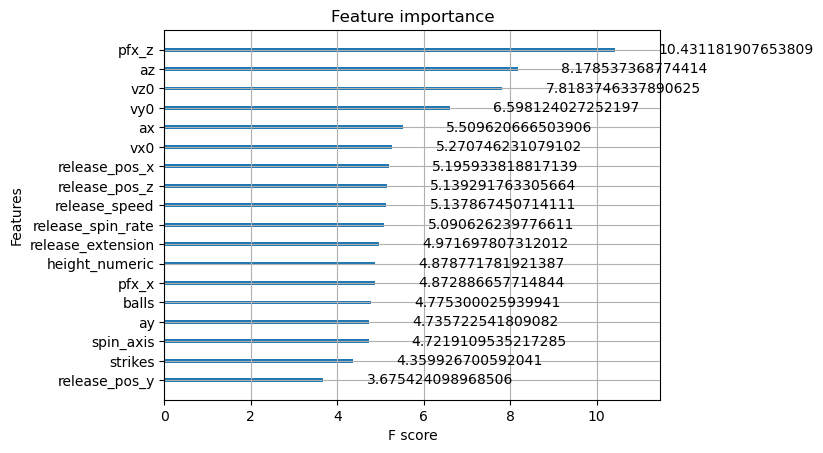

In [ ]:
importance = final_model.get_score(importance_type='gain')
# Visualizing the feature importances
xgb.plot_importance(importance)
plt.show()

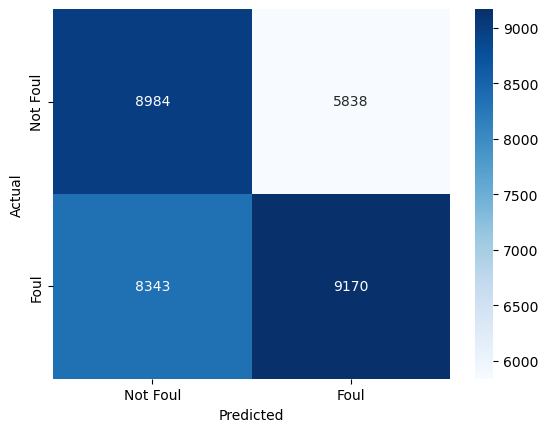

In [ ]:
# Convert predicted probabilities to binary predictions
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Foul', 'Foul'], yticklabels=['Not Foul', 'Foul'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## Testing Data Set Predictions

In [ ]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'balls', 'strikes',
       'pfx_x', 'pfx_z', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az',
       'release_spin_rate', 'release_extension', 'release_pos_y', 'spin_axis',
       'height_numeric'],
      dtype='object')

In [ ]:
predictions = xgb.DMatrix(testing_data, label=testing_label)

In [ ]:
y_pred = final_model.predict(predictions)

In [ ]:
testing_identifiers['xfoul'] = y_pred

C:\Users\clayton\AppData\Local\Temp\ipykernel_3744\2390537613.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_identifiers['xfoul'] = y_pred


In [ ]:
testing_identifiers.head()

,pitch_id_raw,xfoul
0,663364_455139_617228_4_75_10,0.636266
1,663364_455139_617228_3_75_10,0.586549
2,663364_455139_617228_2_75_10,0.347812
3,663364_455139_617228_1_75_10,0.384995
5,663364_593428_605347_4_72_10,0.731799


In [ ]:
testing_identifiers.to_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/breaking_ball/foul_2022&3_xfoul.csv")